In [2]:
import numpy as np
import pandas as pd
import scipy
import re
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import time
import os

import neuro_morpho_toolbox as nmt
from neuro_morpho_toolbox.flat_map import *

import sklearn
from sklearn.decomposition import PCA
import umap
from sklearn import metrics

import pickle
%matplotlib inline

/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.61
Loading CCF brain structure data...
Loading time: 0.00
Loading flat_map ...
Loading time: 2.42


## Load metadata

In [3]:
[ns] = pickle.load(open('./neuron_set_1741cells.pickle', 'rb'))


In [4]:
metadata = pd.read_excel('../Data/Hongkui/metadata_IT_hz2_px.xlsx', index_col=[0], sheet_name=1)
# metadata.loc[((metadata.Region.isin(['MOs', 'MOp'])) & (metadata.Layer=='4')), 'Layer'] = '5'
metadata['Region'] = [i.split('-')[0] for i in metadata['Region'].tolist()]
metadata['Layer'] = metadata['Corrected Layer']

df = metadata.copy()
ns_metadata = ns.metadata.copy()
df['Manually_corrected_soma_region'] = ns_metadata.loc[df.index, 'Manually_corrected_soma_region'].tolist()
df['Region'] = ns_metadata.loc[df.index, 'Manually_corrected_soma_region'].tolist()
df.loc[df['Region'].str.startswith('SSp'), 'Region'] = 'SSp'
df['Layer'] = ns_metadata.loc[df.index, 'Cortical_layer'].tolist()
df['Corrected Layer'] = ns_metadata.loc[df.index, 'Cortical_layer'].tolist()

df['CellType_full']=[';'.join([df.loc[i, 'Region'], 
                               'L'+str(df.loc[i, 'Layer'])
                              ]) for i in df.index.tolist()]

# swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Hanchuan/from/1523_r10_4/'
swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/1_flip_s25/'
# swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/Mapped_Feb2021/3_flip_s25_resample/'
swc_list = [i for i in os.listdir(swc_path) if i.endswith('.swc')]
print('# swc files:\t%d' % (len(swc_list)))

swc_dict = dict(zip([i.split('.')[0].replace('r10_','').replace('p_', '') for i in swc_list], swc_list))

df['swc'] = [swc_dict[i] for i in df.index.tolist()]

# swc files:	1741


In [5]:
regroup_dict = {'MOp;L2/3':'MOp-L2/3',
 'MOp;L5':'MO-L5_IT',
 'MOs;L2/3':'MOs-L2/3',
 'MOs;L5':'MO-L5_IT',
 'SSp;L2/3':'SSp-L2/3',
 'SSp;L5':'SSp-L5_IT',
 'SSs;L2/3':'SSs-L2/3',
 'SSs;L5':'SSs-L5_IT'}
df = df[df['CellType_full'].isin(list(regroup_dict.keys()))]
df['CellType_full'] = df['CellType_full'].map(regroup_dict).tolist()
df['CellType_full'].value_counts()

MOp-L2/3     19
SSp-L2/3     18
MOs-L2/3     17
SSp-L5_IT    15
SSs-L2/3     11
SSs-L5_IT    10
MO-L5_IT      8
Name: CellType_full, dtype: int64

# candidate cells:	98
# non-projecting cells: 4


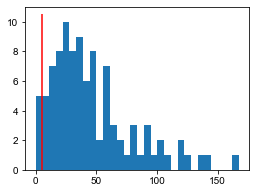

In [6]:
def dist2soma(swc, soma):
    return sklearn.metrics.pairwise_distances(swc[['x', 'y', 'z']], soma[['x', 'y', 'z']])


node_type_list = [1,2,3,4]

radius = 1000

def long_axon_arbor(cn, node_type_list=[2], radius=1000):
    csoma = cn.soma.copy()
    cseg = cn.get_segments()
    cseg['soma_distance'] = dist2soma(cseg, csoma).reshape(-1,)
    cseg = cseg[((cseg.soma_distance>radius) & (cseg.type.isin(node_type_list)))].copy()
    if len(cseg)==0:
        return 0
    return cseg['rho'].sum()
radius = 1000
thres = 5

print('# candidate cells:\t%d' % (len(df)))
df['Long_arbor(mm)'] = [long_axon_arbor(ns.neurons[i], radius=radius)/1000 for i in df.index.tolist()]

fig, ax = plt.subplots(1,1,figsize=(4,3))
_ = ax.hist(df['Long_arbor(mm)'], bins=30)

ax.vlines(x=thres, ymin=0, ymax=ax.get_ylim()[1], color='r')

print("# non-projecting cells: %d" % ((df['Long_arbor(mm)']<thres).sum()))


In [7]:
df['Long_projection'] = df['Long_arbor(mm)']>thres

In [8]:
# swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Hanchuan/from/1708_registered_autoarbor_m3_4/'
swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/Sujun/from/1741_4arbor_revised/'
# swc_path = '/Users/pengxie/Documents/Research/Thalamus_fullMorpho/Data/swc/combined/1_flip_s25/'
swc_list = [i for i in os.listdir(swc_path) if i.endswith('swc')]
print('# swc files:\t%d' % (len(swc_list)))

swc_dict = dict(zip([i.split('.')[0].replace('r10_','').replace('p_', '') for i in swc_list], swc_list))

df['swc'] = [swc_dict[i] for i in df.index.tolist()]

# swc files:	1741


## Preparation

In [9]:

[ss] = pickle.load(open('slice_set_100_test.pickle', 'rb'))

##########################################################################################
# Additional features of ss
##########################################################################################

# 1. normal vector
anchor_df = None
for cur_x_slice in ss.x_list_valid:
    if anchor_df is None:
        anchor_df = ss.dict[cur_x_slice].anchor[['vx', 'vy']]
    else:
        anchor_df = pd.concat([anchor_df, ss.dict[cur_x_slice].anchor[['vx', 'vy']]], axis=0)
# anchor_df.rename(columns={'x':'x_um', 'y':'y_um'}, inplace=True)
anchor_df = pd.concat([ss.m2d.loc[anchor_df.index], anchor_df], axis=1)

print(anchor_df.shape)
anchor_df.head()

# 2. anchor area
def get_anchor_area(ss, cur_x_slice):
    if ss.dict[cur_x_slice].anchor is None:
        return None
    canchor = ss.dict[cur_x_slice].anchor.copy()
    area = []
    for i in canchor.index.tolist():
        carea = 0
        cz = canchor.loc[i, 'x_expand']
        # Find left neighbor
        tp = canchor[canchor['x_expand']<cz].copy()
        if len(tp)>0:
            carea += np.abs(tp['x_expand'].max()-cz)/2
        # Find right neighbor
        tp = canchor[canchor['x_expand']>cz].copy()
        if len(tp)>0:
            carea += np.abs(tp['x_expand'].min()-cz)/2
        carea *= nmt.annotation.space['z']
        carea *= ss.x_thickness
        carea *= 1e-6 # unit mm*2
        area.append(carea)
    return pd.DataFrame({'area':area}, index=canchor.index)
    
area_df = None
for cur_x_slice in ss.x_list_valid:
    canchor_area = get_anchor_area(ss, cur_x_slice)
    if area_df is None:
        area_df = canchor_area
    else:
        area_df = pd.concat([area_df, canchor_area], axis=0)

anchor_df = pd.concat([anchor_df, area_df], axis=1)

# Create a complete flatmap for plotting purposes
flatmap1 = anchor_df[anchor_df.is_boundary][['x', 'z_expand', 'region']].copy()
flatmap2 = anchor_df[anchor_df.is_boundary][['x', 'z_expand', 'region']].copy()
flatmap2['z_expand'] = flatmap2['z_expand']*(-1)
flatmap = pd.concat([flatmap1, flatmap2], axis=0)
flatmap.drop_duplicates(inplace=True)
flatmap.index = np.arange(len(flatmap))


anchor_df.head()

(4404, 10)


x   z_expand  x_ccf  y_ccf  z_ccf  is_anchor region  \
74_120_215  74.0 -96.700143     74    120    215       True    FRP   
74_115_205  74.0 -85.415447     74    115    205       True    FRP   
74_110_188  74.0 -67.632699     74    110    188       True    FRP   
74_105_173  74.0 -51.028485     74    105    173       True    FRP   
74_102_177  74.0 -45.200058     74    102    177       True    FRP   

            is_boundary        vx        vy      area  
74_120_215         True -0.999983  0.005857  0.014106  
74_115_205         True  0.699000  0.715122  0.036334  
74_110_188         True -0.632414  0.774630  0.042984  
74_105_173         True  0.360569  0.932733  0.028041  
74_102_177         True  0.360569  0.932733  0.014053

In [10]:
# '''
# Get the average layer thickness for regions.
# '''

# layer_thickness_dict={}
# def get_layer_thickness(region='Global', anchor_df=anchor_df):
#     # Average cortical thickness
#     ct = 0
#     res = []
#     anchor_df = anchor_df[((anchor_df.x_ccf>=160) & (anchor_df.x_ccf<=400))]
#     if not region == 'Global':
#         anchor_df = anchor_df[anchor_df.region==region]
#     if len(anchor_df)<10:
#         return None
#     anchor_sample = np.random.choice(np.arange(0, len(anchor_df), 1, dtype=int), 
#                                      min(1000, len(anchor_df)), 
#                                      replace=False)
#     for cname in anchor_df.index[anchor_sample].tolist():
#         tp = anchor_df.loc[cname]
#         uv = np.array([tp.vx, tp.vy]/np.sqrt(2)/space)
#         cx = int(tp.x_ccf)
#         if ((cx < 0) | (cx >= cortex_layer_array.shape[0])):
#             continue
#         cy = np.array(np.linspace(0, 5000, 5001)*tp.vy/space, dtype=int) + tp.y_ccf
#         cz = np.array(np.linspace(0, 5000, 5001)*tp.vx/space, dtype=int) + tp.z_ccf

#         ind = ((cy>=0) & (cy<cortex_layer_array.shape[1]) & (cz>=0) & (cz<cortex_layer_array.shape[2]))
#         cy = cy[ind]
#         cz = cz[ind]

#         cres = cortex_layer_array[cx, cy, cz]
#         cres = cres[cres>0]
#         if len(cres) > 500:  # Only consider layers that are thick enough
#             res = res + list(cres)
#             ct += 1
#     res = pd.Series(res).value_counts()
#     res = res / ct

#     res = res.rename(index=layer_dict).sort_index()
#     return res

# layer_thickness_dict['Global'] = get_layer_thickness('Global')
# layer_thickness_dict['MOp'] = get_layer_thickness('MOp')
# layer_thickness_dict['MOs'] = get_layer_thickness('MOs')
# layer_thickness_dict['SSp'] = get_layer_thickness('SSp')
# layer_thickness_dict['SSs'] = get_layer_thickness('SSs')
# layer_thickness_dict['RSP'] = get_layer_thickness('RSP')


In [268]:
def get_layer_thickness_v2(region='Global', anchor_df=anchor_df):
    if not region=='Global':
        region_id = nmt.bs.name_to_id(region)
    ct = 0
    res = []
    anchor_df_tp = anchor_df.copy()
    anchor_df_tp = anchor_df_tp[((anchor_df_tp.x_ccf>=160) & (anchor_df_tp.x_ccf<=400))]
    if not region == 'Global':
        anchor_df_tp = anchor_df_tp[anchor_df_tp.region==region]

    anchor_sample = np.random.choice(np.arange(0, len(anchor_df_tp), 1, dtype=int), 
                                     min(1000, len(anchor_df_tp)), 
                                     replace=False)
    # for cname in anchor_df_tp.index[anchor_sample].tolist():
    for cname in anchor_df_tp.index.tolist():
        tp = anchor_df_tp.loc[cname]
    #     uv = np.array([tp.vx, tp.vy]/np.sqrt(2)/space)
        cx = int(tp.x_ccf)
        if ((cx < 0) | (cx >= cortex_layer_array.shape[0])):
            continue
        step = 0.1
        cy = np.array(np.linspace(0, 1000, 1001)*tp.vy*step, dtype=int) + tp.y_ccf
        cz = np.array(np.linspace(0, 1000, 1001)*tp.vx*step, dtype=int) + tp.z_ccf

        ind = ((cy>=0) & (cy<cortex_layer_array.shape[1]) & (cz>=0) & (cz<cortex_layer_array.shape[2]))
        cy = cy[ind]
        cz = cz[ind]

        tp = pd.DataFrame({'x':[cx]*len(cy),
                          'y':cy,
                          'z':cz
                         })
    #     # Remove duplicates
    #     tp = tp.drop_duplicates()
        if not region=='Global':
            tp['region'] = cortex_region_array[tp.x.tolist(), 
                                      tp.y.tolist(), 
                                      tp.z.tolist()]
            tp = tp[tp['region']==region_id]

        cres = cortex_layer_array[tp.x.tolist(), 
                                  tp.y.tolist(), 
                                  tp.z.tolist()]
        cres = cres[cres>0]
        valid = True
        for i in [1,2,4,5,6]:
            if not i in cres:
                valid = False
        if valid:  # Only consider layers that are thick enough
            res = res + list(cres)
            ct += 1
            tp = pd.Series(cres).value_counts()
    res = pd.Series(res).value_counts()
    res = res / ct * step * space
    res = res.rename(index=layer_dict).sort_index()
    return res

layer_thickness_dict={}
layer_thickness_dict['Global'] = get_layer_thickness_v2('Global')
layer_thickness_dict['MOp'] = get_layer_thickness_v2('MOp')
layer_thickness_dict['MOs'] = get_layer_thickness_v2('MOs')
layer_thickness_dict['SSp'] = get_layer_thickness_v2('SSp')
layer_thickness_dict['SSs'] = get_layer_thickness_v2('SSs')


In [11]:
custom_layer_dict = layer_dict
custom_layer_dict[0] = 'Non-cortical'
custom_layer_list = layer_list + ['Non-cortical']


In [12]:
def my_get_segments(swc):
    # lab = [i for i,name in enumerate(swc.index.tolist()) if swc.loc[name, "parent"]!=(-1)]
    child = swc[(swc.parent.isin(swc.index.tolist()))]
    parent = swc.loc[child.parent]
    rho, theta, phi = nmt.cart2pol_3d(np.array(child[["x", "y", "z"]]) - np.array(parent[["x", "y", "z"]]))
    res = pd.DataFrame({"type": child.type,
                        "rho": rho,
                        "theta": theta,
                        "phi": phi,
                        "x": (np.array(child.x) + np.array(parent.x)) / 2,
                        "y": (np.array(child.y) + np.array(parent.y)) / 2,
                        "z": (np.array(child.z) + np.array(parent.z)) / 2,
                        "degree":child.degree
                        })
    res.index = range(1, len(child)+1)
    # soma
    soma = swc[((swc.type==1) & (swc.parent==-1))]
    if len(soma)>0:
        soma_res = pd.DataFrame({"type": 1,
                                 "rho": 1,
                                 "theta": 0,
                                 "phi": 0,
                                 "x": soma.x.iloc[0],
                                 "y": soma.y.iloc[0],
                                 "z": soma.z.iloc[0],
                                "degree":swc.degree.iloc[0]
                                },
                                index=[0])
        res = soma_res.append(res)
    res.dropna()
    return res

def my_normalize(x):
    return x / np.sqrt(x[0]**2+x[1]**2)

def my_projection(x,y):
    return np.dot(x, y)

def my_weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

## Classification of cortical axon clusters

In [13]:
def get_point_set(df, projection_feild, x_position, x_thickness=1000):
    ps = df.loc[((df.x>(x_position-x_thickness/2)) & (df.x<=(x_position+x_thickness/2))), ['z', 'y', 'rho']]
    if len(ps)==0:
        return None
    ps = ps.rename(columns={'z':'x'})
    ps.x = (ps.x / space).astype('int32')
    ps.y = (ps.y / space).astype('int32')
    ps['voxel'] = [str(int(ps.loc[i, 'x']))+"_"+str(int(ps.loc[i, 'y'])) for i in ps.index.tolist()]
    # Only consider points in the cortex
    ps = ps[ps.voxel.isin(projection_feild.index.tolist())]
    if len(ps)==0:
        return None
    ps['anchor'] = projection_feild.loc[ps.voxel.tolist(), 'anchor'].tolist()
    return ps


In [14]:
layers = ('1', '2/3', '4', '5', '6a', '6b')
def get_region_layer(swc, scale=1/nmt.annotation.space['x']):
    if swc[['x', 'y', 'z']].isna().any().any():
        return 'unknown', 'unknown'
    swc_int = swc[['x', 'y', 'z']].copy().astype(float)
    swc_int['x'] = swc_int['x']*scale
    swc_int['y'] = swc_int['y']*scale
    swc_int['z'] = swc_int['z']*scale
    swc_int = swc_int.round(0).astype(int)
    if ((swc_int.x >= 0) & (swc_int.x < nmt.annotation.size['x']) &
        (swc_int.y >= 0) & (swc_int.y < nmt.annotation.size['y']) &
        (swc_int.z >= 0) & (swc_int.z < nmt.annotation.size['z'])
        ):
        swc_region_id = nmt.annotation.array[swc_int.x,
                                             swc_int.y,
                                             swc_int.z
                                            ]
    else:
        return 'unknown', 'unknown'
    if not swc_region_id in nmt.bs.dict_to_selected.keys():
        return 'unknown', 'unknown'
    region = nmt.bs.dict_to_selected[swc_region_id]
    region = nmt.bs.id_to_name(region)
    res = nmt.bs.id_to_name(swc_region_id)
    for i in layers:
        if res.endswith(i):
            return region, i
    return region, 'unknown'


In [15]:
def get_layer(df):
    df = df.copy()[['x', 'y', 'z']]
    df = (df/space).astype('int')
    res = [custom_layer_dict[cortex_layer_array[df.x[i], 
                                                df.y[i], 
                                                df.z[i]]] for i in df.index.tolist()]
    return res


In [16]:
class cortical_arbor:
    def __init__(self, swc, ss, type_list=[2], celltype=None, name=None, outlier_thres=10):
        ##################################################################################
        # 0. Meta data
        ##################################################################################
        self.get_celltype(celltype)
        self.get_name(name)
        self.valid = True
        
        ##################################################################################
        # 1. swc, segments & center
        ##################################################################################
        self.swc = swc
        # 1.1 Flip if the arbor is in the contra-lateral side, and only keep ipsilateral side
        self.swc, self.hemisphere = self.get_hemisphere()
        # 1.2 Select node types
        self.swc = self.get_swc_type(type_list)
        if len(self.swc)==0:
            self.valid = False
            return
        # 1.3 Only keep the cortical part
        self.swc = self.get_cortical()
        if len(self.swc)==0:
            self.valid = False
            return
        self.swc['layer'] = get_layer(self.swc)
        
        # Segments
        self.seg = my_get_segments(self.swc)
        self.seg['layer'] = get_layer(self.seg)
#         valid_header = pd.Series(['type', 'rho', 'theta', 'phi', 'x', 'y', 'z', 'degree'])
#         assert valid_header.isin(df.columns.tolist()).all(), 'df missing necessary columns'

        # cluster center
        if ((len(self.seg)==0)):
            self.valid = False
            return
        center_name, self.outlier_ratio = self.get_cluster_center(silent=True)  # outlier points will be removed
        if ((len(self.seg)==0) | (self.outlier_ratio>outlier_thres)):
            self.valid = False
            return
        self.center = self.seg.loc[center_name]
        self.region, self.layer = get_region_layer(self.center)
        
        # n_branches
        self.n_branches = (self.seg.degree>2).sum()
        if self.n_branches == 0:
            self.valid = False
            return
        
        ##################################################################################
        # 2. Cortical expansion
        ##################################################################################        
        self.get_surface(ss)
        if len(self.surface)==0:
            self.valid = False
            return
        else:
            distance = metrics.euclidean_distances(self.surface[['2d_x', '2d_y']])
            cid = np.argmin(np.mean(distance, axis=1))
        self.surface_center = self.surface.iloc[cid,:]
#         self.surface_area = len(self.surface.anchor.value_counts())  # TODO: consider anchor area        
        self.get_depth(ss)
        
        ##################################################################################
        # 3. Features
        ##################################################################################
        radius, volume = self.get_volume()
        depth_mean, depth_std = my_weighted_avg_and_std(np.array(self.depth.depth).reshape(-1,),
                                                        np.array(self.depth.rho).reshape(-1,))
#         depth_mean = self.depth.depth.mean()
#         depth_std = self.depth.depth.std()
        self.feature = pd.Series({'2d_x':self.surface_center['2d_x'],
                                  '2d_y':self.surface_center['2d_y'],
                                  '2d_area':self.surface_area,
                                  'total_length':np.sum(self.seg.rho),
                                  'radius':radius,
                                  'volume':volume,
                                  'depth_mean':depth_mean,
                                  'depth_std':depth_std
                                 })    
        if self.hemisphere=='contra':
            self.feature['2d_x'] = self.feature['2d_x']*(-1)
        
        
        ##################################################################################
        # 4. Plotting data
        ##################################################################################
        self.slice, self.slice_df = self.get_slice(ss, x_thickness=1000)
        self.rot_seg = self.get_rotated_segments(ss)
        if self.rot_seg is None:
            self.valid = False
            return
        cc = pd.DataFrame(self.center).transpose()
        cc = self.rotate_swc(cc, ss)
        self.center = self.center.append(pd.Series({'name':center_name, 
                                                    'rx':cc.x,
                                                    'ry':cc.y
                                                   }))
         
        return
    
    def get_celltype(self, celltype):
        self.celltype = celltype
        return
    
    def get_name(self, name):
        self.name = name
        return
    
    def get_seg_type(self, type_list=[2]):
        tp = self.seg.copy()
        tp = tp[tp.type.isin(type_list)]
        return tp
    
    def get_swc_type(self, type_list=[2]):
        tp = self.swc.copy()
        tp = tp[tp.type.isin(type_list)]
        return tp
    
    def get_hemisphere(self):
        tp = self.swc.copy()
        if tp.z.median()>=(nmt.annotation.micron_size['z']/2):
            hemisphere = 'contra'
            tp.z = nmt.annotation.micron_size['z'] - tp.z
        else:
            hemisphere = 'ipsi'
        tp = tp[tp.z < (nmt.annotation.micron_size['z']/2)]
        return tp, hemisphere
    
    def get_cortical(self):
        tp = self.swc.copy()
        tp.loc[:, ['x', 'y', 'z']] = (tp.loc[:, ['x', 'y', 'z']]/space).astype('int')
        tp = tp[((tp.x>=0) & (tp.x<cortex_region_array.shape[0]) &
                 (tp.y>=0) & (tp.y<cortex_region_array.shape[1]) &
                 (tp.z>=0) & (tp.z<cortex_region_array.shape[2])
                )]
        tp['is_cortical'] = list(cortex_region_array[tp.x, tp.y, tp.z]>0)
        tp = tp[tp.is_cortical]                  # Keep cortex only
        return self.swc.loc[tp.index]
    
    def get_layer(self):
        df = self.seg.copy()[['x', 'y', 'z']]
        df = (df/space).astype('int')
        res = [custom_layer_dict[cortex_layer_array[df.x[i], 
                                                    df.y[i], 
                                                    df.z[i]]] for i in df.index.tolist()]
        return res
    
    def assign_x_slice(self, ss):
        df = self.seg.copy()
        if len(df)==0:
            return 0
        
        x_thickness = ss.x_thickness
        x_list = sorted(ss.x_list_valid)

        bins = [int((i-x_thickness/2)) for i in x_list+[x_list[-1]+x_thickness]]
        density = np.histogram(df.x, bins, weights=df.rho)[0]
        res = x_list[np.argmax(density)]
        return res

    def get_slice(self, ss, x_thickness=500, silent=True):
        df = self.seg.copy()
        x_slice = self.assign_x_slice(ss)
        total_length = np.sum(df.rho)
        df = df[((df.x>=(x_slice-x_thickness/2)) & (df.x<(x_slice+x_thickness/2)))]
        slice_length = np.sum(df.rho)
        if not silent:
            print("%.2f%% arbor selected." % (slice_length / total_length * 100))
        return x_slice, df

    def get_cluster_center(self, silent=True):
        df = self.seg.copy()[['x', 'y', 'z']]
        distance = metrics.euclidean_distances(df)
        cid = np.argmin(np.mean(distance, axis=1))
        cid = df.index.tolist()[cid]
#         return cid,0
        # exclude outliers
        md = metrics.euclidean_distances(np.array(df.loc[cid]).reshape(1, 3), df).reshape(-1,)
#         tp = df[md>(np.median(md)+2*min(500, np.std(md)))] # define outliers
        tp = df[md>2000] # define outliers
        outlier_ratio = len(tp) / len(df) * 100
        if not silent:            
            if outlier_ratio>10:
                print("%s: %.2f%% arbor excluded." % (self.name, outlier_ratio))
        self.seg.drop(index=tp.index, inplace=True)
        # Re-center
        df = self.seg.copy()[['x', 'y', 'z']]
        distance = metrics.euclidean_distances(df)
        cid = np.argmin(np.mean(distance, axis=1))
        cid = df.index.tolist()[cid]
        return cid, outlier_ratio
    
    def get_volume(self, thres=0.7):
        df = self.seg.copy()
        distance = metrics.euclidean_distances(np.array(self.center[['x', 'y', 'z']]).reshape(1,3),
                                               np.array(self.seg[['x', 'y', 'z']]).reshape(-1,3)
                                              )
        df['distance'] = distance.reshape(-1,)
        df = df.sort_values(['distance'], ascending=True)
        tp = df[df.rho.cumsum()<(np.sum(df.rho)*thres)]
        if len(tp) == 0:
            return np.nan, np.nan
        radius = tp.distance.tolist()[-1]
        volume = 4/3 * np.pi * radius**3
        return radius, volume
    
    def rotate_swc(self, df, ss, median_node=None):
        cur_x_slice = self.slice
   
        if median_node is None:
            median_node = self.center.copy()[['z', 'y']] / space
            median_node.rename(index={'z':'x'}, inplace=True)
            median_node = median_node.astype('int')
        cur_x_slice_ind = np.argmin(np.abs(np.array(ss.x_list_valid - self.center['x'])))
        cur_x_slice = ss.x_list_valid[cur_x_slice_ind]

        rot_swc = df.copy()
        df= df.copy()[['z', 'y', 'layer']]
        df.rename(columns={'z':'x'}, inplace=True)

        # Find rotation vectors
        if not str(median_node.x)+"_"+str(median_node.y) in ss.dict[cur_x_slice].pf.index.tolist():
#             print(cur_x_slice, str(median_node.x)+"_"+str(median_node.y))
            print('cannot rotate swc:\t%s' % (self.name))
            self.valid = False
            return None
        cur_pf = ss.dict[cur_x_slice].pf.loc[str(median_node.x)+"_"+str(median_node.y)]
        cur_anchor = ss.dict[cur_x_slice].anchor.loc[cur_pf.anchor]
        cur_orgin = cur_anchor[['x', 'y']] * space
        v1 = cur_anchor[['vx', 'vy']]
        v2 = v1.copy()
        v2[['vx', 'vy']] = [-v1['vy'], v1['vx']]
        rot_array = np.array([[v2['vx'], v1['vx']],
                              [v2['vy'], v1['vy']]
                             ])

        df = pd.DataFrame(np.dot(df[['x', 'y']] - cur_orgin, rot_array), index=df.index, columns=['x', 'y'])
        df['z'] = 0
        rot_swc[['x', 'y', 'z']] = df[['x', 'y', 'z']]
        return rot_swc

    def get_rotated_segments(self, ss):
        df = self.swc.copy()
        rot_swc = self.rotate_swc(df, ss)
        if rot_swc is None:
            return None
        df = my_get_segments(rot_swc)
        df['layer'] = self.swc['layer']
#         df = self.seg.copy()
        
        segments = nmt.pol2cart_3d(df.rho, df.theta, df.phi)
        df_parent = df.copy()
        df_parent[['x', 'y', 'z']] = df_parent[['x', 'y', 'z']] - segments/2
        df_child = df.copy()
        df_child[['x', 'y', 'z']] = df_child[['x', 'y', 'z']] + segments/2

#         # Fix rotation vector
#         median_node = self.center[['z', 'y']] / space
#         median_node.rename(index={'z':'x'}, inplace=True)
#         median_node = median_node.astype('int')

#         rot_child = self.rotate_swc(df_child, ss, median_node)
#         rot_parent = self.rotate_swc(df_parent, ss, median_node)
        rot_child = df_child
        rot_parent = df_parent
        if ((rot_child is None) | (rot_parent is None)):
            self.valid = False
            return None
        
        tp = pd.DataFrame(index=range(len(df)*3))
        tp['Xe'] = np.nan
        tp['Ye'] = np.nan
        tp['Le'] = np.nan
        
        ind1 = list(np.arange(len(df))*3+0)
        ind2 = list(np.arange(len(df))*3+1)
        ind3 = list(np.arange(len(df))*3+2)
        tp.loc[ind1, 'Xe'] = rot_child.x.tolist()
        tp.loc[ind1, 'Ye'] = rot_child.y.tolist()
        tp.loc[ind1, 'Le'] = rot_child.layer.tolist()
        
        tp.loc[ind2, 'Xe'] = rot_parent.x.tolist()
        tp.loc[ind2, 'Ye'] = rot_parent.y.tolist()
        tp.loc[ind2, 'Le'] = rot_parent.layer.tolist()
        
        tp.loc[ind3, 'Le'] = rot_parent.layer.tolist()
        
        tp.Le = tp.Le.map(layer_dict_reverse)

        tp.Xe = np.array(tp.Xe, dtype=np.float)
        tp.Ye = np.array(tp.Ye, dtype=np.float)
        tp.Le = np.array(tp.Le, dtype=np.int)
        return tp
    
    ##########################################################################################
    # Functions for flat map
    ##########################################################################################
    def get_surface(self, ss):
        ps = pd.DataFrame(columns=['x', 'y', 'rho', 'voxel', 'anchor'])
        for cur_x_position in ss.x_list_valid:
            cur_shell = ss.dict[cur_x_position].shell
            cur_anchor = ss.dict[cur_x_position].anchor
            cur_pf = ss.dict[cur_x_position].pf
            if cur_shell is None:
                continue
            cur_ps = get_point_set(self.seg,
                                   projection_feild=cur_pf, 
                                   x_position=cur_x_position,
                                   x_thickness=ss.x_thickness
                                  )
            if cur_ps is None:
                continue                
            ps = pd.concat([ps, cur_ps], axis=0)
        ps = ps[['anchor', 'rho']]
        ps['2d_x'] = [anchor_df.loc[i, 'z_expand'] for i in ps.anchor.tolist()]
        ps['2d_y'] = [anchor_df.loc[i, 'x'] for i in ps.anchor.tolist()]
        ps['2d_area'] = [anchor_df.loc[i, 'area'] for i in ps.anchor.tolist()]
        self.surface = ps
        
        # Calculate surface area
        # sort anchor by sum of rho
        wdf = pd.DataFrame(ps.groupby('anchor')['rho'].sum())
        wdf = wdf.sort_values(['rho'], ascending=False)
        # Find anchors that cover x% of rho
        wdf = wdf.cumsum() / wdf['rho'].sum()*100
        wdf = wdf.iloc[:((wdf['rho']<95).sum()+1),:]
        # sum up area of each anchor
        self.surface_area = anchor_df.loc[wdf.index, 'area'].sum()
        return
    
    def get_depth(self, ss):
        depth = pd.DataFrame(columns=['depth', 'rho'])
        if len(self.surface) == 0:
            return depth
        df = pd.concat([self.surface[['anchor']], 
                        self.seg.loc[self.surface.index, ['x', 'y', 'z', 'rho']]
                       ], axis=1)
        anchor_list = df.anchor.value_counts().index.tolist()
        prof = []
        ind_list = []
        for cur_anchor in anchor_list:
            cur_df = np.array(df.loc[df.anchor == cur_anchor, ['z', 'y']]).reshape(-1,2)
            if len(cur_df)==0:
                continue
            cur_df = cur_df - np.array(anchor_df.loc[cur_anchor, ['z_ccf', 'y_ccf']]*space).reshape(1,2)
            anchor_vector = my_normalize(np.array(anchor_df.loc[cur_anchor, ['vx', 'vy']]))
            anchor_vector = anchor_vector.reshape(-1,1)
            prof = prof + list(my_projection(cur_df, anchor_vector).reshape(-1,))
            ind_list = ind_list + df.index[df.anchor == cur_anchor].tolist()
        self.depth = pd.DataFrame({'depth':prof,
                                   'rho':df.rho[ind_list],
                                  },
                                  index=ind_list)
        return



    def plot_arbor(self, ax=None, x_shift=0, y_shift=0):
        if ax is None:
            fig, ax = plt.subplots(1,1,figsize=(2.5,3))
            ax.invert_yaxis()
            ax.set_ylim(1000, -200)
            ax.set_xlim(-500, 500)
        ax.plot(self.rot_seg.Xe+x_shift, 
                self.rot_seg.Ye+y_shift)
        ax.plot(self.center.rx+x_shift, self.center.ry+y_shift, c='k', marker='o')
        return ax


## Define cortical axon clusters

In [17]:
def get_dist_soma(en, ea):
    ec = ea.center[['x', 'y', 'z']].copy()
    if ea.hemisphere=='contra':
        ec['x'] = nmt.annotation.micron_size['x'] - ec['x']
    dist_soma = metrics.euclidean_distances(np.array(ec[['x', 'y', 'z']]).reshape(1,-1), 
                                            np.array(en.soma[['x', 'y', 'z']]).reshape(1,-1))[0,0]
    return dist_soma


In [19]:
class my_neuron:
    def __init__(self, file, zyx=False, registered=True, scale=None, celltype=None, outlier_thres=10):
        self.file = file
        self.name = file.split("/")[-1].split(".")[0].replace('r10_', '')
        self.celltype = celltype
        self.registered = registered

        swc = pd.read_csv(self.file, index_col=[0], sep=" ")
        if zyx:
            names = ["##n", "type", "z", "y", "x", "r", "parent"]
        else:
            names = ["##n", "type", "x", "y", "z", "r", "parent"]
        swc.rename(columns={'id':'##n', 'pid':'parent', 'labels':'arbor_id'}, inplace=True)

        if scale is not None:
            swc.x = swc.x * scale
            swc.y = swc.y * scale
            swc.z = swc.z * scale
        self.swc = swc
        self.get_soma()
        if self.soma.z[self.name] > (annotation.micron_size["z"] / 2):
            self.flip('z', annotation.micron_size["z"])
        
        _ = self.get_degree()
        
        self.get_arbors()

        return
    
    def get_soma(self):
        soma = self.swc[((self.swc.type==1) & (self.swc.parent==-1))]
        if len(soma)!=1:
            # print(("Invalid number of soma found: %d" % len(soma)))
            self.soma = pd.DataFrame({"x": np.nan,
                                      "y": np.nan,
                                      "z": np.nan,
                                      "region":"unknown"
                                      }, index=[self.name])
        else:
            soma = pd.DataFrame({"x": soma.x.iloc[0],
                                 "y": soma.y.iloc[0],
                                 "z": soma.z.iloc[0],
                                "region": "unknown"
                                 },
                                index=[self.name])
            # If registered, assign soma region
            if self.registered:
                if ((int(soma.x.iloc[0] / annotation.space['x']) >= 0) & (int(soma.x.iloc[0] / annotation.space['x']) < annotation.size['x']) &
                    (int(soma.y.iloc[0] / annotation.space['y']) >= 0) & (int(soma.y.iloc[0] / annotation.space['y']) < annotation.size['y']) &
                    (int(soma.z.iloc[0] / annotation.space['z']) >= 0) & (int(soma.z.iloc[0] / annotation.space['z']) < annotation.size['z'])
                ):
                    soma_region_id = annotation.array[int(soma.x.iloc[0] / annotation.space['x']),
                                                      int(soma.y.iloc[0] / annotation.space['y']),
                                                      int(soma.z.iloc[0] / annotation.space['z'])]
                    if soma_region_id != 0:
                        soma.loc[self.name, 'region'] = bs.id_to_name(soma_region_id)
                if soma.loc[self.name, "z"] < (annotation.micron_size["z"] / 2):
                    self.hemi = 1
                else:
                    self.hemi = 2
            self.soma = soma
        return self.soma
    
    def get_degree(self):
        self.swc['degree'] = self.swc['parent'].isin(self.swc.index).astype('int') 
        n_child = self.swc.parent.value_counts()
        n_child = n_child[n_child.index.isin(self.swc.index)]
        self.swc.loc[n_child.index, 'degree'] = self.swc.loc[n_child.index, 'degree'] + n_child
        return self.swc[['degree']]
    
    def flip(self, axis, axis_max):
        self.swc[axis] = axis_max - self.swc[axis]
        return
    
    def get_arbors(self):
        alist = sorted(self.swc.arbor_id.value_counts().index.tolist())
        self.arbor_names = []
        self.arbors = {}
        # soma arbor id
        if not ((self.swc['type'].iloc[0]==1) & (self.swc['parent'].iloc[0]==(-1))):
            print(self.name)
            return
        soma_arbor_id = self.swc['arbor_id'].iloc[0]
        for cid in alist:
            if cid == soma_arbor_id:
#                 print('soma arbor:\t%s' % (cid))
                continue  # Here we only care about long projection arbors
            cname = self.name+"_"+str(cid)
            # Skip arbors with too few branch points
            cswc = self.swc[self.swc.arbor_id==cid].copy()
            n_branch = (cswc['degree']>2).sum()
            if n_branch==0:
                continue
            carbor = cortical_arbor(cswc, ss, 
                                    type_list=[2], name=cname, celltype=self.celltype,
                                    outlier_thres=outlier_thres
                                   )
            if not carbor.valid:
                continue
            total_length = np.sum(carbor.seg.rho)
            # Skip arbors that are too short
            if ((carbor.valid!=True) | (total_length<1000)):
                continue
            self.arbors[cname] = carbor
            self.arbor_names.append(cname)
        return

outlier_thres = 50
# ename = '18864_3494_x2380_y13749'
ename = '191812_2978_x7903_y22705'
etype = df.CellType_full[ename]
en = my_neuron(swc_path + swc_dict[ename], scale=25, celltype=etype, outlier_thres=outlier_thres)

for i in en.arbor_names:
    ea = en.arbors[i]
    dist_soma = get_dist_soma(en, ea)
    print(i, ea.outlier_ratio, dist_soma)
    print(ea.region, en.arbors[i].layer)


191812_2978_x7903_y22705_2 2.083333333333333 6065.932943368029
MOp 5
191812_2978_x7903_y22705_3 0.0 607.357625548987
MOp 2/3


191812_2978_x7903_y22705_2
191812_2978_x7903_y22705_3


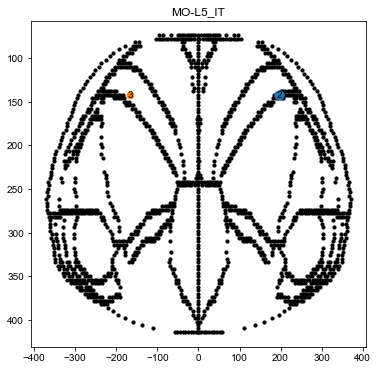

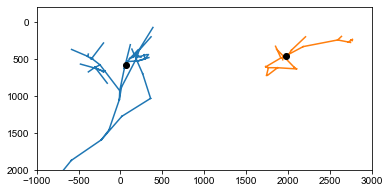

In [20]:
def plot_neuron(cname=None, en=None):
    if en is None:
        en = neuron_dict[cname]
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.scatter(flatmap.z_expand, 
               flatmap.x,
               c='k', s=10
              )

    for i,ename in enumerate(en.arbor_names):
        ax.scatter(en.arbors[ename].feature['2d_x'],
                   en.arbors[ename].feature['2d_y'],
                   s=en.arbors[ename].feature['2d_area']*300,
                   c='C'+str(i)
                  )
        ax.text(en.arbors[ename].feature['2d_x'],
                en.arbors[ename].feature['2d_y'],
                s=ename.split('_')[-1], fontdict={'ha':'center', 'va':'center'}
                  )
    ax.invert_yaxis()
    ax.set_title(en.celltype)

    # Plot arbors of a neuron
    x_shift = 2000
    n = len(en.arbors)
    fig, ax = plt.subplots(1,1,figsize=(3*n, 3))

    for i,ename in enumerate(en.arbor_names):
        ca = en.arbors[ename]
        print(ename)
        ca.plot_arbor(ax=ax, x_shift=x_shift*i)


    ax.set_ylim(2000, -200)
    ax.set_xlim(-x_shift/2, x_shift*n-x_shift/2)
    return

plot_neuron(en=en)


## Large scale computation

In [24]:
outlier_thres = 50

neuron_dict = {}
arbor_dict = {}
dist_soma = []
# cell_list = df[df.CellType_full=='MOs;L2/3'].index.tolist()
cell_list = df.index.tolist()
ct = 0
for cname in cell_list[:]:
    swc_file = swc_path+swc_dict[cname]
    if os.path.isfile(swc_file):        
        ctype = df.CellType_full[cname]
        cn = my_neuron(swc_file, scale=25, celltype=ctype, outlier_thres=outlier_thres)
        for i in cn.arbor_names:
            dist_soma.append(get_dist_soma(cn, cn.arbors[i]))
        arbor_dict.update(cn.arbors)
        neuron_dict.update({cname:cn})
        print("%d\t%s:\t%d arbors." % (ct, cname, len(cn.arbor_names)))
        ct += 1

arbor_list = list(arbor_dict.keys())
neuron_list = list(neuron_dict.keys())
dist_soma = pd.DataFrame(dist_soma, index=arbor_list, columns=['dist_soma'])
pickle.dump([arbor_dict], open('arbor_dict_distal_k4_L2-5_IT.pickle', 'wb'))

0	17300_3426_x20339_y44872:	3 arbors.
1	17300_3514_x19676_y45282:	3 arbors.
2	17787_4521_x5172_y12873:	1 arbors.
3	17788_4719_x3512_y9492:	3 arbors.
4	18453_3186_x12745_y7108:	1 arbors.
5	18453_1641_x24165_y10580:	3 arbors.
6	18453_1643_x24077_y11694:	3 arbors.
7	18453_1924_x22284_y8069:	2 arbors.
8	18453_2190_x23739_y8507:	3 arbors.
9	18453_2400_x15836_y7243:	3 arbors.
10	18453_2884_x12998_y7285:	3 arbors.
11	18453_3516_x21006_y6048:	3 arbors.
12	18453_2632_x11687_y8383:	3 arbors.
13	18453_2991_x13607_y7348:	3 arbors.
14	18453_2645_x28684_y11703:	3 arbors.
15	18453_2713_x27713_y9899:	3 arbors.
16	18453_3021_x27493_y8943:	3 arbors.
17	18453_3456_x24161_y6646:	3 arbors.
18	18453_3767_x22604_y5643:	3 arbors.
19	18453_3795_x13584_y5960:	3 arbors.
20	18453_4067_x16924_y5288:	3 arbors.
21	18453_4221_x16935_y5165:	2 arbors.
22	18453_3945_x11262_y6434:	2 arbors.
23	18453_4345_x12044_y5189:	2 arbors.
24	18453_4540_x32498_y9442:	3 arbors.
25	18453_4711_x14090_y3943:	2 arbors.
26	18453_4725_x306

In [25]:
[arbor_dict] = pickle.load(open('arbor_dict_distal_k4_L2-5_IT.pickle', 'rb'))
arbor_list = list(arbor_dict.keys())

In [26]:
'''
Data preparation done
'''

'\nData preparation done\n'

17300_3426_x20339_y44872_0 SSs-L5_IT
17300_3426_x20339_y44872_2 SSs-L5_IT
17300_3426_x20339_y44872_3 SSs-L5_IT
17300_3514_x19676_y45282_1 SSs-L5_IT
17300_3514_x19676_y45282_2 SSs-L5_IT
MOs


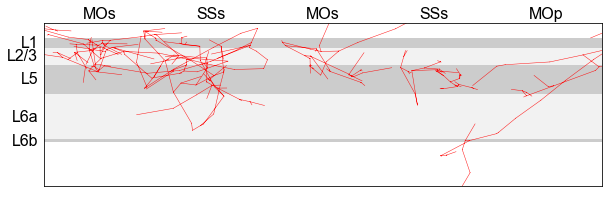

In [286]:
def layer_shade(region, ax, fontsize=16, only_L1=True, show_ticks=True):
    assert region in layer_thickness_dict.keys(), 'Invalid region name provided'
    layer_thickness = layer_thickness_dict[region]
    ct = 0
    cymin = 0
#     xmin = ax.get_xlim()[0]
    tx = ax.get_xlim()[0]*1.01 + ax.get_xlim()[1]*(-0.01)

    for i in layer_list:
        if not i in layer_thickness.index.tolist():
            continue
        cymax = cymin + layer_thickness[i]
        cymean = (cymin + cymax) / 2
        if (not only_L1) | (i=='L1'):
            if (ct % 2) == 0:
                ax.axhspan(cymin, cymax, color='grey', alpha=0.4, linewidth=0)
            else:
                ax.axhspan(cymin, cymax, color='grey', alpha=0.1, linewidth=0)
        if fontsize>0:
            ax.text(tx, cymean, i, fontdict={'va':'center', 'ha':'right', 'fontsize':fontsize})
        ct += 1
        cymin = cymax
    if show_ticks:
        yticks = [0]
        sum_thickness = 0
        for i in layer_list:
            if not i in layer_thickness.index.tolist():
                continue
            sum_thickness = sum_thickness + layer_thickness[i]
            yticks.append(sum_thickness)
        ax.set_yticks(yticks)
        ax.set_yticklabels([])
        ax.tick_params('both', length=5, width=1, which='major')
    return 1

def plot_arbor(arbor, ax=None, x_shift=0, y_shift=0, color=None, lw=1):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(2.5,3))
        ax.invert_yaxis()
        ax.set_ylim(1000, -200)
        ax.set_xlim(-500, 500)
    pdf = arbor.rot_seg.copy()
    if color is None:        
        # Axon arbor
        ax.plot(pdf.Xe+x_shift, 
                pdf.Ye+y_shift, 
                alpha=0.9,
                c='r',
                lw=lw)

    else:
        # Axon arbor
        ax.plot(pdf.Xe+x_shift, 
                pdf.Ye+y_shift, 
                alpha=0.9,
                c=color,
                lw=lw)

#     ax.plot(arbor.center.rx+x_shift, arbor.center.ry+y_shift, c='k', marker='o')
    return ax

def plot_arbor_swc(arbor, ax=None, x_shift=0, y_shift=0, color=None, lw=1):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(2.5,3))
        ax.invert_yaxis()
        ax.set_ylim(1000, -200)
        ax.set_xlim(-500, 500)
    pdf = arbor.rot_.copy()
    if color is None:        
        # Axon arbor
        ax.plot(pdf.Xe+x_shift, 
                pdf.Ye+y_shift, 
                alpha=0.9,
                c='r',
                lw=lw)

    else:
        # Axon arbor
        ax.plot(pdf.Xe+x_shift, 
                pdf.Ye+y_shift, 
                alpha=0.9,
                c=color,
                lw=lw)

#     ax.plot(arbor.center.rx+x_shift, arbor.center.ry+y_shift, c='k', marker='o')
    return ax

def plot_arbor_list(arbor_list, region, x_shift=1000, 
                    arbor_name=False, 
                    arbor_type=False,
                    arbor_region=False,
                    ax=None, color=None, fontsize=16, lw=1,
                    ylim = (1500, -200),
                    show_layer_ticks=True,
                    only_L1=False,
                   ):
    n = len(arbor_list)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(2*n, 3))
    for i,cname in enumerate(arbor_list[:n]):
        ca = arbor_dict[cname]        
        if type(color)==list:
            plot_arbor(ca, ax=ax, x_shift=x_shift*i, color=color[i%len(color)], lw=lw)
        else:
            plot_arbor(ca, ax=ax, x_shift=x_shift*i, color=color, lw=lw)
#         # soma point
#         ax.plot(sdf.loc[cname, 'Xe']+x_shift*i, 
#                 sdf.loc[cname, 'Ye'],
#                 color='k',
#                 marker='o',
#                )
        if arbor_name:
            ax.text(i*x_shift, -200, '_'.join(cname.split('_')[:2]), 
                    fontdict={'ha':'center', 'va':'bottom', 'fontsize':fontsize, 'rotation':0})
        if arbor_type:
            txt = ca.celltype
            ax.text(i*x_shift, -220, txt, fontdict={'ha':'center', 'va':'bottom', 'fontsize':fontsize, 'rotation':0})
        if arbor_region:
            txt = ca.region.split('-')[0]
            ax.text(i*x_shift, -220, txt, fontdict={'ha':'center', 'va':'bottom', 'fontsize':fontsize, 'rotation':0})

    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(-x_shift/2, x_shift*n-x_shift/2)
    ax.set_yticks([])
    print(region)
    layer_shade(region, ax, fontsize=16, only_L1=only_L1, show_ticks=show_layer_ticks)
    ax.set_xticks([])
    return ax


for i in arbor_list[:5]:
    print(i, arbor_dict[i].celltype)
    
plot_arbor_list(arbor_list[:5], 'MOs', color=None, lw=0.5, arbor_region=True, ylim=(2000,-200), show_layer_ticks=False)

MOs
MOs
MOs


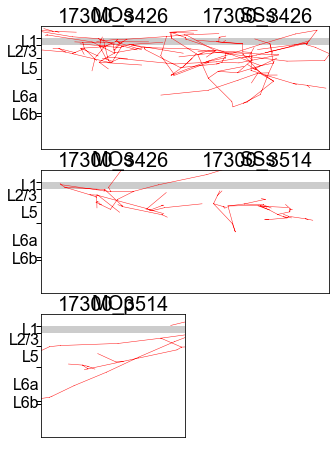

In [273]:
def plot_arbor_list_wrapper(clist, region, x_shift=1000, 
                    arbor_name=True, 
                    arbor_type=True,
                            arbor_region=True,
                    ax=None, color=None, fontsize=16, lw=1,
                    ylim = (1500, -200), ncol=10):
    nrow = int(len(clist)/ncol) + int((len(clist) % ncol)!=0)

    fig = plt.figure(figsize=(2*ncol, 2*nrow))

    uh_space = 1/nrow*0.15
    uh = (1/nrow - uh_space)
    uw = 1/ncol

    
    for i in range(nrow):
        cclist = clist[(i*ncol):min(len(clist), (i+1)*ncol)]
        
        # Plot vertical views
        cax = fig.add_axes([0, 1-1/nrow*(i+1), uw*len(cclist), uh])
        plot_arbor_list(cclist, 
                        region, 
                        x_shift=x_shift, 
#                         y_shift=y_shift,
                        ax=cax,
                        lw=lw, 
                        color=color,
                        arbor_name=arbor_name,
                        arbor_type=arbor_type,
                        arbor_region=arbor_region,
                        fontsize=20,
                        ylim=ylim
                       )

#     ct = ctype.replace('/', '-')
#     cl = clayer.replace('/', '-')
#     fig.savefig(('../Figure/cortical_slice/%s_%s.pdf' % (ct, cl)), bbox_inches='tight')
    return fig



_ = plot_arbor_list_wrapper(arbor_list[:5], 'MOs', color=None, lw=0.5, arbor_type=False, ylim=(2000,-200), ncol=2)

## Arbor dataframe

In [32]:
adf = pd.DataFrame({'cellname':['_'.join(i.split('_')[:-1]) for i in arbor_list]
                   },index=arbor_list)
adf['celltype'] = [df.Region[i] for i in adf['cellname'].tolist()]
adf['celltype_full'] = [df.CellType_full[i] for i in adf['cellname'].tolist()]
adf['region'] = [arbor_dict[i].region for i in arbor_list]
idlist = [i for i in adf.index.tolist() if adf.loc[i, 'region'].startswith('SSp')]
adf.loc[idlist, 'region'] = 'SSp'
adf['layer'] = [arbor_dict[i].layer for i in arbor_list]
adf['hemisphere'] = [arbor_dict[i].hemisphere for i in arbor_list]
adf['length'] = [arbor_dict[i].seg.rho.sum() for i in adf.index.tolist()]

adf.head()

cellname celltype celltype_full  \
17300_3426_x20339_y44872_0  17300_3426_x20339_y44872      SSs     SSs-L5_IT   
17300_3426_x20339_y44872_2  17300_3426_x20339_y44872      SSs     SSs-L5_IT   
17300_3426_x20339_y44872_3  17300_3426_x20339_y44872      SSs     SSs-L5_IT   
17300_3514_x19676_y45282_1  17300_3514_x19676_y45282      SSs     SSs-L5_IT   
17300_3514_x19676_y45282_2  17300_3514_x19676_y45282      SSs     SSs-L5_IT   

                           region layer hemisphere        length  
17300_3426_x20339_y44872_0    MOs   2/3       ipsi  29125.331930  
17300_3426_x20339_y44872_2    SSs     5     contra   8911.642990  
17300_3426_x20339_y44872_3    MOs   2/3       ipsi   7509.329935  
17300_3514_x19676_y45282_1    SSs     4     contra   5294.111429  
17300_3514_x19676_y45282_2    MOp     5       ipsi  11343.835468

In [33]:
def get_dict_target(target_regions):
    res = {}
    for cur_region in target_regions:        
        child_ids = nmt.bs.get_all_child_id(cur_region)
        for i in child_ids:
            res[nmt.bs.id_to_name(i)] = cur_region
    return res

select_region_dict = get_dict_target([nmt.bs.id_to_name(i) for i in nmt.bs.selected_regions])

## Coronal sections

In [267]:
layer_thickness_dict.keys()

dict_keys(['Global', 'MOp', 'MOs', 'SSp', 'SSs', 'ECT', 'VISC', 'GU', 'PERI'])

In [76]:
simple_list

['MOs',
 'SSp',
 'MOp',
 'SSs',
 'VISC',
 'ECT',
 'PERI',
 'GU',
 'RSPd',
 'VISrl',
 'AIp']

In [78]:
tp = adf['region'].value_counts()
print(tp)

# simple_list = tp[tp>1].index.tolist()
simple_list = ['MOs',
 'SSp',
 'MOp',
 'SSs',
 'VISC',
 'ECT',
 'PERI',
 'GU',
 'RSP',
]
simple_dict = get_dict_target(simple_list)

MOs       78
SSp       51
MOp       43
SSs       25
VISC      11
ECT        5
PERI       4
GU         4
RSPd       3
VISrl      2
AIp        2
AUDv       1
AIv        1
AId        1
RSPagl     1
FRP        1
ORBl       1
ACAd       1
ILA        1
VISpm      1
TEa        1
Name: region, dtype: int64


In [79]:
target_dict = {}
contra_dict = {}

In [80]:
ctype = 'SSp-L2/3'
tp = adf[adf['celltype_full'].isin([ctype])]['region'].value_counts()

target_dict[ctype] = tp[tp>1].index.tolist()
print(target_dict[ctype])
contra_dict[ctype] = []
for i in tp:
    if i==ctype:
        contra_dict[ctype].append(True)
    else:
        contra_dict[ctype].append(False)


['SSp', 'MOs', 'MOp', 'SSs']


In [126]:
rlist = ['SSp-L2/3', 'SSp-L5_IT', 'SSs-L2/3', 'SSs-L5_IT', 'MOp-L2/3', 'MOs-L2/3', 'MO-L5_IT']

for ctype in rlist:
    tp = adf[adf['celltype_full'].isin([ctype])]['region'].value_counts()
    target_dict[ctype] = tp[tp>1].index.tolist()
    print(target_dict[ctype])
    contra_dict[ctype] = []
    for i in target_dict[ctype]:
        if ctype.startswith(i):
            contra_dict[ctype].append(True)
        else:
            contra_dict[ctype].append(False)
    

['SSp', 'MOs', 'MOp', 'SSs']
['SSs', 'MOs', 'SSp', 'ECT', 'VISC', 'MOp', 'GU']
['SSs', 'SSp', 'MOp', 'VISC', 'PERI']
['MOs', 'SSs', 'VISC', 'GU', 'SSp', 'MOp']
['MOs', 'MOp', 'SSp', 'RSPd', 'SSs']
['MOs', 'MOp']
['MOs', 'MOp', 'SSp']


MOs
MOp
SSp


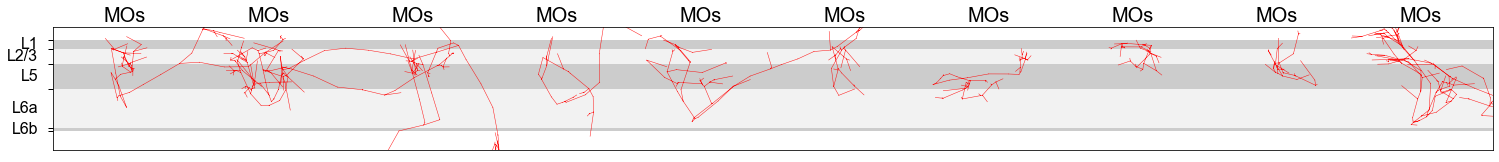

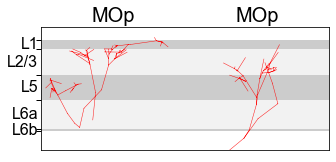

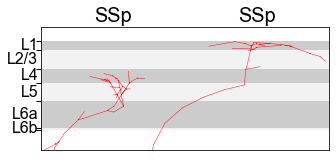

In [278]:
def plot_distal_arbors(ctype):
    fname = ctype.replace('/', '_')
    tp = adf[adf['celltype_full'].isin([ctype])].copy()
    tp['region'] = tp['region'].map(simple_dict).tolist()
#     print(tp['region'].value_counts())
    ncol=10
    nmax = 10

    for ctarget, ccontra in zip(target_dict[ctype], contra_dict[ctype]):
        clist = tp[((tp['region'] == ctarget) & (tp['length']>5000))].index.tolist()
        if len(clist)==0:
            continue
        if ccontra:
            clist = [j for j in clist if tp.loc[j, 'hemisphere']=='contra']
        if len(clist)>nmax:
            rd_list = np.random.choice(np.arange(len(clist)), nmax, replace=False)
            rd_list = list(rd_list)
            clist = [clist[i] for i in rd_list]
        if not ctarget in list(layer_thickness_dict.keys()):
            print(ctarget)
            layer_thickness_dict[ctarget] = get_layer_thickness_v2(ctarget)
        fig = plot_arbor_list_wrapper(clist, ctarget, color=None, lw=0.5, 
                              arbor_name=False, 
                              arbor_type=False,
                                      arbor_region=True,
                              x_shift=2500,
                              ylim=(layer_thickness_dict[ctarget].sum()+300,-200),
                              fontsize=10,
                                      ncol=ncol
                             )
        fig.savefig(('../Figure/Distal_arbor_%s_%s.pdf' % (fname, ctarget)), bbox_inches='tight')
    return
plot_distal_arbors(rlist[-1])

SSp-L2/3
SSp
MOs
MOp
SSs
SSp-L5_IT
SSs
MOs
SSp
ECT
VISC
MOp
GU
SSs-L2/3
SSs
SSp
MOp
VISC
PERI
SSs-L5_IT
MOs
SSs
VISC
GU


<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



SSp
MOp
MOp-L2/3
MOs


<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



MOp
SSp
SSs
MOs-L2/3
MOs
MOp
MO-L5_IT


<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



MOs
MOp
SSp


<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

<ipython-input-273-ca68372e9bb5>:9: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



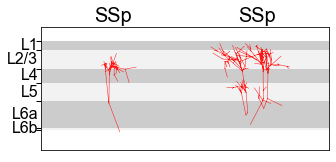

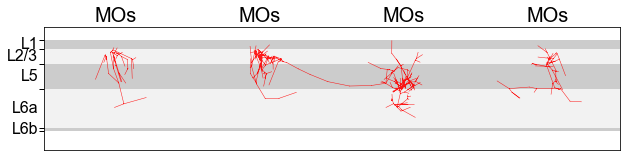

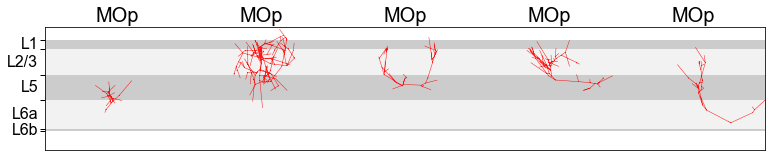

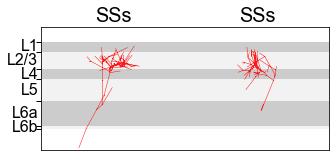

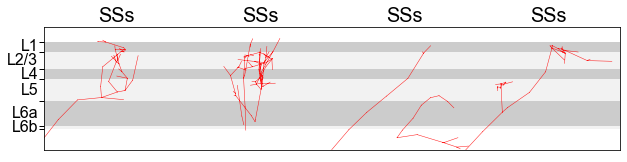

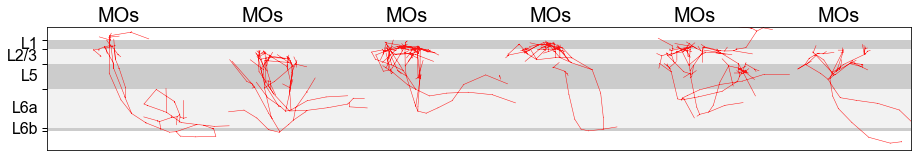

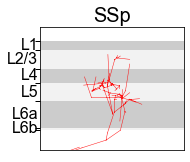

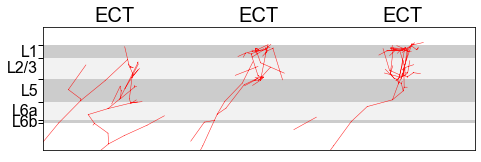

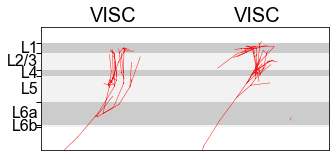

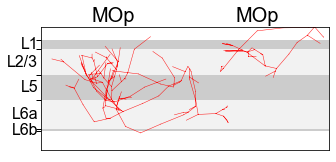

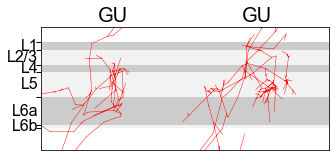

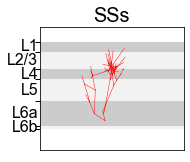

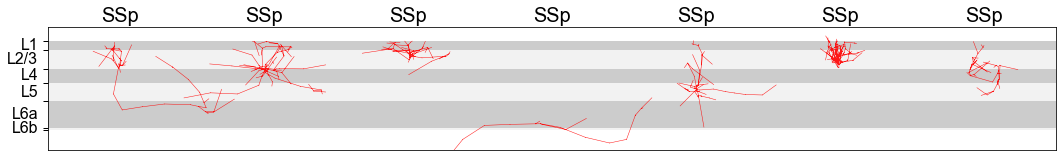

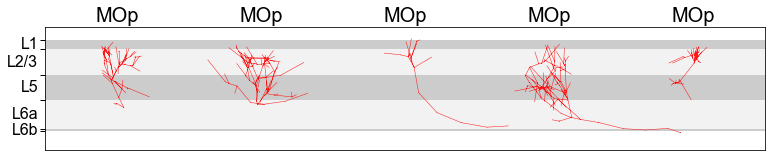

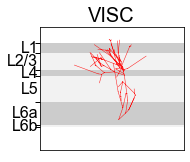

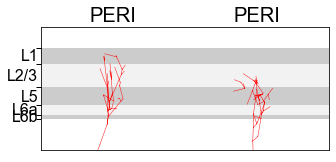

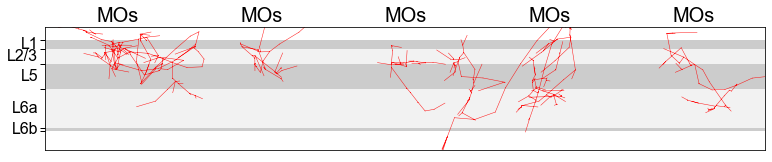

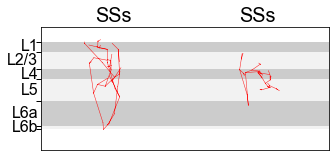

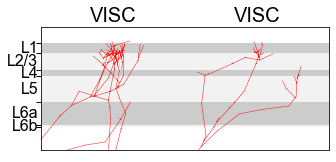

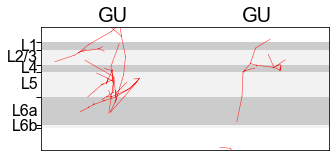

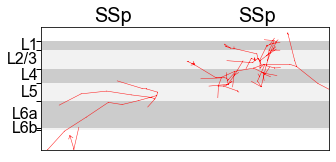

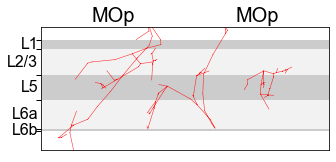

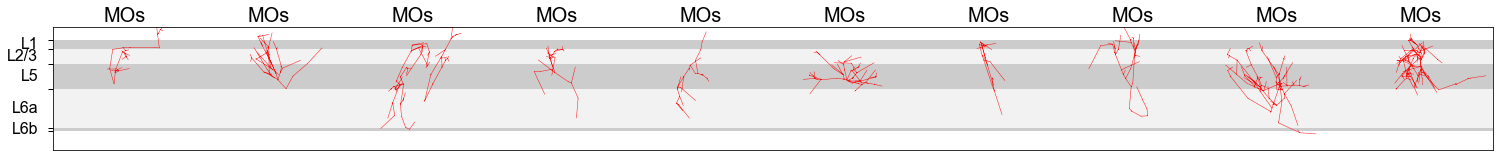

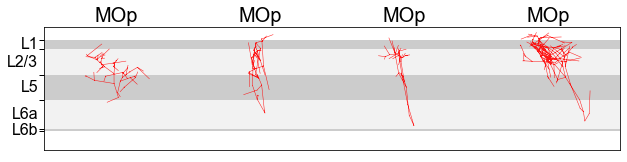

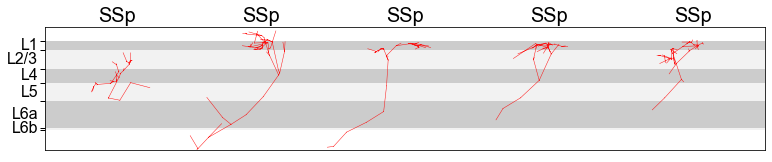

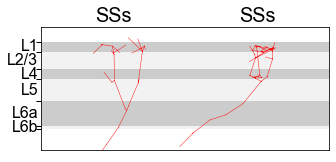

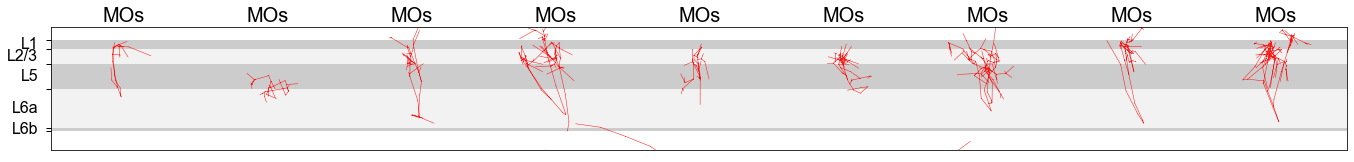

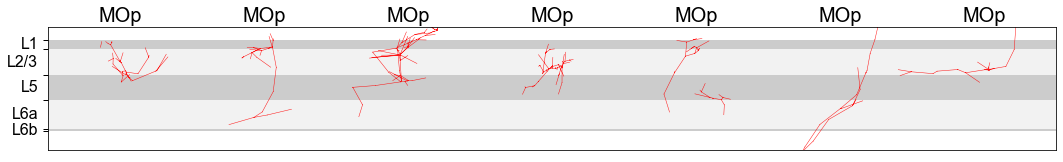

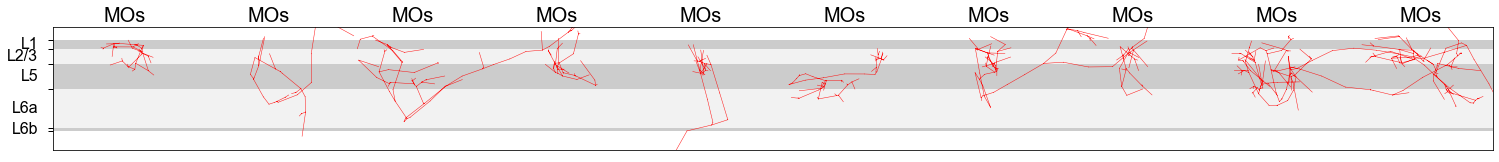

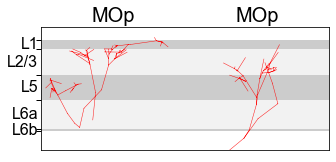

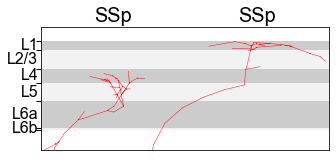

In [280]:
for ctype in rlist[:]:
    print(ctype)
    plot_distal_arbors(ctype)

In [253]:
fdf = None
outlier_ratio = []
blist = []
clist = []

for cname in arbor_list[:]:
    ca = arbor_dict[cname]
    tp = pd.DataFrame(ca.feature).transpose()
    if fdf is None:
        fdf = tp
    else:
        fdf = pd.concat([fdf, tp], axis=0)
    outlier_ratio.append(ca.outlier_ratio)
    blist.append(ca.n_branches)
    clist.append('_'.join(cname.split('_')[:-1]))
    
fdf.drop(columns=['volume'], inplace=True)
fdf.index = arbor_list
fdf['n_branch'] = blist
fdf['outlier_ratio'] = outlier_ratio
fdf['cell_id'] = clist
fdf = pd.concat([fdf, adf.loc[fdf.index, ['celltype', 'region', 'layer', 'hemisphere']]], axis=1)
fdf = pd.concat([fdf, dist_soma.loc[fdf.index, ['dist_soma']]], axis=1)

# Remove soma neighboring arbors and simple branches
fdf = fdf[((fdf.dist_soma>1000) & (fdf.n_branch>10))]
fdf['CellType_full'] = adf.loc[fdf.index, 'celltype_full'].tolist()
print("# arbors:\t%d" % len(fdf))
fdf.hemisphere.value_counts()

# arbors:	132


ipsi      86
contra    46
Name: hemisphere, dtype: int64

In [254]:
fdf

2d_x   2d_y   2d_area  total_length  \
17300_3426_x20339_y44872_0 -150.774645  122.0  0.969310  29125.331930   
17300_3426_x20339_y44872_2  283.165570  206.0  0.249409   8911.642990   
17300_3426_x20339_y44872_3 -121.487651   90.0  0.247635   7509.329935   
17300_3514_x19676_y45282_1  267.586356  226.0  0.189497   5294.111429   
17300_3514_x19676_y45282_2 -185.162144  126.0  0.417383  11343.835468   
...                                ...    ...       ...           ...   
191812_5922_x4572_y8645_3   -16.607699  166.0  0.418984  13830.437565   
191812_5219_x4127_y21100_1 -269.530628  266.0  0.291421   7088.834678   
191812_5676_x8072_y26215_2  -86.921407  234.0  0.606954  18312.754239   
191812_5676_x8072_y26215_3  -59.322476  266.0  0.185355   9403.458798   
191812_3176_x5144_y19229_2   80.056970  158.0  0.134452   6850.623326   

                                 radius  depth_mean   depth_std  n_branch  \
17300_3426_x20339_y44872_0   952.051525  395.154679  348.744708        62   
17300_3426_x20339_y44872_2   415.235717  482.215686  287.822923        19   
17300_3426_x20339_y44872_3   666.241172  517.939278  274.810736        20   
17300_3514_x19676_y45282_1   396.744394  516.283220  133.926947        20   
17300_3514_x19676_y45282_2  1146.870351  681.945368  304.005560        16   
...                                 ...         ...         ...       ...   
191812_5922_x4572_y8645_3    716.430208  489.824710  388.733312        31   
191812_5219_x4127_y21100_1   932.717293  422.433588  344.215853        16   
191812_5676_x8072_y26215_2   830.883542  371.180940  205.366206        54   
191812_5676_x8072_y26215_3   227.252662  272.914215  363.790185        37   
191812_3176_x5144_y19229_2   326.081283  639.155191  405.762339        14   

                            outlier_ratio                   cell_id celltype  \
17300_3426_x20339_y44872_0       7.831325  17300_3426_x20339_y44872      SSs   
17300_3426_x20339_y44872_2       0.000000  17300_3426_x20339_y44872      SSs   
17300_3426_x20339_y44872_3       2.000000  17300_3426_x20339_y44872      SSs   
17300_3514_x19676_y45282_1       0.000000  17300_3514_x19676_y45282      SSs   
17300_3514_x19676_y45282_2      15.789474  17300_3514_x19676_y45282      SSs   
...                                   ...                       ...      ...   
191812_5922_x4572_y8645_3        6.250000   191812_5922_x4572_y8645      SSp   
191812_5219_x4127_y21100_1       0.000000  191812_5219_x4127_y21100      SSp   
191812_5676_x8072_y26215_2       0.000000  191812_5676_x8072_y26215      SSs   
191812_5676_x8072_y26215_3       3.658537  191812_5676_x8072_y26215      SSs   
191812_3176_x5144_y19229_2       0.000000  191812_3176_x5144_y19229      MOs   

                            region layer hemisphere    dist_soma CellType_full  
17300_3426_x20339_y44872_0     MOs   2/3       ipsi  2684.008973     SSs-L5_IT  
17300_3426_x20339_y44872_2     SSs     5     contra  2957.028704     SSs-L5_IT  
17300_3426_x20339_y44872_3     MOs   2/3       ipsi  3660.772241     SSs-L5_IT  
17300_3514_x19676_y45282_1     SSs     4     contra  2236.204455     SSs-L5_IT  
17300_3514_x19676_y45282_2     MOp     5       ipsi  2662.150384     SSs-L5_IT  
...                            ...   ...        ...          ...           ...  
191812_5922_x4572_y8645_3      MOs     5       ipsi  3456.176917     SSp-L5_IT  
191812_5219_x4127_y21100_1     SSs   2/3       ipsi  3229.132959     SSp-L5_IT  
191812_5676_x8072_y26215_2     SSp   2/3       ipsi  3674.312623     SSs-L5_IT  
191812_5676_x8072_y26215_3  RSPagl     1       ipsi  4422.701522     SSs-L5_IT  
191812_3176_x5144_y19229_2     MOs   2/3     contra  5300.599894      MO-L5_IT  

[132 rows x 16 columns]

# cells: 76


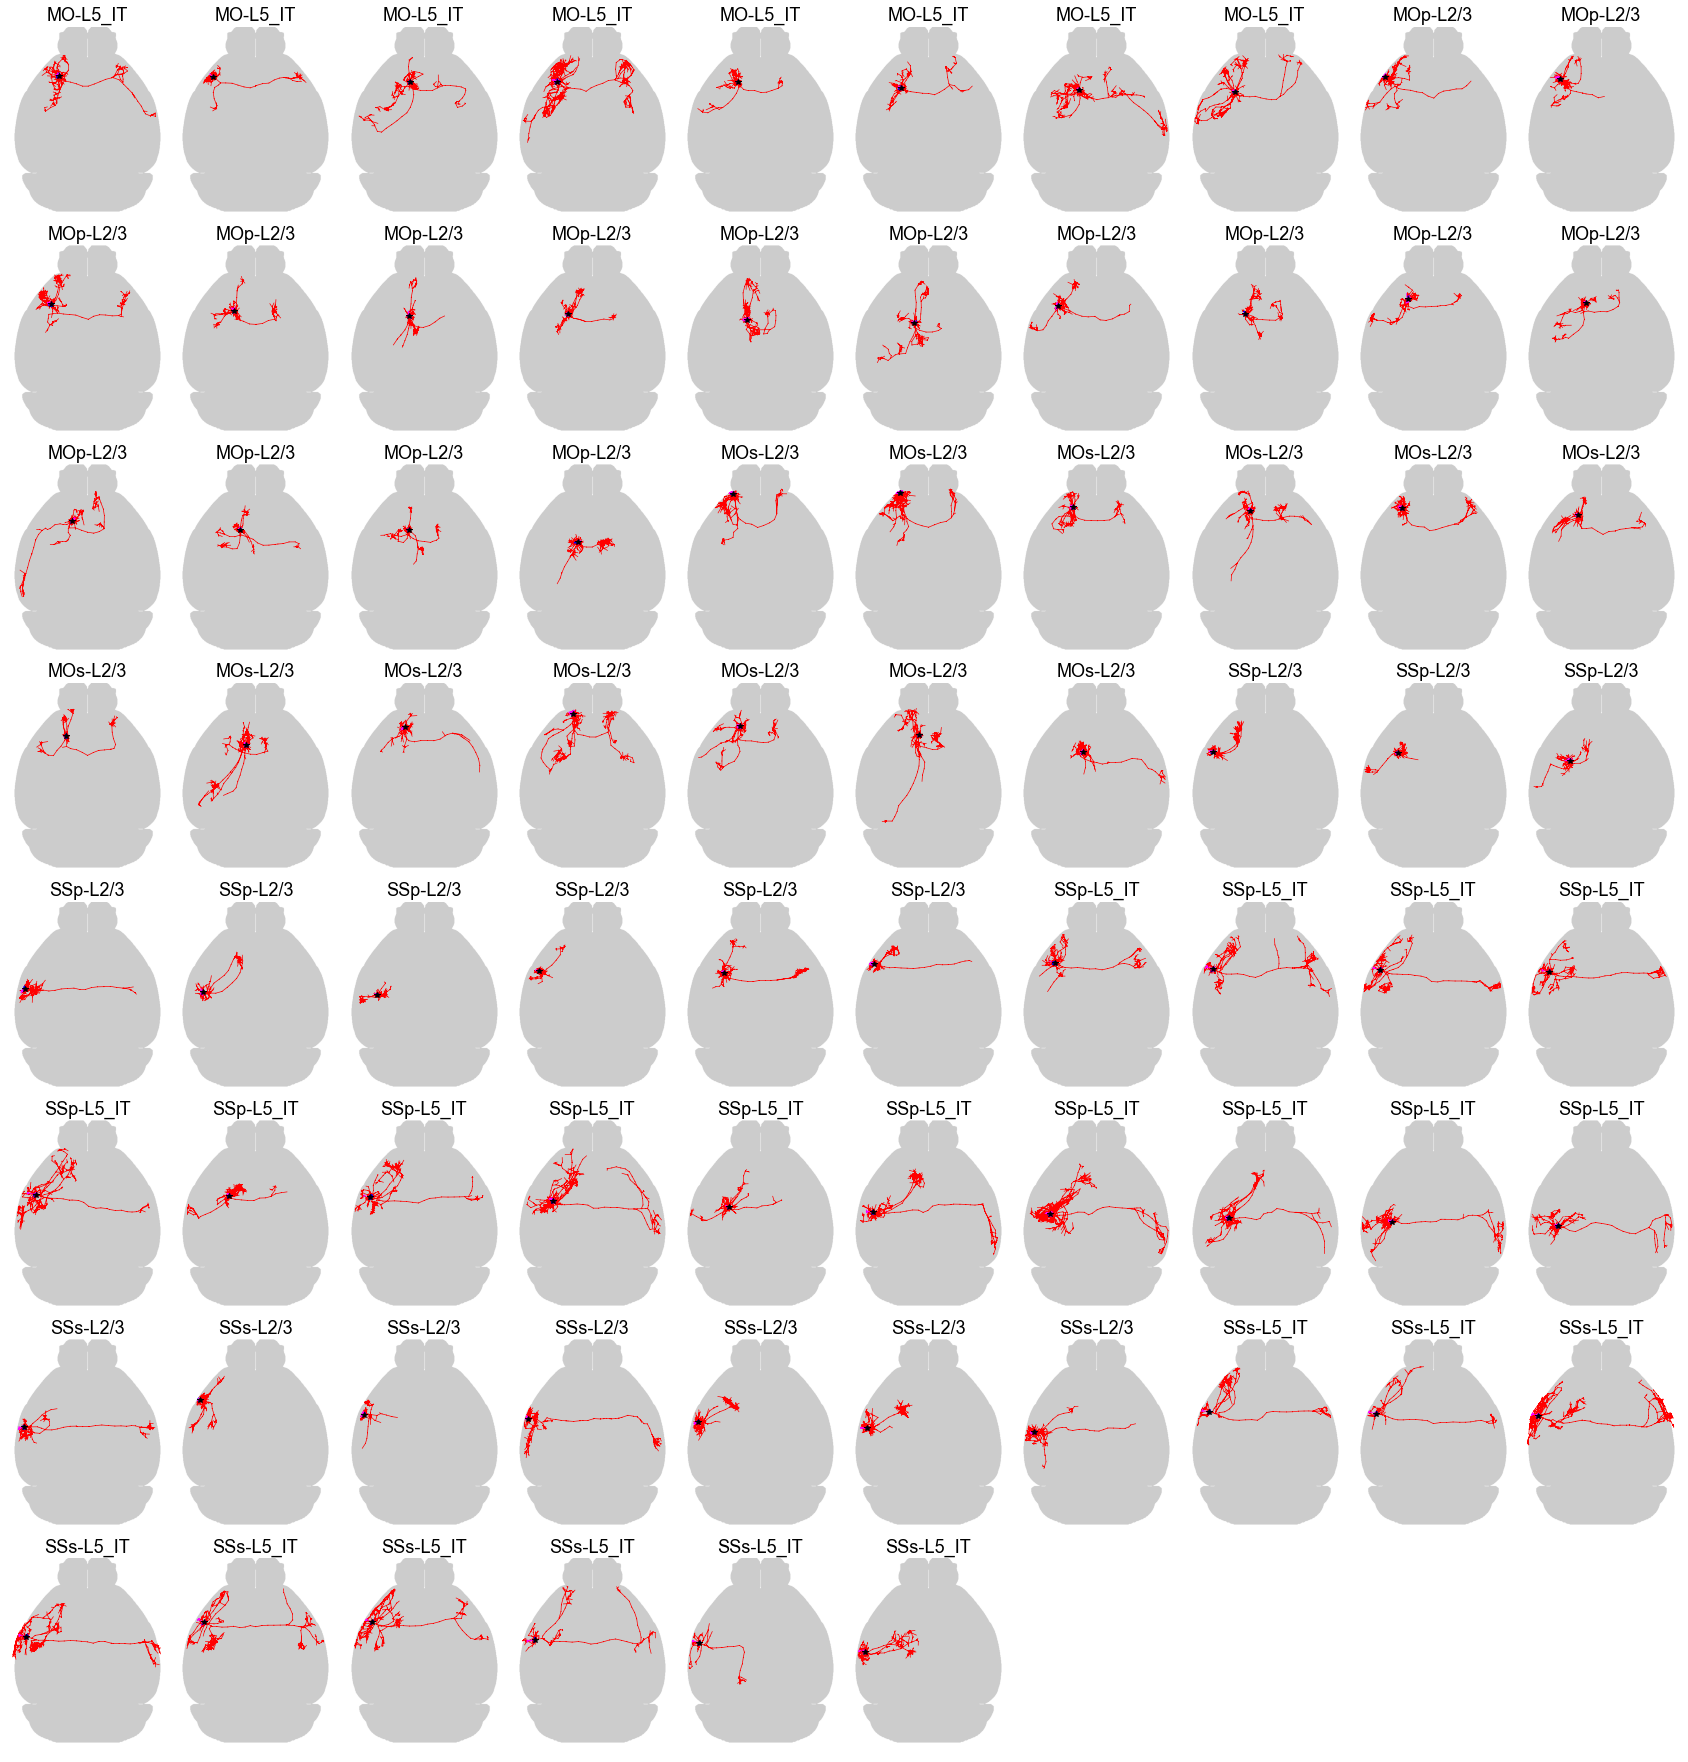

In [87]:
## Show neurons with long-projecting arbors
name_list = df.sort_values(['CellType_full', 'swc']).index.tolist()
name_list = [i for i in name_list if i in fdf.cell_id.tolist()]

ncol = 10
nrow = int(len(name_list)/ncol) + int((len(name_list)%ncol)>0)
fig, ax = plt.subplots(nrow, ncol, figsize=(3*ncol, 4*nrow), gridspec_kw={'wspace':0.05, 'hspace':0.05})
ax = ax.reshape(-1,)

print("# cells: %d" % (len(name_list)))
for i, cur_cell in enumerate(name_list[:]):    
    nmt.cell_in_map(neuron_dict, 
                [cur_cell], metadata, 
                ccf_annotation=nmt.annotation, 
                view="Horizontal", 
                alpha=1,
                ax=ax[i]
               )
    ax[i].set_title(df.loc[cur_cell, 'CellType_full'], fontdict={'fontsize':18})
    ax[i].axis('off')

for i in range(len(name_list), ncol*nrow):
    ax[i].axis('off')

# cells: 22


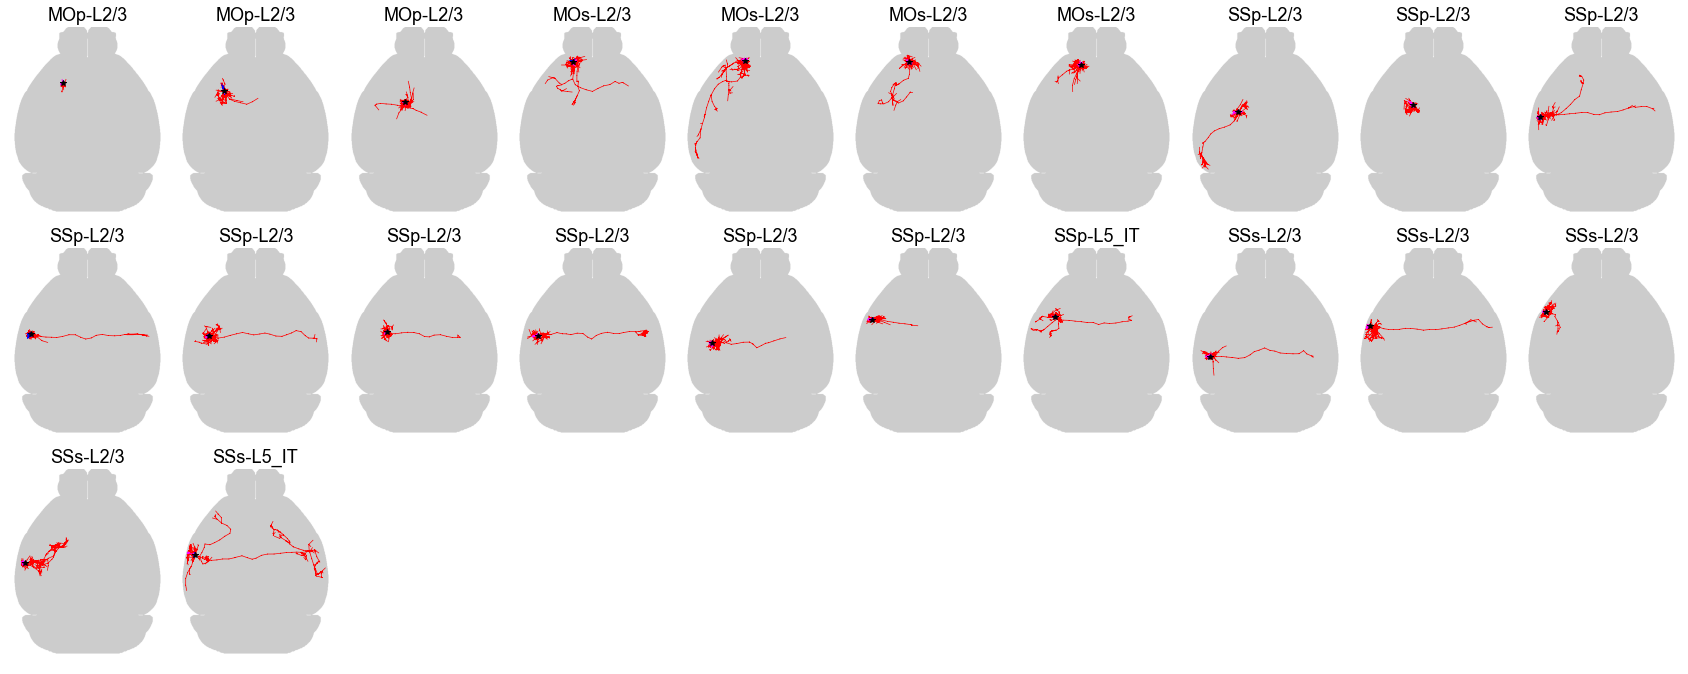

In [88]:
## Show neurons without long-projecting arbors
name_list = df.sort_values(['CellType_full', 'swc']).index.tolist()
name_list = [i for i in name_list if not i in fdf.cell_id.tolist()]

ncol = 10
nrow = int(len(name_list)/ncol) + int((len(name_list)%ncol)>0)
fig, ax = plt.subplots(nrow, ncol, figsize=(3*ncol, 4*nrow), gridspec_kw={'wspace':0.05, 'hspace':0.05})
ax = ax.reshape(-1,)

print("# cells: %d" % (len(name_list)))
for i, cur_cell in enumerate(name_list[:]):    
    nmt.cell_in_map(neuron_dict, 
                [cur_cell], metadata, 
                ccf_annotation=nmt.annotation, 
                view="Horizontal", 
                alpha=1,
                ax=ax[i]
               )
    ax[i].set_title(df.loc[cur_cell, 'CellType_full'], fontdict={'fontsize':18})
    ax[i].axis('off')

for i in range(len(name_list), ncol*nrow):
    ax[i].axis('off')

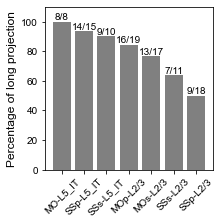

In [91]:
## What's the percentage of cells with long-cortical projections?
df['LongProjection'] = df.index.isin(fdf.cell_id)

lp_ratio = df.groupby('CellType_full')['LongProjection'].mean().sort_values(ascending=False)*100
lp_count = df[df.LongProjection]['CellType_full'].value_counts()
ct_count = df['CellType_full'].value_counts()
fig,ax = plt.subplots(1,1, figsize=(3,3))
xs = np.arange(len(lp_ratio))
tx = lp_ratio.index.tolist()
ax.bar(xs, lp_ratio, color='grey')
ax.set_xticks(xs)
ax.set_ylabel('Percentage of long projection', fontdict={'fontsize':12})
_ = ax.set_xticklabels(tx, fontdict={'ha':'center', 'rotation':45, 'fontsize':10})

for i in range(len(tx)):
    ctx = tx[i]
    ax.text(xs[i], lp_ratio[ctx], 
            ('%d/%d' % (lp_count[ctx], ct_count[ctx])),
            fontdict={'ha':'center', 'va':'bottom'}
           )
ax.set_ylim(0,110)

fig.savefig('../Figure/long_projection_ratio_L2-5_IT.pdf', bbox_inches='tight')

In [119]:
def get_depth_profile(cname_list, max_d=2000, nbins=100):
    bins = np.linspace(0, max_d, nbins+1, dtype=int)
    df_dp = pd.DataFrame(index=cname_list, columns=bins[:nbins])

    for cname in cname_list:
#         ct = pd.cut(arbor_dict[cname].depth.depth, bins, labels=bins[:nbins]).value_counts() / len(arbor_dict[cname].depth.depth)
#         df_dp.loc[cname] = ct.loc[df_dp.columns].tolist()
        tp = arbor_dict[cname].depth.copy()
        ct = pd.cut(arbor_dict[cname].depth.depth, bins, labels=bins[:nbins])
        tp['bin'] = ct[tp.index]
        df_dp.loc[cname] = tp.groupby('bin')['rho'].sum().tolist()/tp['rho'].sum()
#     df_dp = pd.DataFrame(df_dp.mean(axis=0), columns=['density'])
#     df_dp['depth'] = df_dp.index
    return df_dp
df_dp = get_depth_profile(fdf.index.tolist())

In [259]:
df_dp.shape

(132, 100)

In [93]:
tp = (df_dp * np.array(df_dp.columns.tolist()).reshape(1,-1)).sum(axis=1)
tp.sort_values(ascending=False).head()

cnamelist = tp[tp<1000].index.tolist()
df_dp = df_dp.loc[cnamelist]

In [122]:
adf.head()

cellname celltype celltype_full  \
17300_3426_x20339_y44872_0  17300_3426_x20339_y44872      SSs     SSs-L5_IT   
17300_3426_x20339_y44872_2  17300_3426_x20339_y44872      SSs     SSs-L5_IT   
17300_3426_x20339_y44872_3  17300_3426_x20339_y44872      SSs     SSs-L5_IT   
17300_3514_x19676_y45282_1  17300_3514_x19676_y45282      SSs     SSs-L5_IT   
17300_3514_x19676_y45282_2  17300_3514_x19676_y45282      SSs     SSs-L5_IT   

                           region layer hemisphere        length  
17300_3426_x20339_y44872_0    MOs   2/3       ipsi  29125.331930  
17300_3426_x20339_y44872_2    SSs     5     contra   8911.642990  
17300_3426_x20339_y44872_3    MOs   2/3       ipsi   7509.329935  
17300_3514_x19676_y45282_1    SSs     4     contra   5294.111429  
17300_3514_x19676_y45282_2    MOp     5       ipsi  11343.835468

# SSp-L2/3 cells:	12
Global
# SSp-L5_IT cells:	20
Global
# SSs-L2/3 cells:	11
Global
# SSs-L5_IT cells:	17
Global
# MOp-L2/3 cells:	32
Global
# MOs-L2/3 cells:	26
Global
# MO-L5_IT cells:	14
Global


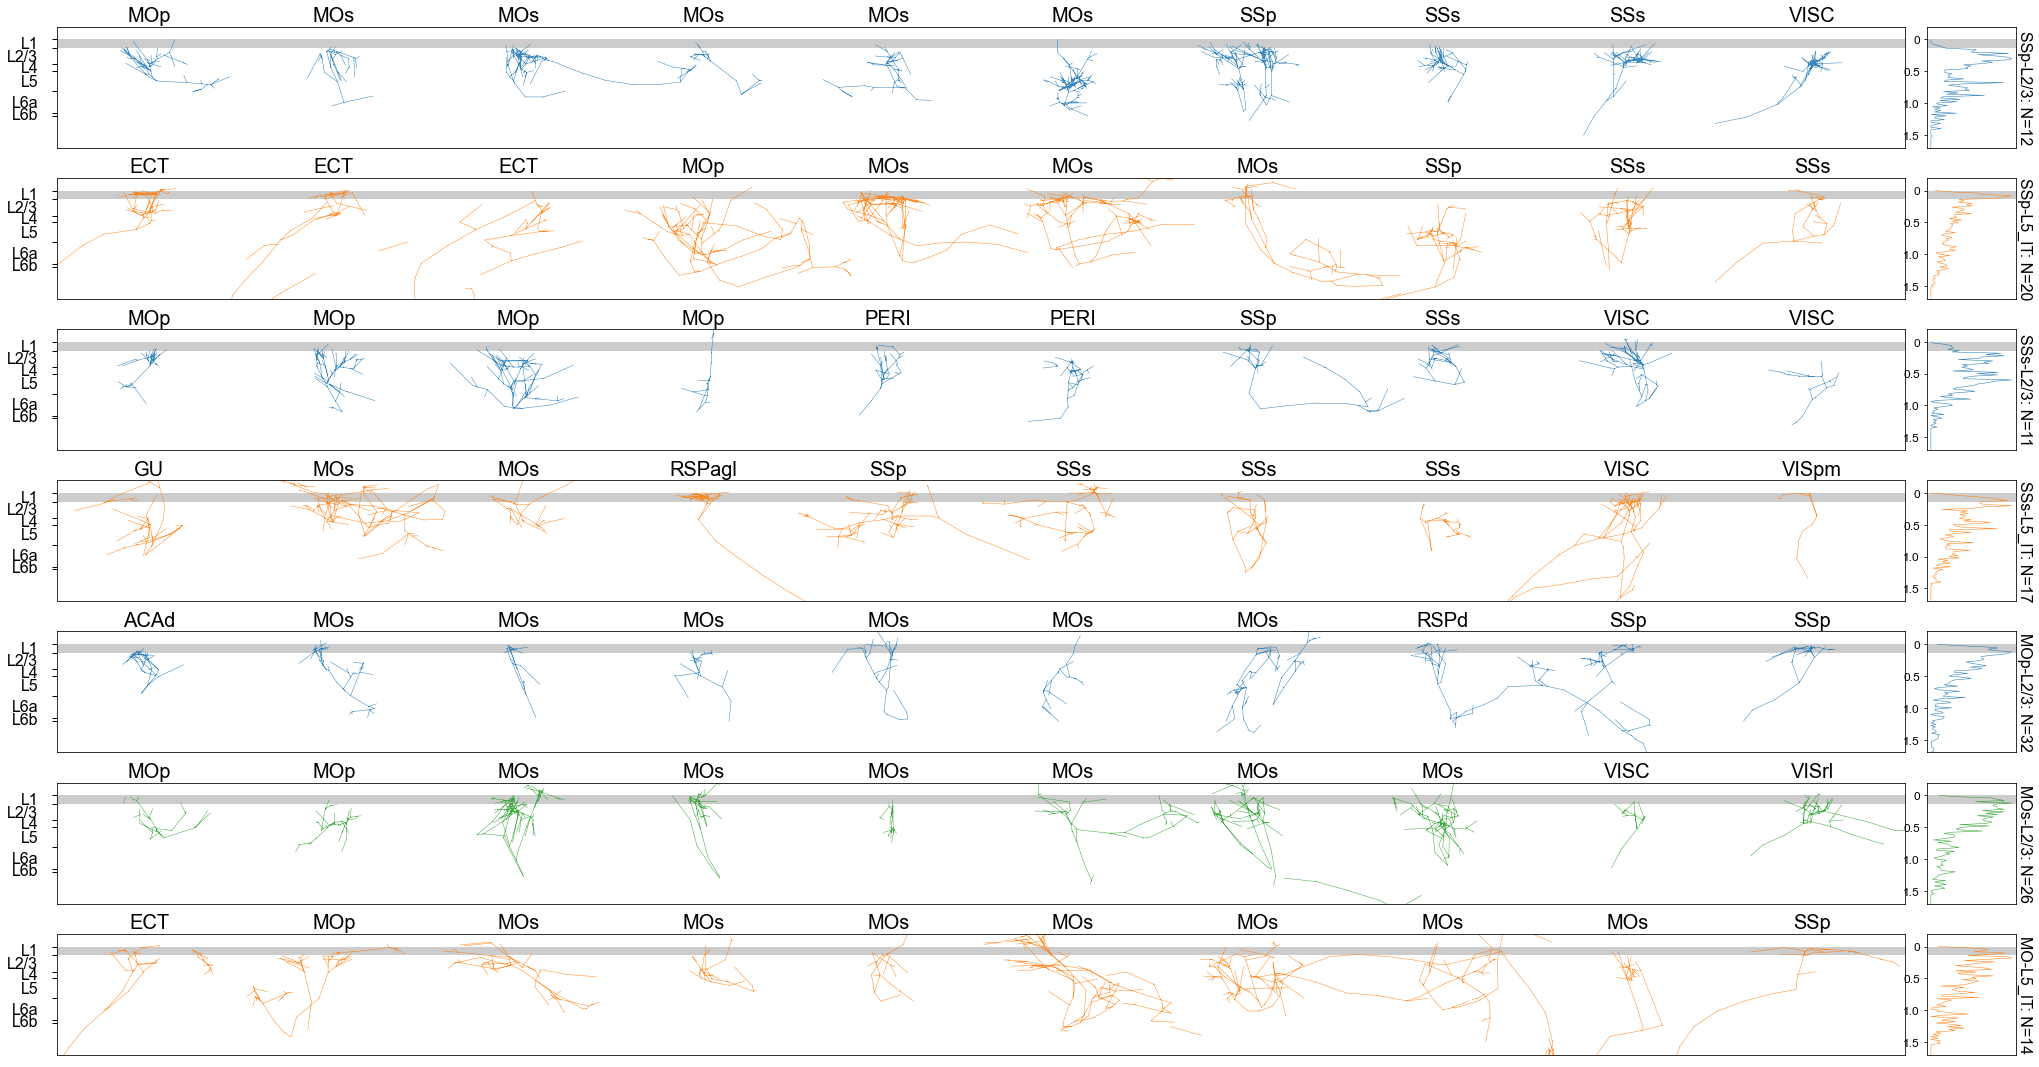

In [287]:
hue_dict = {'SSp-L2/3':'C0', 
            'SSp-L5_IT':'C1', 
            'SSs-L2/3':'C0', 
            'SSs-L5_IT':'C1', 
            'MOp-L2/3':'C0', 
            'MOs-L2/3':'C2', 
            'MO-L5_IT':'C1'}

nrow = len(rlist)
ncol=10

fig = plt.figure(figsize=(1.4*(ncol+1), 2.1*nrow))

for i,ctype in enumerate(rlist[:]):
    nlist = adf[adf['celltype_full']==ctype].index.tolist()
    nlist = [k for k in nlist if k in fdf.index]
    print('# %s cells:\t%d' % (ctype, len(nlist)))

    cregion = adf.loc[nlist].region.value_counts().index[0]
    ctag = ctype
    if not cregion in layer_thickness_dict.keys():
        print(i, ctype)
    max_depth = layer_thickness_dict[cregion].sum() + 200
        
    # Examples
    # for each type, plot 5 representative cases and profiles     
    snlist = sample_by_depth(nlist, fdf, ncol)
    snlist = fdf.loc[snlist].sort_values('region').index.tolist()

    cax = fig.add_axes([0, 1-(i+1)/nrow, 1/6*len(snlist), 1/nrow*0.8])
    plot_arbor_list(snlist, 'Global', 
                    x_shift=2500, ax=cax,
                    lw=0.5, 
                    arbor_name=False,
                    arbor_region=True,
                    color=hue_dict[ctype],
                    fontsize=20,
                    only_L1=True,
                   )
#     cax.set_title(ctag, fontdict={'fontsize':20})
    cax.set_ylim(1700, -200)

    # Profile
    for j,cntype in enumerate([2]):
        cax = fig.add_axes([len(snlist)/6+0.02+0.1*j, 1-(i+1)/nrow, 0.08, 1/nrow*0.8])
        cdp = get_depth_profile(nlist)
        cdp = pd.DataFrame(cdp.mean(axis=0), columns=['density'])
        cax.plot(cdp.density, cdp.index, lw=0.5, color=hue_dict[ctype])

        layer_shade('Global', cax, fontsize=0, only_L1=True, show_ticks=False)
        cax.invert_yaxis()
        cax.set_ylim(1700, -200)
        cax.set_xticks([])
        cax.set_yticks([0,500,1000,1500])
        cax.set_yticklabels([0,0.5,1.0,1.5], fontdict={'fontsize':12})
    cax.text(cax.get_xlim()[0]*(-0.1) + cax.get_xlim()[1]*1.1, 
             np.mean(cax.get_ylim()), 
             '%s: N=%d' % (ctype, len(nlist)),
             fontdict={'ha':'center', 
                       'va':'center', 
                       'rotation':270,
                       'fontsize':16
                      }
            )
fig.savefig('../Figure/L2-5_IT_vertical_profile_cluster_longprojection.pdf', bbox_inches='tight')

In [288]:
group_dict = {'SSp':['SSp-L2/3', 'SSp-L5_IT'], 
              'SSs':['SSs-L2/3', 'SSs-L5_IT'], 
              'MO':['MOp-L2/3', 'MOs-L2/3', 'MO-L5_IT']}
group_list = ['SSp', 'SSs', 'MO']

# SSp-L2/3 cells:	12
# SSp-L5_IT cells:	20
# SSs-L2/3 cells:	11
# SSs-L5_IT cells:	17
# MOp-L2/3 cells:	32
# MOs-L2/3 cells:	26
# MO-L5_IT cells:	14


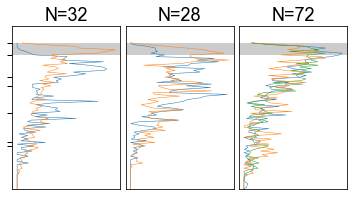

In [289]:
fig,ax = plt.subplots(1,3, figsize=(2*3, 3), gridspec_kw={'wspace':0.05})
ax = ax.reshape(-1,)

for i,cgroup in enumerate(group_list):
    cax = ax[i]
    gnlist = adf[adf['celltype_full'].isin(group_dict[cgroup])].index.tolist()
    gnlist = [k for k in gnlist if k in fdf.index]
    cregion = adf.loc[gnlist].region.value_counts().index[0]
    if not cregion in layer_thickness_dict.keys():
        print(i, cregion)
    max_depth = layer_thickness_dict[cregion].sum() + 200
    for j, ctype in enumerate(group_dict[cgroup]):
        nlist = adf[adf['celltype_full']==ctype].index.tolist()
        nlist = [k for k in nlist if k in fdf.index]
        print('# %s cells:\t%d' % (ctype, len(nlist)))
        
        # Profile        
        cdp = get_depth_profile(nlist)
        cdp = pd.DataFrame(cdp.mean(axis=0), columns=['density'])
        cax.plot(cdp.density, cdp.index, lw=0.5, color=hue_dict[ctype])

    if i==0:
        layer_shade('Global', cax, fontsize=0, only_L1=True, show_ticks=True)
    else:
        layer_shade('Global', cax, fontsize=0, only_L1=True, show_ticks=False)
        cax.set_yticks([])
    cax.invert_yaxis()
    cax.set_ylim(1500+200, -200)
    cax.set_xticks([])
#     cax.set_yticks([])
#     cax.set_title(cgroup, fontdict={'fontsize':14})
    cax.text(np.mean(cax.get_xlim()), 
             cax.get_ylim()[0]*(-0.06) + cax.get_ylim()[1]*1.06, 
             ('N=%d' % (len(gnlist))),
             fontdict={'ha':'center', 
                       'va':'center', 
                       'rotation':0,
                       'fontsize':18
                      }
            )
fig.savefig('../Figure/L2-5_IT_distal_arbor_distribution.pdf', bbox_inches='tight')

In [237]:
rdict = {'SSp': ['SSp-L2/3', 'SSp-L5_IT'],
 'SSs': ['SSs-L2/3', 'SSs-L5_IT'],
 'MO': ['MOp-L2/3', 'MOs-L2/3', 'MO-L5_IT']}

hue_dict = {'SSp-L2/3':'C0', 
            'SSp-L5_IT':'C1', 
            'SSs-L2/3':'C0', 
            'SSs-L5_IT':'C1', 
            'MOp-L2/3':'C0', 
            'MOs-L2/3':'C2', 
            'MO-L5_IT':'C1'}

group_hue = {'SSp':['C0', 'C1'],
             'SSs':['C0', 'C1'],
             'MO':['C0', 'C2', 'C1']
            }

In [257]:
from scipy.stats import mannwhitneyu
ct_pairs = [['SSp-L2/3', 'SSp-L5_IT'],
            ['SSs-L2/3', 'SSs-L5_IT'], 
            ['MOp-L2/3', 'MOs-L2/3'],
            ['MOp-L2/3', 'MO-L5_IT'],
            ['MOs-L2/3', 'MO-L5_IT'],
           ]
def get_pv(measure):
    print(measure)
    for cpair in ct_pairs:
        ct1 = cpair[0]
        ct2 = cpair[1]
        _, pv = mannwhitneyu(fdf[fdf['CellType_full']==ct1][measure],
                             fdf[fdf['CellType_full']==ct2][measure]
                            )
        print('%s : %s\t%.2e' % (ct1, ct2, pv))
    return

measure_list = ['2d_area']
for measure in measure_list:
    get_pv(measure)

2d_area
SSp-L2/3 : SSp-L5_IT	2.39e-03
SSs-L2/3 : SSs-L5_IT	4.09e-02
MOp-L2/3 : MOs-L2/3	4.78e-01
MOp-L2/3 : MO-L5_IT	6.78e-02
MOs-L2/3 : MO-L5_IT	7.21e-02


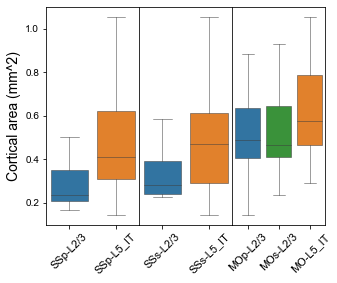

In [255]:
fig,ax = plt.subplots(1,3,figsize=(5,4), sharey=False)
plt.subplots_adjust(wspace=0)
ax = ax.reshape(-1,)
for i,cgroup in enumerate(['SSp', 'SSs', 'MO']):
    clist = adf[adf['celltype_full'].isin(rdict[cgroup])].index.tolist()
    pdata = fdf[fdf.index.isin(clist)].copy()
#     pdata['CellType_full'] = adf.loc[pdata.index.tolist(), 'celltype_full'].tolist()
    cax = ax[i]
    sns.boxplot(x='CellType_full', 
                y='2d_area', 
#                 hue='Layer',
                palette=group_hue[cgroup],
                order=rdict[cgroup], 
                data = pdata, 
                ax=cax, 
                linewidth=0.5,
                showfliers=False)
    cax.set_xlabel('')
    if i>0:
        cax.set_ylabel('')
        cax.set_yticks([])
    else:
        cax.set_ylabel('Cortical area (mm^2)', fontdict={'fontsize':14})
#     cax.set_ylim(20,220)
    cax.set_xticklabels(rdict[cgroup], fontdict={'rotation':45, 'fontsize':11})
    
fig.savefig('../Figure/IT_comparison_2d_area.pdf', bbox_inches='tight')

## Clustering analysis

In [94]:
def my_confusion_matrix(y_true, y_pred, normalize='pred'):
    y_true = y_true.copy()
    y_pred = y_pred.loc[y_true.index].copy()
    df = pd.DataFrame({'true':y_true, 'pred':y_pred}, index=y_true.index)
    utrue = sorted(list(set(y_true.tolist())))
    upred = sorted(list(set(y_pred.tolist())))
    res = pd.DataFrame(0, index=upred, columns=utrue)
    for i in upred:
        for j in utrue:
            res.loc[i,j] = len(df[((df['pred']==i) & (df['true']==j))])
    if normalize=='pred':
        res = res / np.array(res.sum(axis=1)).reshape(-1,1)
    if normalize=='true':
        res = res / np.array(res.sum(axis=0)).reshape(1,-1)
    res = res.round(2)
    return res



/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



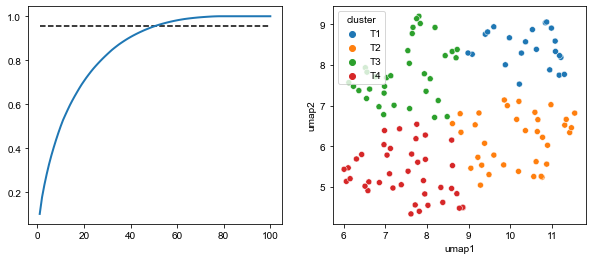

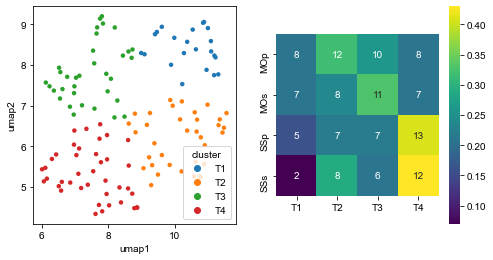

In [95]:
def my_kmeans_depth(df, features=None, k=3, n_neighbors=5, tag='T'):
    if features is None:
        features = df.columns.tolist()
    cdf = df[features].copy()
    cdf = sklearn.preprocessing.scale(cdf, axis=0)
    pca = PCA()
    pca.fit(cdf)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    ax[0].plot(np.arange(1, pca.n_components_ + 1),
               cumsum, 
               '-', linewidth=2)
    n_pc = pca.n_components_
    for i in range(pca.n_components_):
        if cumsum[i]>0.95:
            n_pc = i+1
            break
    ax[0].hlines(cumsum[n_pc-1], xmin=1, xmax=pca.n_components_, linestyle='dashed')
    cdf = cdf[:,:n_pc]
    cdf = pd.DataFrame(cdf, index=df.index)

    zmap = umap.UMAP(n_neighbors=n_neighbors, random_state=0)
    zdf = zmap.fit_transform(cdf)
    zdf = pd.DataFrame({'umap1':zdf[:,0],
                        'umap2':zdf[:,1],
                       }, index=df.index)
    zdf['depth_mean'] = (df * np.array(df.columns.tolist()).reshape(1,-1)).sum(axis=1)

    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(zdf[['umap1', 'umap2']])
    zdf['cluster'] = [tag+str(i) for i in kmeans.labels_]
#     return 1,zdf,1
    # Sort cluster id by depth
    l1 = zdf.groupby('cluster')['depth_mean'].mean().sort_values().index.tolist()
    l2 = [tag+str(i+1) for i in range(k)]
    re_cluster = dict(zip(l1, l2))
    zdf['cluster'] = zdf['cluster'].map(re_cluster)
    ucluster = sorted(list(set(zdf.cluster.tolist())))
    sns.scatterplot('umap1', 'umap2', hue='cluster', hue_order=ucluster, data=zdf)
    return cdf, zdf, ucluster

cdf, zdf, ucluster = my_kmeans_depth(df_dp, k=4, n_neighbors=5)

# Confusion matrix
zdf['celltype'] = adf.loc[zdf.index, 'celltype']
zdf['region'] = adf.loc[zdf.index, 'region']
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.scatterplot('umap1', 'umap2', 
                hue='cluster', hue_order=ucluster, 
                linewidth=0, s=20,
                data=zdf, ax=ax[0])

conf_matrix = my_confusion_matrix(zdf.celltype, zdf.cluster, normalize='true').transpose()
count_matrix = my_confusion_matrix(zdf.celltype, zdf.cluster, normalize=None).transpose()
sns.heatmap(conf_matrix, cmap='viridis', annot=count_matrix, fmt='.0f', ax=ax[1], square=True)

fig.savefig('../Figure/axon_classification_L2-5_IT_umap_longprojection.pdf', bbox_inches='tight')


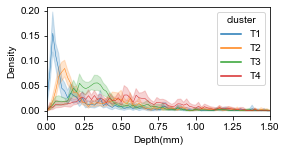

In [96]:
dp_plot = pd.DataFrame(columns=['Depth', 'Density', 'Arbor'])
sname_list = df_dp.index.tolist()
sdepth_list = df_dp.columns.tolist()

deplist = sdepth_list*len(sname_list)
denslist = []
alist = []
for i in sname_list:
    denslist = denslist + df_dp.loc[i].tolist()
    alist = alist + [i]*len(sdepth_list)
    
dp_plot = pd.DataFrame({'Depth':deplist,
                        'Density':denslist,
                        'Arbor':alist
                       })
dp_plot['Celltype'] = [adf.loc[i, 'celltype'] for i in alist]
dp_plot['Layer'] = [adf.loc[i, 'celltype'] for i in alist]
dp_plot['cluster'] = [zdf.loc[i, 'cluster'] for i in alist]
dp_plot['Depth'] = dp_plot['Depth']/1000
dp_plot.head()

fig, ax = plt.subplots(1,1,figsize=(4,2))
sns.lineplot(x="Depth", y="Density",
             hue="cluster",
             hue_order=ucluster,
             ax=ax,
             linewidth=0.5,
             data=dp_plot)

ax.set_xlim(0, 1.5)
# ax.yaxis.tick_right()
# xt = [str(np.round(i,2)) for i in ax.get_xticks()]
# yt = [str(np.round(i,2)) for i in ax.get_yticks()]
# ax.set_xticklabels(xt, fontdict={'rotation':90})
# ax.set_yticklabels(yt, fontdict={'rotation':90})
ax.set_xlabel('Depth(mm)', fontdict={'rotation':0})
fig.savefig('../Figure/depth_prof_L2-5_IT_longprojection.pdf', bbox_inches='tight')

In [148]:
def sample_by_depth(nlist, sdf, n_sample=5):
    sdf = sdf.loc[nlist].copy()
    sdf = sdf.sort_values(['depth_mean'])
    nlist = sdf.index.tolist()
    if len(nlist)<=n_sample:
        return nlist
    step = int(len(nlist)/n_sample)
    begin = int(step/2)
    res = [nlist[begin+i*step] for i in range(n_sample)]
    return res


# T1 cells:	22
MOs
# T2 cells:	35
MOs
# T3 cells:	34
MOs
# T4 cells:	40
MOs


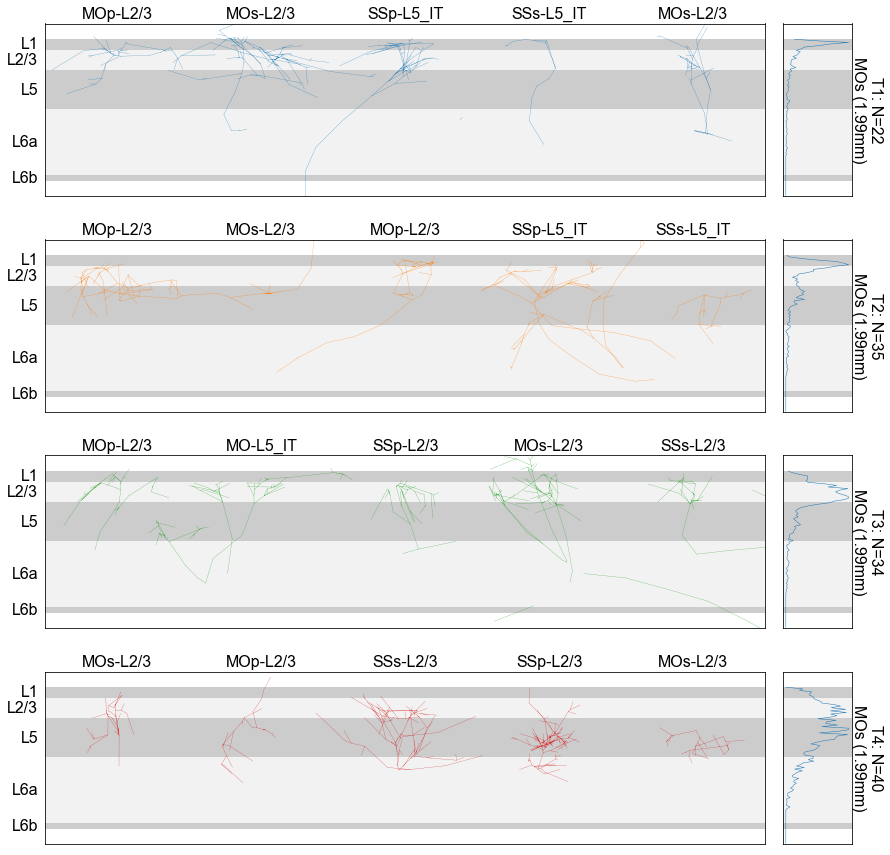

In [104]:
nrow = len(ucluster)
ncol=5

fig = plt.figure(figsize=(2*(ncol+1), 3*nrow))

for i in range(nrow)[:]:
    ccluster = ucluster[i]
    nlist = zdf[zdf.cluster==ccluster].index.tolist()
    print('# %s cells:\t%d' % (ccluster, len(nlist)))

    ctype = zdf.loc[nlist].region.value_counts().index[0]
    ctag = ccluster
    if not ctype in layer_thickness_dict.keys():
        print(i, ccluster)
    max_depth = layer_thickness_dict[ctype].sum() + 200
        
    # Examples
    # for each type, plot 5 representative cases and profiles     
    snlist = sample_by_depth(nlist, fdf, ncol)

    cax = fig.add_axes([0, 1-(i+1)/nrow, 1/6*len(snlist), 1/nrow*0.8])
    plot_arbor_list(snlist, ctype, 
                    x_shift=1500, ax=cax,
                    lw=0.25, 
                    arbor_name=False,
                    arbor_type=True,
                    color='C'+str(i),
                    fontsize=16,
                   )
#     cax.set_title(ctag, fontdict={'fontsize':20})
    cax.set_ylim(max_depth, -200)

    # Profile

    for j,cntype in enumerate([2]):
        cax = fig.add_axes([len(snlist)/6+0.02+0.1*j, 1-(i+1)/nrow, 0.08, 1/nrow*0.8])
        cdp = get_depth_profile(nlist)
        cdp = pd.DataFrame(cdp.mean(axis=0), columns=['density'])
        cax.plot(cdp.density, cdp.index, lw=0.5, color='C'+str(j))

        layer_shade(ctype, cax, fontsize=0)
        cax.invert_yaxis()
        cax.set_ylim(max_depth, -200)
        cax.set_xticks([])
        cax.set_yticks([])
    cax.text(cax.get_xlim()[0]*(-0.22) + cax.get_xlim()[1]*1.22, 
             np.mean(cax.get_ylim()), 
             ('%s: N=%d\n%s (%s)' % (ccluster, len(nlist), ctype, str(np.round(max_depth/1000,2))+'mm')),
             fontdict={'ha':'center', 
                       'va':'center', 
                       'rotation':270,
                       'fontsize':16
                      }
            )
fig.savefig('../Figure/L2-4_IT_vertical_profile_cluster_longprojection.pdf', bbox_inches='tight')

In [326]:
zdf.to_excel('./TargetArbor_classification.xlsx')

## Deprecated from here

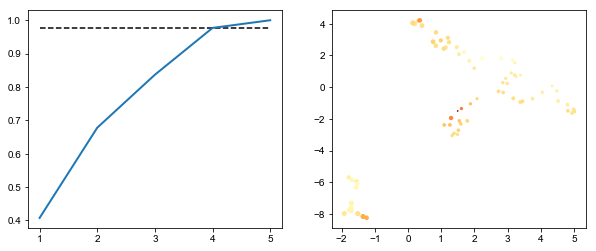

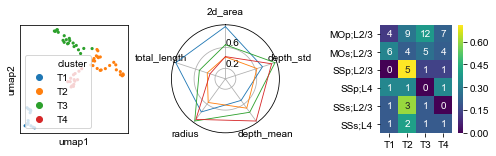

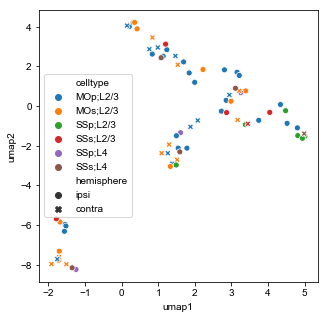

In [321]:
sfeatures = [
#             '2d_x',
#              '2d_y',
             '2d_area',
             'total_length',
             'radius',
             'depth_mean',
             'depth_std',
#              'n_branch'
            ]

def my_kmeans(df, features, k=3, n_neighbors=5, tag='T'):
    cdf = df[features].copy()
    cdf = sklearn.preprocessing.scale(cdf, axis=0)
    pca = PCA()
    pca.fit(cdf)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    ax[0].plot(np.arange(1, pca.n_components_ + 1),
               cumsum, 
               '-', linewidth=2)
    n_pc = pca.n_components_
    for i in range(pca.n_components_):
        if cumsum[i]>0.95:
            n_pc = i+1
            break
    ax[0].hlines(cumsum[n_pc-1], xmin=1, xmax=pca.n_components_, linestyle='dashed')
    cdf = cdf[:,:n_pc]
    cdf = pd.DataFrame(cdf, index=df.index)

    zmap = umap.UMAP(n_neighbors=n_neighbors, random_state=0)
    zdf = zmap.fit_transform(cdf)
    zdf = pd.DataFrame({'umap1':zdf[:,0],
                        'umap2':zdf[:,1],
                       }, index=df.index)

    zdf = pd.concat([df, zdf], axis=1)
    ax[1].scatter(zdf.umap1, zdf.umap2, s=zdf['2d_area']*25, c=zdf['depth_mean'], cmap='YlOrRd')

    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=0).fit(zdf[['umap1', 'umap2']])
    zdf['cluster'] = [tag+str(i+1) for i in kmeans.labels_]
#     return 1,zdf,1
    # Sort cluster id by depth
    l1 = zdf.groupby('cluster')['depth_mean'].mean().sort_values().index.tolist()
    l2 = [tag+str(i+1) for i in range(k)]
    re_cluster = dict(zip(l1, l2))
    zdf['cluster'] = zdf['cluster'].map(re_cluster)
    ucluster = sorted(list(set(zdf.cluster.tolist())))
    return cdf, zdf, ucluster

def show_clusters(zdf, fdf, ucluster, features):
    zdf = zdf.copy()
    df = fdf.loc[zdf.index].copy()
    fig = plt.figure(figsize=(6,2))
    ax1 = fig.add_axes([0.1,0.1,0.25,0.75])
    sns.scatterplot('umap1', 'umap2', hue='cluster', hue_order=ucluster, 
                    data=zdf, palette='tab10', 
#                     legend=False,  
                    linewidth=0,
                    ax=ax1, s=10)
    ax1.set_xticks([])
    ax1.set_yticks([])
#     ax1.set_title(celltype)

    # Confusion matrix
    ax2 = fig.add_axes([0.9,0.1,0.25,0.75])
    conf_matrix = my_confusion_matrix(zdf.celltype, zdf.cluster, normalize='true').transpose()
    count_matrix = my_confusion_matrix(zdf.celltype, zdf.cluster, normalize=None).transpose()
    sns.heatmap(conf_matrix, cmap='viridis', annot=count_matrix, fmt='.0f', ax=ax2, square=True)

#     sns.scatterplot(x='umap1',
#                 y='umap2',
#                 style='layer',
#                 style_order=['2/3', '4'],
#                 hue='region',
#                 hue_order=selected_region,
#                 data=zdf,
#                 ax=ax2
#                )
    
    # Polygon plot
    ax3 = fig.add_axes([0.45,0.1,0.25,0.75], projection='polar')
    fdf = pd.DataFrame(columns=ucluster, index=features)
    if '2d_x' in features:
        df['2d_x'] = df['2d_x'].abs()
    for i, cc in enumerate(ucluster):
        clist = zdf[zdf.cluster==cc].index.tolist()
        fdf[cc] = df.loc[clist, features].median(axis=0)
    fdf = fdf / np.array(fdf.max(axis=1)).reshape(-1,1)
    theta = np.linspace(0, 2*np.pi, len(features)+1)
    
    for i,cc in enumerate(ucluster):
        ax3.plot(theta, fdf[cc].tolist()+[fdf[cc].iloc[0]], c=palette[i], lw=0.85)
    ax3.set_rgrids(np.arange(0.2,1.0,0.4))
    ax3.set_rlabel_position(0)
    ax3.set_thetagrids(theta[:-1]/np.pi*180, features)
    ax3.set_theta_zero_location('N')
#     fig.savefig('../Figure/axon_classification_L2-4_IT_umap.pdf', bbox_inches='tight')
#     sns.pairplot(zdf[features+['cluster']], hue='cluster', palette='tab10')
    return fig, ax3

# Show representative types
def get_centers(df, labels, cid=0, ncase=5):
    df = df[labels==cid]
    distance = metrics.pairwise_distances(df)
    distance = pd.DataFrame(np.mean(distance, axis=0), index=df.index, columns=['d'])
    distance = distance.sort_values(['d'])
    return distance.index[:ncase].tolist()

def sample_by_depth(nlist, sdf, n_sample=5):
    sdf = sdf.loc[nlist].copy()
    sdf = sdf.sort_values(['depth_mean'])
    nlist = sdf.index.tolist()
    if len(nlist)<=n_sample:
        return nlist
    step = int(len(nlist)/n_sample)
    begin = int(step/2)
    res = [nlist[begin+i*step] for i in range(n_sample)]
    return res

def plot_examples(cdf, zdf, ucluster, 
                  df_dp,
                  n_example=5, x_shift=1000):
    n_row = len(ucluster)
    width1 = .8*n_example
    width2 = 1.2
    height = 1.6*n_row
    fig = plt.figure(figsize=(width1+width2, height))
    for i,cc in enumerate(ucluster):
        cname_list = zdf[zdf.cluster==cc].index.tolist()
        region = zdf.region.value_counts().index[0]
        cname_list = get_centers(cdf, zdf.cluster, cc, n_example)
        ax1 = fig.add_axes([0.1,1-(i+1)/n_row,width1/(width1+width2)-0.1,1/n_row*.85])
        # 1. Show 5 representative cases
        plot_arbor_list(cname_list, 
                        region, 
                        arbor_name=False,
                        arbor_type=True,
                        ax=ax1, 
#                         color=palette[i], 
                        x_shift=x_shift, 
                        fontsize=10,
                        lw=0.2
                       )
        plt.axis('off')
        
        # 2. Show profile
        ax2 = fig.add_axes([width1/(width1+width2)+0.02,1-(i+1)/n_row,width2/(width1+width2)-0.14,1/n_row*.85], 
                           sharey=ax1)

        cdp = df_dp.loc[zdf[zdf.cluster==cc].index]
        cdp = pd.DataFrame(cdp.mean(axis=0), columns=['density'])
        ax2.plot(cdp.density, cdp.index, c=palette[i], lw=0.5)
        layer_shade(region, ax2, fontsize=0)
        plt.axis('off')
        
        # Show percentage
        cxmax = ax2.get_xlim()[1]
        cymin = 0
        cymax = layer_thickness_dict[region].sum()
        ax2.text(cxmax*1.05, cymax/2, ('%d (%.1f%%)' % ((zdf.cluster==cc).sum(),
                                                        (zdf.cluster==cc).mean()*100
                                                       )),
                 fontdict={'ha':'left', 'va':'center', 'fontsize':14, 'rotation':270})
        
        if i == (len(ucluster)-1):
            ax1.hlines(1300, xmin=x_shift*(n_example-1.25), xmax=x_shift*(n_example-1.25)+500)
            ax1.text(x_shift*(n_example-1.05), 1300, '0.5mm', 
                     fontdict={'ha':'center', 'va':'bottom', 'fontsize':14})
#             ax1.text(ax1.get_xlim()[1]/2, 
#                      cymax*1.05, 
#                      'cortical thickness = '+str(np.round(cymax/1000,2))+'mm',
#                      fontdict={'ha':'center', 'va':'top', 'fontsize':14, 'rotation':0}) 
        if i == 1:
            ax2.text(ax2.get_xlim()[1]*1.95, cymax/2, str(np.round(cymax/1000,2))+'mm',
                     fontdict={'ha':'left', 'va':'center', 'fontsize':14, 'rotation':270})
#     fig.savefig('../Figure/axon_classification_'+celltype+'.pdf')
    return fig


cfdf = fdf.copy()
cdf, zdf, ucluster = my_kmeans(cfdf, sfeatures, k=4, n_neighbors=5)
# zdf = pd.concat([zdf, adf.loc[zdf.index, ['region', 'layer', 'hemisphere']]], axis=1)

show_clusters(zdf, cfdf, ucluster, sfeatures)

fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.scatterplot('umap1', 'umap2', 
#                 hue='cluster', hue_order=ucluster, 
                hue='celltype', hue_order=selected_celltype, 
                style='hemisphere',
                data=zdf, ax=ax)

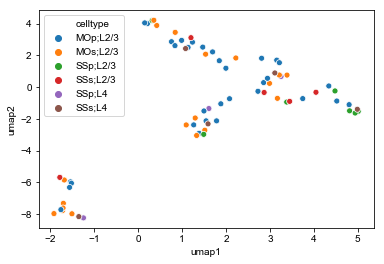

In [259]:
# sns.scatterplot('umap1', 'umap2', hue='2d_x', palette='bwr', data=zdf)
# sns.scatterplot('umap1', 'umap2', hue='hemisphere', palette='bwr', data=zdf)
sns.scatterplot('umap1', 'umap2', hue='celltype', hue_order=selected_celltype, palette='tab10', data=zdf)

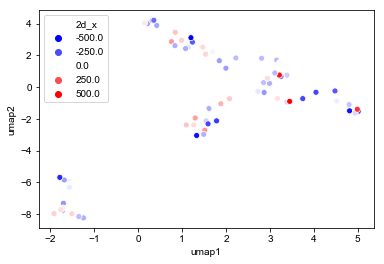

In [260]:
sns.scatterplot('umap1', 'umap2', hue='2d_x', palette='bwr', data=zdf)

# T1 cells:	22
MOs
# T2 cells:	35
MOs
# T3 cells:	34
MOs
# T4 cells:	40
MOs


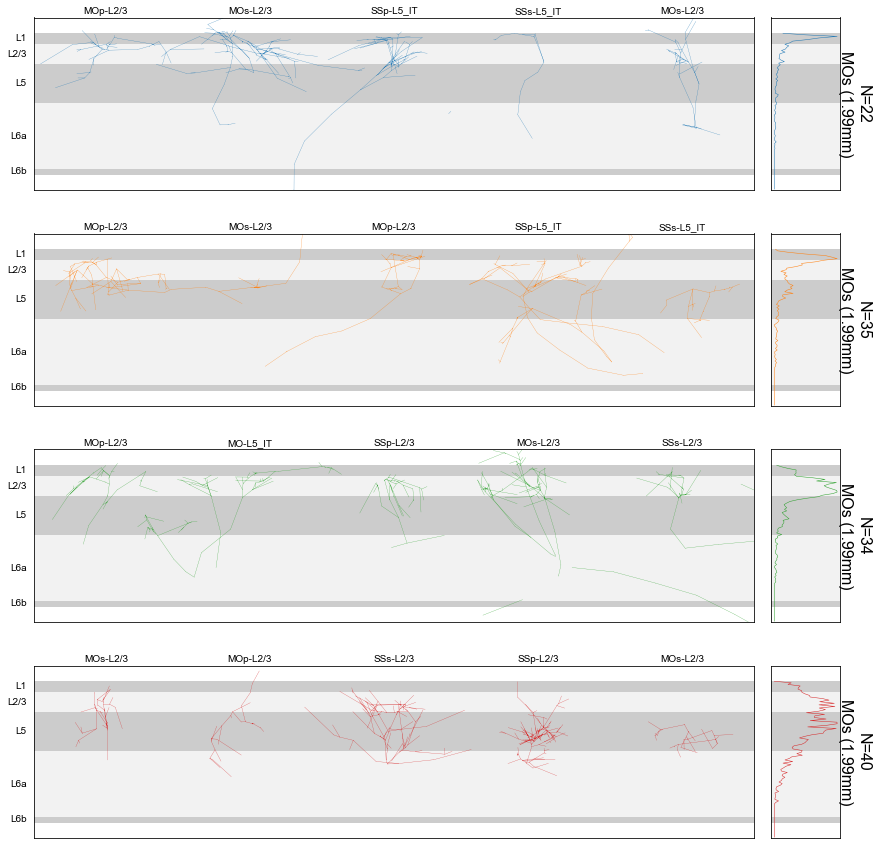

In [102]:
nrow = len(ucluster)
ncol=5

fig = plt.figure(figsize=(2*(ncol+1), 3*nrow))

for i in range(nrow)[:]:
    ccluster = ucluster[i]
    nlist = zdf[zdf.cluster==ccluster].index.tolist()
    print('# %s cells:\t%d' % (ccluster, len(nlist)))

    ctype = zdf.loc[nlist].region.value_counts().index[0]
    ctag = ccluster
    if not ctype in layer_thickness_dict.keys():
        print(i, ccluster)
    max_depth = layer_thickness_dict[ctype].sum() + 200
        
    # Examples
    # for each type, plot 5 representative cases and profiles     
    snlist = sample_by_depth(nlist, fdf, ncol)

    cax = fig.add_axes([0, 1-(i+1)/nrow, 1/6*len(snlist), 1/nrow*0.8])
    plot_arbor_list(snlist, ctype, 
                    x_shift=1500, ax=cax,
                    lw=0.25, 
                    arbor_name=False,
                    arbor_type=True,
                    color='C'+str(i),
                    fontsize=10,
                   )
#     cax.set_title(ctag, fontdict={'fontsize':20})
    cax.set_ylim(max_depth, -200)

    # Profile

    for j,cntype in enumerate([2]):
        cax = fig.add_axes([len(snlist)/6+0.02+0.1*j, 1-(i+1)/nrow, 0.08, 1/nrow*0.8])
        cdp = get_depth_profile(nlist)
        cdp = pd.DataFrame(cdp.mean(axis=0), columns=['density'])
        cax.plot(cdp.density, cdp.index, lw=0.5, color='C'+str(i))

        layer_shade(ctype, cax, fontsize=0)
        cax.invert_yaxis()
        cax.set_ylim(max_depth, -200)
        cax.set_xticks([])
        cax.set_yticks([])
    cax.text(cax.get_xlim()[0]*(-0.2) + cax.get_xlim()[1]*1.2, 
             np.mean(cax.get_ylim()), 
             ('N=%d\n%s (%s)' % (len(nlist), ctype, str(np.round(max_depth/1000,2))+'mm')),
             fontdict={'ha':'center', 
                       'va':'center', 
                       'rotation':270,
                       'fontsize':16
                      }
            )
# fig.savefig('../Figure/L2-4_IT_vertical_profile_cluster.pdf', bbox_inches='tight')

In [ ]:
arbor_type = pd.DataFrame(columns=['cluster'])

for ct in ctlist[:]:
    zdf = celltype_clustering(df, ct, k=3)
    tp = pd.DataFrame({'cluster':[ct+'_'+i[1:] for i in zdf.cluster.tolist()]
                      }, index=zdf.index)
    arbor_type = pd.concat([arbor_type, tp], axis=0)
    
arbor_type['cell_id'] = ['_'.join(i.split('_')[:-1]) for i in arbor_type.index.tolist()]
arbor_type['celltype'] = [arbor_dict[i].celltype for i in arbor_type.index.tolist()]

## Cross type comparison

In [303]:
pdf = df[df.celltype.isin(ctlist)].copy()
pdf['cluster'] = arbor_type.loc[pdf.index, 'cluster']
pdf['cluster'] = ['c'+i.split('_')[-1] for i in pdf['cluster'].tolist()]

pdf = pdf[pdf.cluster=]

2d_x   2d_y   2d_area  total_length      radius  \
17302_00020_0  166.369727  170.0  0.173744   4957.054929  162.190857   
17302_00020_1  162.732591  166.0  0.129513  25691.970951  143.549130   
17302_00021_1  150.247309  166.0  0.272043   5187.732282  288.794867   
17302_00021_3  172.282367  162.0  0.163315  15218.633076  159.442360   
17302_00035_0  250.944842  314.0  0.192013  17315.155671  158.040249   

                depth_mean   depth_std  outlier_ratio celltype      cell_id  \
17302_00020_0  1006.396177  125.682706       1.470588      VPL  17302_00020   
17302_00020_1   475.285023  113.060565       0.000000      VPL  17302_00020   
17302_00021_1  1034.122892  154.482018       2.777778      VPL  17302_00021   
17302_00021_3   540.914190  183.601516       0.000000      VPL  17302_00021   
17302_00035_0   356.120227  130.317126       0.387597       MG  17302_00035   

              region cluster  
17302_00020_0    MOp      c2  
17302_00020_1    MOp      c0  
17302_00021_1    MOp      c2  
17302_00021_3  SSp-m      c0  
17302_00035_0   AUDp      c0

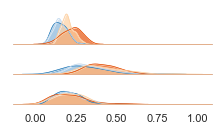

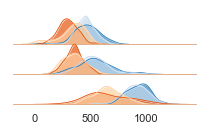

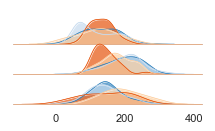

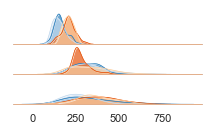

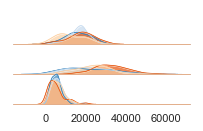

In [388]:
def cross_type_feature_compare(ctlist, pal, cfeature):
    pdf = pd.DataFrame(columns=df.columns)
    for ctype in ctlist:
        pdf = pd.concat([pdf, df[df.celltype==ctype].copy()], axis=0)
    pdf['cluster'] = arbor_type.loc[pdf.index, 'cluster']
    pdf['cluster'] = ['Type'+i.split('_')[-1] for i in pdf['cluster'].tolist()]
    pdf = pdf.sort_values(['cluster'])

    # Initialize the FacetGrid object
    # pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

    g = sns.FacetGrid(pdf, hue="celltype", row="cluster", aspect=5, height=.7, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, cfeature, clip=(0, np.max(pdf[cfeature])), shade=True, alpha=0.7, lw=0.5)
    g.map(sns.kdeplot, cfeature, clip=(0, np.max(pdf[cfeature])),  lw=.75)
    g.map(plt.axhline, y=0, lw=.5, clip_on=False)


    # # Define and use a simple function to label the plot in axes coordinates
    # def label(x, color, label):
    #     ax = plt.gca()
    #     ax.text(0, .2, label, fontweight="bold", color=color,
    #             ha="left", va="center", transform=ax.transAxes)

    # g.map(label, "2d_area", color='k')

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.05)

    # Remove axes details that don't play well with overlap
    g.set_titles('')
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
#     g.set(xlim=(0,0.8))
#     for i in range(len(g.axes)):
#         print(g.axes[i,0].get_ylim())
    g.savefig('../Figure/compare_arbor_feature_'+cfeature+'.pdf', bbox_inches='tight')
    return

pal = sns.palettes.color_palette('tab20c')[0:1] + sns.palettes.color_palette('tab20c')[3:4] + sns.palettes.color_palette('tab20c')[4:5] + sns.palettes.color_palette('tab20c')[7:8]
cross_type_feature_compare(ctlist[:4], pal, '2d_area')
cross_type_feature_compare(ctlist[:4], pal, 'depth_mean')
cross_type_feature_compare(ctlist[:4], pal, 'depth_std')
cross_type_feature_compare(ctlist[:4], pal, 'radius')
cross_type_feature_compare(ctlist[:4], pal, 'total_length')

## Typical and extreme cases

In [115]:
ctype = 'VPM'
def get_cat(ctype, plot=False):
    '''
    Get arbor type dataframe for the given celltype
    '''
    cregion = rgdict[ctype]

    cat = arbor_type.copy()
    cat = cat[cat.celltype==ctype]
    cucluster = sorted(list(set(cat.cluster.tolist())))
    cat.cluster = pd.Categorical(cat.cluster, categories=cucluster)
    cmap.update(dict(zip(cucluster, palette[:len(cucluster)])))
    
    if plot:
        # Plot
        alist = cat.index.tolist()
        n_arbor = len(alist)
        colors = [cmap[i] for i in cat['cluster'].tolist()]
        print('# arbors:\t%d' % (n_arbor))
    
        ncol =10
        nrow = int(n_arbor/ncol) + int((n_arbor % ncol)!=0)
        fig, ax = plt.subplots(nrow,1, figsize=(2*ncol, 3*nrow))

        for i in range(nrow):
            imin = i*10
            imax = min((i+1)*10, n_arbor)
            plot_arbor_list(alist[imin:imax], cregion, color=colors[imin:imax], lw=0.5, ax=ax[i])

        fig.savefig('./temp/arbors_'+ctype+'.pdf', bbox_inches='tight')
    return cucluster, cat

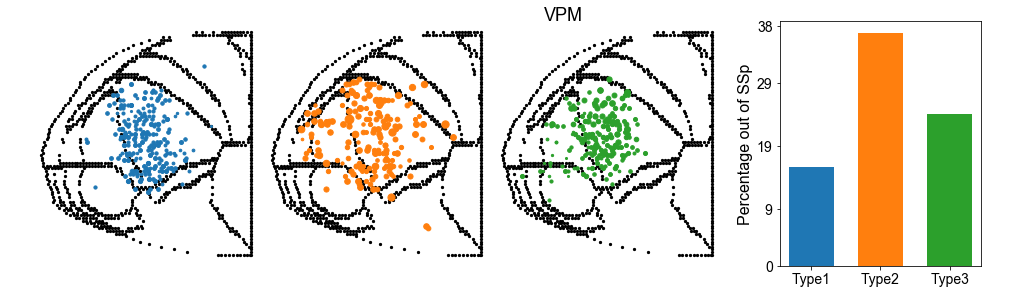

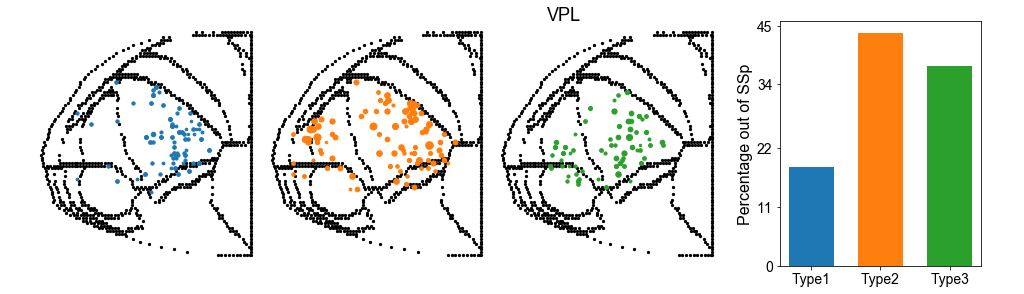

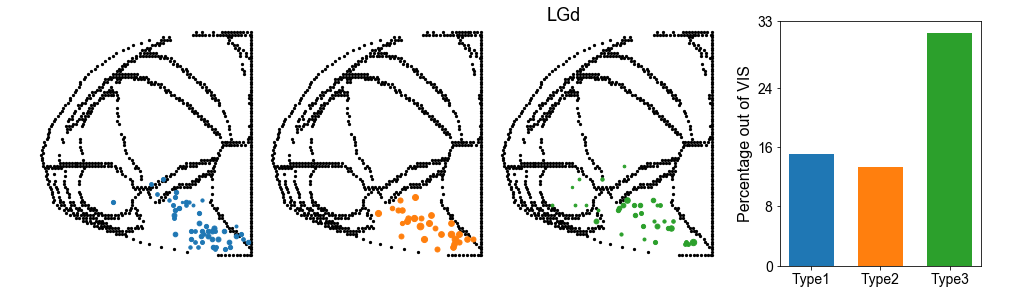

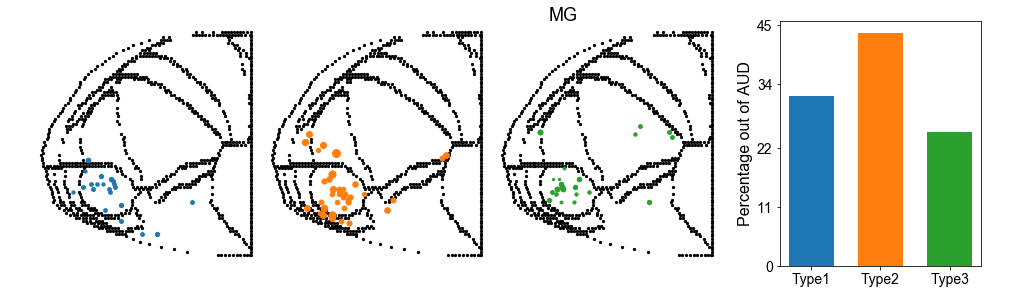

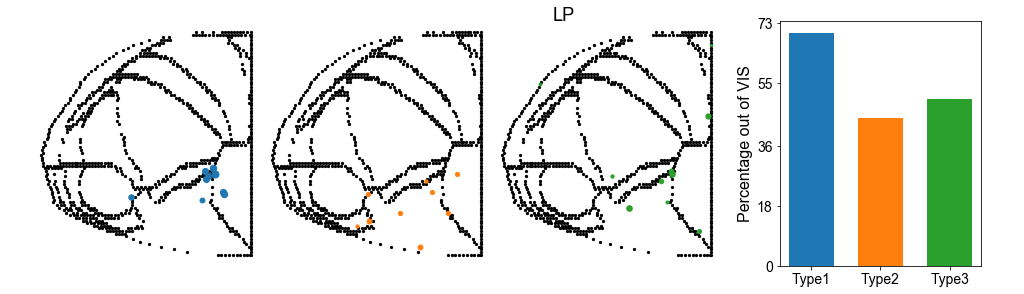

In [285]:
for ctype in ctlist[:]:
    cucluster, cat = get_cat(ctype)
    fig, ax = plt.subplots(1,1, figsize=(16,4))
    ax.axis('off')
    ax.set_title(ctype, fontdict={'size':18})
    
    # Ratio of projecting to expected region
    crglist = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id(rgdict[ctype])]
    non_target = []
    
    for i, cc in enumerate(cucluster[:3]):
        cax = fig.add_axes((0.05+i*0.2, 0.05, 0.2, 0.85))
        cax.scatter(anchor_df[anchor_df.is_boundary].z_expand, 
               anchor_df[anchor_df.is_boundary].x,
               c='k', s=5
              )

        clist = cat[cat.cluster==cc].index.tolist()
        non_target.append(100-df.loc[clist, 'region'].isin(crglist).mean()*100)
        for i,cname in enumerate(clist):
            cax.scatter(arbor_dict[cname].feature['2d_x'],
                       arbor_dict[cname].feature['2d_y'],
                       s=arbor_dict[cname].feature['2d_area']*75,
    #                    s=arbor_dict[cname].feature['depth_std']/10,
                       c=[cmap[cc]]
                      )
        cax.invert_yaxis()
        cax.axis('off')
    cax = fig.add_axes((.7, 0.05, 0.175, 0.85))
    xs = np.arange(3)
    cax.bar(xs, non_target, width=0.65, color=np.array([cmap[i] for i in cucluster[:3]]))
    cax.set_xticks(xs)
    cax.set_xticklabels(cucluster)
    cax.set_ylabel('Percentage out of '+rgdict[ctype], fontdict={'fontsize':16})
    cax.set_xticks(xs)
    cax.set_xticklabels(['Type'+str(i) for i in range(1,4)], fontdict={'fontsize':14, 'rotation':0})
    ys = np.linspace(0,cax.get_ylim()[1],5, dtype=int)
    cax.set_yticks(ys)
    cax.set_yticklabels(ys, fontdict={'fontsize':14})

    fig.savefig('../Figure/arbor_type_flatmap'+ctype+'.pdf', bbox_inches='tight')

58.1% non-SSp arbors project to SSs
38.4% non-SSp arbors project to SSs


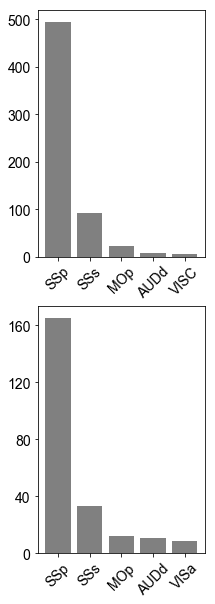

In [256]:
'''
Seems some VPM/VPL neurons send their clusters to SSs. 
Does it come with an cluster pair in the SSp?
'''

crglist = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('SSp')]

fig, ax = plt.subplots(2,1, figsize=(3, 10))

ctype = 'VPM'
cucluster, cat = get_cat(ctype)
cat['region'] = df.loc[cat.index, 'region']
cat.loc[cat.region.isin(crglist), ['region']] = 'SSp'
cat.region.map(select_region_dict)
print('%.1f%% non-SSp arbors project to SSs' % (len(cat[cat.region=='SSs']) / len(cat[~cat.region.isin(crglist)]) * 100))
ct = cat['region'].value_counts()[:5]
xs = np.arange(len(ct))
ax[0].bar(xs, ct, color='grey')
ax[0].set_xticks(xs)
ax[0].set_xticklabels(ct.index.tolist(), fontdict={'fontsize':14, 'rotation':45})
ys = np.linspace(0,500,6, dtype=int)
ax[0].set_yticks(ys)
ax[0].set_yticklabels(ys, fontdict={'fontsize':14})


ctype = 'VPL'
cucluster, cat = get_cat(ctype)
cat['region'] = df.loc[cat.index, 'region']
cat.loc[cat.region.isin(crglist), ['region']] = 'SSp'
print('%.1f%% non-SSp arbors project to SSs' % (len(cat[cat.region=='SSs']) / len(cat[~cat.region.isin(crglist)]) * 100))
ct = cat['region'].value_counts()[:5]
xs = np.arange(len(ct))
ax[1].bar(xs, ct, color='grey')
ax[1].set_xticks(xs)
ax[1].set_xticklabels(ct.index.tolist(), fontdict={'fontsize':14, 'rotation':45})
ys = np.linspace(0,160,5, dtype=int)
ax[1].set_yticks(ys)
ax[1].set_yticklabels(ys, fontdict={'fontsize':14})

fig.savefig('../Figure/arbor_location_TH.pdf', bbox_inches='tight')

In [278]:
ctype = 'VPL'
cucluster, cat = get_cat(ctype)
cat['region'] = df.loc[cat.index, 'region']
cat.loc[cat.region.isin(crglist), ['region']] = 'SSp'
cat.region.map(select_region_dict)

clist = list(set(cat.cell_id.tolist()))
res = pd.DataFrame(columns=cat.columns)
ct = 0
for cname in clist:
    tp = cat[cat.cell_id==cname]
    if len(tp)==1:
        continue
    if (('SSs' in tp.region.tolist()) & ('SSp' in tp.region.tolist())):
        res = pd.concat([res, tp], axis=0)
        ct += 1
print('# SSs + SSp:\t%.2f' % (ct/len(clist)*100))
res['total_length'] = df.loc[res.index, 'total_length']
res.sort_values(['cell_id', 'total_length'])

# VPM: 18454_00136

# SSs + SSp:	15.44


cluster      cell_id celltype region  total_length
17545_00084_2   VPL_0  17545_00084      VPL    SSp  10439.946071
17545_00084_0   VPL_1  17545_00084      VPL    SSs  35584.112818
18454_00140_2   VPL_2  18454_00140      VPL    SSp   6259.817293
18454_00140_0   VPL_0  18454_00140      VPL    SSs  17718.578786
18454_00157_2   VPL_1  18454_00157      VPL    SSs  12830.103413
18454_00157_0   VPL_1  18454_00157      VPL    SSp  24848.737566
18454_00159_3   VPL_1  18454_00159      VPL    SSp   3253.338704
18454_00159_1   VPL_1  18454_00159      VPL    SSp  11748.945793
18454_00159_0   VPL_1  18454_00159      VPL    SSs  30060.951204
18454_00164_2   VPL_2  18454_00164      VPL    SSs   5602.076563
18454_00164_0   VPL_1  18454_00164      VPL    SSp  27292.366276
18454_00165_2   VPL_1  18454_00165      VPL    SSs  13107.076771
18454_00165_1   VPL_1  18454_00165      VPL    SSp  50920.989012
18454_00167_0   VPL_2  18454_00167      VPL    SSs   5260.021611
18454_00167_1   VPL_1  18454_00167      VPL    SSp  19467.879503
18454_01134_3   VPL_2  18454_01134      VPL    SSs   5905.562429
18454_01134_1   VPL_1  18454_01134      VPL    SSp  31284.902881
18455_00152_2   VPL_2  18455_00152      VPL    SSs   3497.826359
18455_00152_0   VPL_0  18455_00152      VPL    SSp  24506.575126
18457_00072_0   VPL_2  18457_00072      VPL    SSs   3733.727024
18457_00072_1   VPL_1  18457_00072      VPL    SSp  18267.031009
18457_00073_3   VPL_2  18457_00073      VPL    SSs   4980.213441
18457_00073_0   VPL_1  18457_00073      VPL    SSp  19771.024354
18457_00089_3   VPL_2  18457_00089      VPL    SSs   2405.420083
18457_00089_0   VPL_2  18457_00089      VPL    SSp   3782.635697
18457_00089_2   VPL_1  18457_00089      VPL    SSp  31085.309575
18457_00120_2   VPL_2  18457_00120      VPL    SSs   4499.371695
18457_00120_0   VPL_1  18457_00120      VPL    SSp  30416.722314
18457_00126_3   VPL_2  18457_00126      VPL    SSs   1967.111836
18457_00126_1   VPL_2  18457_00126      VPL    SSp   8668.643693
18457_00126_0   VPL_0  18457_00126      VPL    SSp  21739.561152
18457_00163_3   VPL_2  18457_00163      VPL    SSs   2422.981456
18457_00163_2   VPL_0  18457_00163      VPL    SSp  13466.659528
18457_00164_2   VPL_2  18457_00164      VPL    SSs   2125.184086
18457_00164_0   VPL_2  18457_00164      VPL    SSp   7161.141691
18457_00164_1   VPL_1  18457_00164      VPL    SSp  16566.001832
18457_00206_3   VPL_2  18457_00206      VPL    SSs   2798.521808
18457_00206_2   VPL_0  18457_00206      VPL    SSp   5828.805256
18457_00206_1   VPL_1  18457_00206      VPL    SSp  22378.695213
18458_00565_3   VPL_2  18458_00565      VPL    SSp   2463.746579
18458_00565_2   VPL_2  18458_00565      VPL    SSs   3327.736138
18458_00565_0   VPL_0  18458_00565      VPL    SSp  17359.250257
18463_00073_3   VPL_1  18463_00073      VPL    SSs   6417.875335
18463_00073_0   VPL_2  18463_00073      VPL    SSp   6629.820128
18463_00073_1   VPL_1  18463_00073      VPL    SSp  30547.895017
18464_00133_3   VPL_2  18464_00133      VPL    SSs   5825.987472
18464_00133_2   VPL_1  18464_00133      VPL   VISC   7441.339313
18464_00133_0   VPL_1  18464_00133      VPL    SSp  38249.630968
18465_00305_2   VPL_2  18465_00305      VPL    SSs   6873.806903
18465_00305_0   VPL_1  18465_00305      VPL    SSp  31850.019487

registration     ZI
manual          VPL
region          VPL
rough_region     TH
Name: 18454_00159, dtype: object
18454_00159
18454_00159_0 0.26397970773009166
18454_00159_1 0.26057873349706684
18454_00159_3 0.13261931803688212


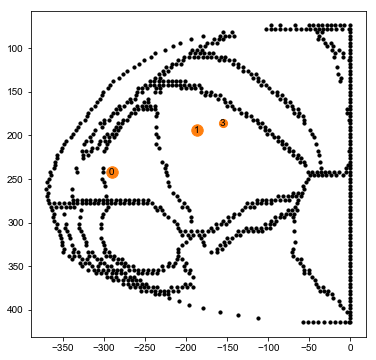

In [280]:
ename = '18454_00159'
print(celltype.loc[ename])
etype = celltype.region[ename]
en = my_neuron(swc_path + swc_dict[ename], scale=25, celltype=etype)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(anchor_df[anchor_df.is_boundary].z_expand, 
           anchor_df[anchor_df.is_boundary].x,
           c='k', s=10
          )
print(en.name)
for i,ename in enumerate(en.arbor_names):
    print(ename, en.arbors[ename].feature['2d_area'])
    ax.scatter(en.arbors[ename].feature['2d_x'],
               en.arbors[ename].feature['2d_y'],
               s=en.arbors[ename].feature['2d_area']*500,
               c=np.array(cmap[arbor_type.loc[ename, 'cluster']]).reshape(-1,3)
              )
    ax.text(en.arbors[ename].feature['2d_x'],
            en.arbors[ename].feature['2d_y'],
            s=ename.split('_')[-1], fontdict={'ha':'center', 'va':'center'}
              )
ax.invert_yaxis()

## Typical and extreme cases

In [29]:
features=['2d_area', 'total_length', 'radius', 'depth_mean', 'depth_std']

['18463_00012_0', '18457_00162_2', '18457_00058_2', '18457_00045_0', '18458_00542_1']
['18465_00133_0', '18465_00084_2', '18454_01014_0', '18464_00047_0', '18462_00058_1']
0.15969038584874765
0.2775152416360246


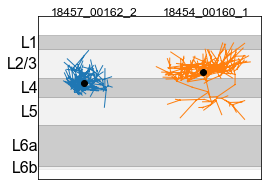

In [45]:
## typical

cdf = df.copy()[features]
scdf = pd.DataFrame(sklearn.preprocessing.scale(cdf, axis=0), index=cdf.index)
print(get_centers(scdf, arbor_type.cluster[cdf.index], cid='VPM_0'))
print(get_centers(scdf, arbor_type.cluster[cdf.index], cid='VPM_1'))


# alist = get_centers(scdf, arbor_type.cluster[cdf.index], cid='VPM_0', ncase=10)
# plot_arbor_list(alist, region='SSp', color=[cmap[i] for i in arbor_type.cluster[alist].tolist()])

# alist = get_centers(scdf, arbor_type.cluster[cdf.index], cid='VPM_1', ncase=10)
# plot_arbor_list(alist, region='SSp', color=[cmap[i] for i in arbor_type.cluster[alist].tolist()], x_shift=1250)


alist = ['18457_00162_2', '18454_00160_1']
print(arbor_dict[alist[0]].feature['2d_area'])
print(arbor_dict[alist[1]].feature['2d_area'])
plot_arbor_list(alist, region='SSp', color=[cmap[arbor_type.loc[alist[0], 'cluster']],
                                            cmap[arbor_type.loc[alist[1], 'cluster']]
                                           ])

18458_00185_1    0.053107
18457_00090_1    0.059838
18458_00424_0    0.059838
18455_00021_0    0.063462
18457_00048_0    0.074926
Name: 2d_area, dtype: float64
18455_00199_0    1.028259
18465_00048_1    0.714868
18455_00122_1    0.708437
18455_00123_3    0.686543
18454_00128_0    0.676262
Name: 2d_area, dtype: float64
18455_00200_1    35.890369
18463_00040_1    37.452691
18455_00123_2    38.278116
18463_00038_2    39.532149
18465_00092_1    44.486309
Name: depth_std, dtype: float64
18455_00156_2    366.951720
18455_00123_3    339.665696
18454_00048_2    329.221492
18458_00185_3    322.027187
18454_00136_3    313.106738
Name: depth_std, dtype: float64


2d_area  total_length      radius  depth_mean   depth_std
18457_00090_1  0.059838   6319.059523   96.273067  515.822456   79.964260
18455_00199_0  1.028259  60438.905797  484.556712  422.651864  231.563834
18455_00200_1  0.130030  15283.304408  136.290311  466.452990   35.890369
18455_00156_2  0.489944  14940.567113  431.370639  614.482761  366.951720

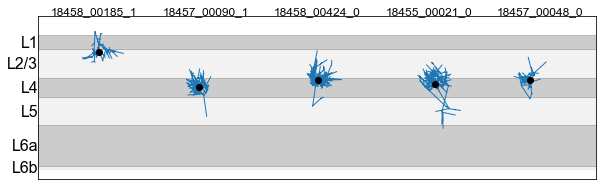

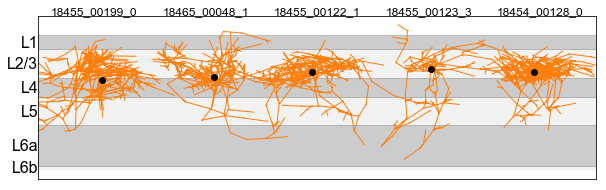

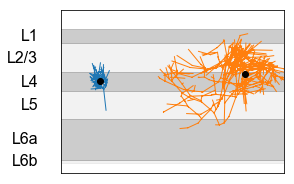

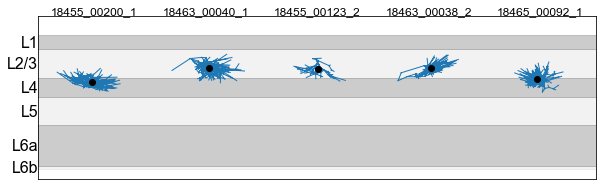

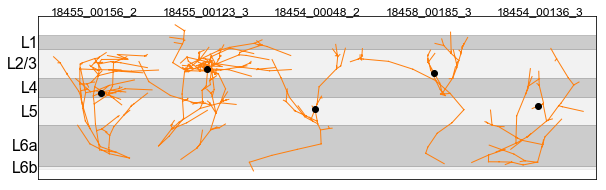

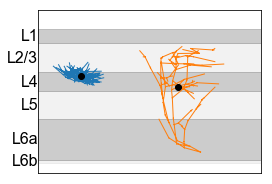

In [58]:
## extreme
## restricted
cregion = 'VPM'
# cdf = df.copy().loc[arbor_type[arbor_type.cluster.isin(['MG_0', 'MG_1'])].index]
cdf = df.copy().loc[arbor_type[arbor_type.cluster.isin(['VPM_0', 'VPM_1'])].index]
alist = cdf.sort_values(['2d_area']).head().index.tolist()
print(cdf.loc[alist, '2d_area'])
plot_arbor_list(alist, region=rgdict[cregion], color=[cmap[i] for i in arbor_type.loc[alist, 'cluster'].tolist()])

alist = cdf.sort_values(['2d_area'], ascending=False).head().index.tolist()
print(cdf.loc[alist, '2d_area'])
plot_arbor_list(alist, region=rgdict[cregion], color=[cmap[i] for i in arbor_type.loc[alist, 'cluster'].tolist()])

alist = ['18457_00090_1', '18455_00199_0']
ax = plot_arbor_list(alist, region=rgdict[cregion], arbor_name=False,
                     color=[cmap[i] for i in arbor_type.loc[alist, 'cluster'].tolist()], x_shift=1500)
ax.set_xlim(-500, 2000)

alist = cdf.sort_values(['depth_std'], ascending=True).head().index.tolist()
print(cdf.loc[alist, 'depth_std'])
plot_arbor_list(alist, region=rgdict[cregion], color=[cmap[i] for i in arbor_type.loc[alist, 'cluster'].tolist()])

alist = cdf.sort_values(['depth_std'], ascending=False).head().index.tolist()
print(cdf.loc[alist, 'depth_std'])
plot_arbor_list(alist, region=rgdict[cregion], color=[cmap[i] for i in arbor_type.loc[alist, 'cluster'].tolist()])

alist = ['18455_00200_1', '18455_00156_2']
ax = plot_arbor_list(alist, region=rgdict[cregion], arbor_name=False,
                     color=[cmap[i] for i in arbor_type.loc[alist, 'cluster'].tolist()])
ax.set_xlim(-500, 2000)

df.loc[['18457_00090_1', '18455_00199_0', 
         '18455_00200_1', '18455_00156_2'
        ], features]

## Combination of arbor types in single neurons

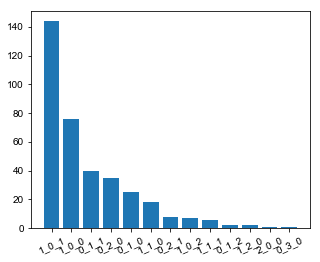

In [68]:
clist = sorted(list(set(cat.cell_id.tolist())))

res = pd.DataFrame(index=clist, columns=cucluster)
for cname in clist[:]:
    tp = cat[cat.cell_id==cname]['cluster'].value_counts()
    res.loc[cname] = tp.loc[cucluster]

code = []
for i in clist:
    tp = res.loc[i].tolist()
    tp = [str(i) for i in tp]
    code.append('_'.join(tp))
res['code'] = code

fig, ax = plt.subplots(1,1, figsize=(5,4))
tp = res.code.value_counts()
xt = np.arange(len(tp))
ax.bar(xt, tp)
ax.set_xticks(xt)
_ = ax.set_xticklabels(tp.index.tolist(), fontdict={'rotation':24})

In [75]:
res['n_targets'] = res['VPM_0']+res['VPM_1']
res['deep_collateral'] = res['VPM_2']>0
n = len(res)
print('single target: %.2f%%' % (len(res[res.n_targets==1])/n*100))
print('bi layer: %.2f%%' % (len(res[((res.n_targets==1) & (res.deep_collateral))])/n*100))
print('bi layer 0: %.2f%%' % (len(res[((res.n_targets==1) & (res.deep_collateral) & (res.VPM_0>0))])/n*100))
print('bi layer 1: %.2f%%' % (len(res[((res.n_targets==1) & (res.deep_collateral) & (res.VPM_1>0))])/n*100))

print('mono layer: %.2f%%' % (len(res[((res.n_targets==1) & (~res.deep_collateral))])/n*100))
print('mono layer 0: %.2f%%' % (len(res[((res.n_targets==1) & (~res.deep_collateral) & (res.VPM_0>0))])/n*100))
print('mono layer 1: %.2f%%' % (len(res[((res.n_targets==1) & (~res.deep_collateral) & (res.VPM_1>0))])/n*100))
print('multiple target: %.2f%%' % (len(res[res.n_targets>1])/n*100))
print('2 target: %.2f%%' % (len(res[res.n_targets==2])/n*100))
print('3 target: %.2f%%' % (len(res[res.n_targets==3])/n*100))
print('>3 target: %.2f%%' % (len(res[res.n_targets>3])/n*100))

single target: 80.55%
bi layer: 52.88%
bi layer 0: 41.37%
bi layer 1: 11.51%
mono layer: 27.67%
mono layer 0: 20.82%
mono layer 1: 6.85%
multiple target: 19.45%
2 target: 18.63%
3 target: 0.82%
>3 target: 0.00%


In [94]:
def arbor_distance(alist):
    tp = pd.DataFrame(index=alist, columns=['x', 'y', 'z'])
    for i in alist:
        tp.loc[i] = arbor_dict[i].center[['x', 'y', 'z']].tolist()
    res = pd.DataFrame(metrics.euclidean_distances(tp), index=alist, columns=alist)
#     print(tp)
    return res

arbor_distance(alist)

18454_00146_1  18454_00146_3
18454_00146_1        0.00000     1593.50251
18454_00146_3     1593.50251        0.00000

In [264]:
clist = res[((res.n_targets==1) & (~res.deep_collateral) & (res.VPM_2>0))].index.tolist()
# sclist = []
# for i in clist:
#     alist = df[df.cell_id==i].index.tolist()
#     d = arbor_distance(alist).iloc[0,1]
#     if d < 400:
#         sclist.append(i)
# df[df.cell_id.isin(sclist)]
df[df.cell_id.isin(clist)]

2d_x   2d_y  2d_area  total_length      radius  \
17545_00172_1 -155.392591  294.0     10.0  14045.467753  156.698299   
18454_00152_1 -188.803658  274.0     13.0  12892.605206  228.588804   
18454_01127_0  -96.992475  370.0     42.0  30355.057969  247.633284   
18455_00143_0 -164.412309  270.0     23.0  26139.428414  203.863659   
18455_00158_0 -301.880347  198.0     39.0  50047.506982  241.172855   
18457_00162_0 -149.590455  182.0     22.0  22573.335851  229.456858   
18458_00549_1 -117.898543  206.0     24.0  31809.688040  251.382299   
18458_00562_1 -119.720397  274.0     22.0  21934.202404  251.011369   
18462_00032_0 -314.243211  226.0     71.0  61828.472080  433.830136   
18462_00059_0 -205.589503  282.0     21.0  32421.040250  223.980600   
18465_00233_0 -113.878825  266.0     16.0  20400.486433  215.445147   

               depth_mean   depth_std  outlier_ratio celltype      cell_id  
17545_00172_1  497.338347  139.018952       0.000000      VPM  17545_00172  
18454_00152_1  635.322860  214.656338       0.985222      VPM  18454_00152  
18454_01127_0  405.759405   93.783213       0.000000      VPM  18454_01127  
18455_00143_0  735.928153  150.759949       0.000000      VPM  18455_00143  
18455_00158_0  463.286443  184.010798       0.000000      VPM  18455_00158  
18457_00162_0  581.417343  224.068415       0.833333      VPM  18457_00162  
18458_00549_1  603.747916  205.894279       0.000000      VPM  18458_00549  
18458_00562_1  306.264073  139.999988       0.000000      VPM  18458_00562  
18462_00032_0  499.283114  210.229876       0.000000      VPM  18462_00032  
18462_00059_0  566.054355  162.956856       0.000000      VPM  18462_00059  
18465_00233_0  409.721990  167.533961       0.000000      VPM  18465_00233

-420.8235451852661


(-500.0, 500.0, 1500.0, -200.0)

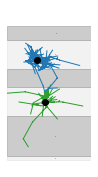

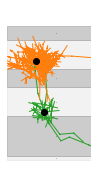

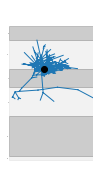

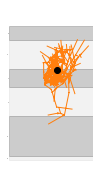

In [91]:
# Show examples
# bi: '18454_00046_0', '18454_00046_2'
# mono: 18454_01126

# 2 targets: '18454_00146_2', '18454_00146_3'
# 3 targets: '18455_00123_0', '18455_00123_1', '18455_00123_2',


# alist = ['17302_00053_0', '17302_00053_1']
alist = ['18454_00046_0', '18454_00046_2']
fig, ax = plt.subplots(1,1, figsize=(1.5, 3))
ca0 = arbor_dict[alist[0]]
ca1 = arbor_dict[alist[1]]
shift1 = (ca1.center.z-ca1.center.rx.iloc[0]) - (ca0.center.z-ca0.center.rx.iloc[0])
print(shift1)
shift1 = -180
plot_arbor_list(alist, 
                region=rgdict[cregion], 
                color=[cmap[i] for i in arbor_type.loc[alist, 'cluster'].tolist()], 
                x_shift = shift1,
                arbor_name = False,
                fontsize=0,
                ax = ax
               )
ax.set_xlim(-500, 500)
ax.axis('off')

alist = ['18455_00140_2', '18455_00140_0']
fig, ax = plt.subplots(1,1, figsize=(1.5, 3))
ca0 = arbor_dict[alist[0]]
ca1 = arbor_dict[alist[1]]
shift1 = (ca1.center.z-ca1.center.rx.iloc[0]) - (ca0.center.z-ca0.center.rx.iloc[0])
shift1 = -200
plot_arbor_list(alist, 
                region=rgdict[cregion], 
                color=[cmap[i] for i in arbor_type.loc[alist, 'cluster'].tolist()], 
                x_shift = shift1,
                arbor_name = False,
                fontsize=0,
                ax = ax
               )
ax.set_xlim(-500, 500)
ax.axis('off')

alist = ['18454_01126_0']
fig, ax = plt.subplots(1,1, figsize=(1.5, 3))
plot_arbor_list(alist, 
                region=rgdict[cregion], 
                color=[cmap[i] for i in arbor_type.loc[alist, 'cluster'].tolist()], 
                x_shift = 1000,
                arbor_name = False,
                fontsize=0,
                ax = ax
               )
ax.set_xlim(-500, 500)
ax.axis('off')

alist = ['18455_00143_0']
fig, ax = plt.subplots(1,1, figsize=(1.5, 3))
plot_arbor_list(alist, 
                region=rgdict[cregion], 
                color=[cmap[i] for i in arbor_type.loc[alist, 'cluster'].tolist()], 
                x_shift = 1000,
                arbor_name = False,
                fontsize=0,
                ax = ax
               )
ax.set_xlim(-500, 500)
ax.axis('off')

18454_00146_3  18454_00146_1
18454_00146_3        0.00000     1593.50251
18454_00146_1     1593.50251        0.00000

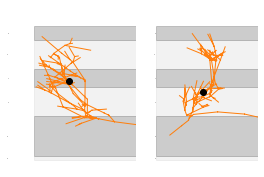

In [96]:
alist = ['18454_00146_3', '18454_00146_1']
fig, ax = plt.subplots(1,2, figsize=(4, 3))
plot_arbor_list(alist[:1], 
                region=rgdict[cregion], 
                color=[cmap[arbor_type.loc[alist[0], 'cluster']]], 
                x_shift = 1000,
                arbor_name = False,
                fontsize=0,
                ax = ax[0]
               )
ax[0].set_xlim(-300, 500)
ax[0].axis('off')
plot_arbor_list(alist[1:], 
                region=rgdict[cregion], 
                color=[cmap[arbor_type.loc[alist[1], 'cluster']]], 
                x_shift = 1000,
                arbor_name = False,
                fontsize=0,
                ax = ax[1]
               )
ax[1].set_xlim(-500, 300)
ax[1].axis('off')
arbor_distance(alist)

18455_00123_2  18455_00123_0  18455_00123_3
18455_00123_2       0.000000     794.939289    2921.293791
18455_00123_0     794.939289       0.000000    2167.394116
18455_00123_3    2921.293791    2167.394116       0.000000

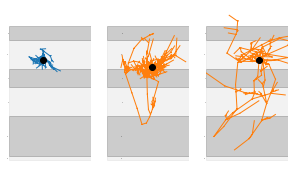

In [97]:
alist = ['18455_00123_2', '18455_00123_0', '18455_00123_3']
fig, ax = plt.subplots(1,3, figsize=(5, 3))
plot_arbor_list(alist[:1], 
                region=rgdict[cregion], 
                color=[cmap[arbor_type.loc[alist[0], 'cluster']]], 
                x_shift = 1000,
                arbor_name = False,
                fontsize=0,
                ax = ax[0]
               )
ax[0].set_xlim(-500, 700)
ax[0].axis('off')
plot_arbor_list(alist[1:2], 
                region=rgdict[cregion], 
                color=[cmap[arbor_type.loc[alist[1], 'cluster']]], 
                x_shift = 1000,
                arbor_name = False,
                fontsize=0,
                ax = ax[1]
               )
ax[1].set_xlim(-800, 800)
ax[1].axis('off')
plot_arbor_list(alist[2:], 
                region=rgdict[cregion], 
                color=[cmap[arbor_type.loc[alist[2], 'cluster']]], 
                x_shift = 1000,
                arbor_name = False,
                fontsize=0,
                ax = ax[2]
               )
ax[2].set_xlim(-500, 300)
ax[2].axis('off')

arbor_distance(alist)

## Topography

In [24]:
[ns1] = pickle.load(open('./neuron_set_1057seu.pickle', 'rb'))
[ns2] = pickle.load(open('./neuron_set_466allen.pickle', 'rb'))


In [25]:
soma_df = pd.concat([ns1.features['soma_features'].raw_data.copy(),
                     ns2.features['soma_features'].raw_data.copy()
                    ], axis=0)
soma_df.head()

x        y        z region
17302_00001  4912.75  4900.88  2445.78    CLA
17302_00002  4815.65  4976.62  2421.28    CLA
17302_00003  4908.25  4910.88  2340.62    CLA
17302_00005  4749.45  4608.62  2777.40     CP
17302_00006  4967.48  4418.42  2691.03     CP

In [110]:
tp = pd.concat([arbor_type,df.loc[arbor_type.index, ['2d_x', '2d_y', '2d_area', 'total_length', 'radius', 'depth_mean',
                                                     'depth_std', 'outlier_ratio', 'region']]], axis=1)
tp['2d_x'] = (-1)*tp['2d_x']
sx = []
sy = []
sz = []
for i in tp.index.tolist():
    cname = tp.loc[i, 'cell_id']
    sx.append(soma_df.loc[cname, 'x'])
    sy.append(soma_df.loc[cname, 'y'])
    sz.append(soma_df.loc[cname, 'z'])
tp['soma_x'] = sx
tp['soma_y'] = sy
tp['soma_z'] = sz

tp.head()

cluster      cell_id celltype        2d_x   2d_y   2d_area  \
17302_00053_1   VPM_1  17302_00053      VPM -217.609221  202.0  0.376703   
17302_00053_2   VPM_2  17302_00053      VPM -244.751357  214.0  0.291421   
17302_00054_0   VPM_1  17302_00054      VPM -267.586356  226.0  0.396155   
17302_00054_1   VPM_1  17302_00054      VPM -198.667143  158.0  0.260208   
17302_00112_1   VPM_2  17302_00112      VPM -204.353435  270.0  0.048891   

               total_length      radius   depth_mean   depth_std  \
17302_00053_1  23048.487562  224.315083   585.583336  227.132564   
17302_00053_2   5965.030586  487.340725  1018.347912  236.554544   
17302_00054_0  52963.742079  359.485115   625.243455  250.429102   
17302_00054_1   8644.347279  389.216222   580.195240  304.994947   
17302_00112_1   2711.319592   81.634300   827.131739   48.425737   

               outlier_ratio   region   soma_x   soma_y   soma_z  
17302_00053_1       2.709360    SSp-m  6642.67  4085.43  4045.83  
17302_00053_2       1.351351    SSp-m  6642.67  4085.43  4045.83  
17302_00054_0       0.282087      SSs  7122.50  4139.10  4442.95  
17302_00054_1       0.757576    SSp-m  7122.50  4139.10  4442.95  
17302_00112_1       0.000000  SSp-bfd  7131.20  4042.15  3576.05

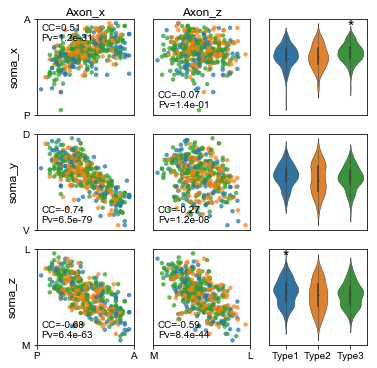

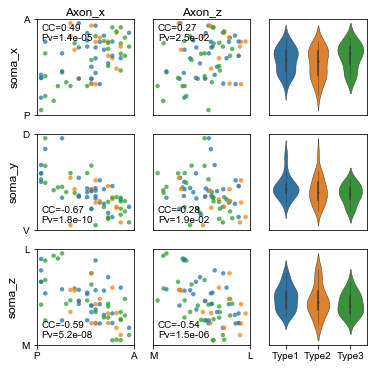

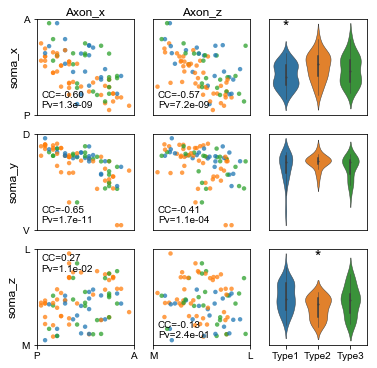

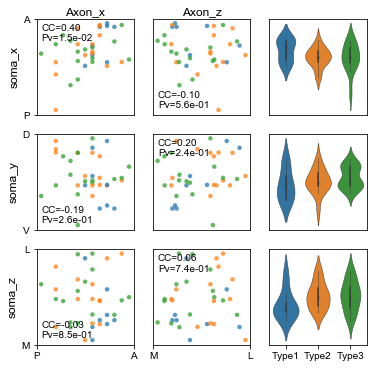

In [164]:

def topo_plot(cur_df, celltype=None):
    fig = plt.figure(figsize=(8,6))
    grid = plt.GridSpec(3,4,wspace=0.2, hspace=0.2)
    
#     # 1. Flat map
#     ax = fig.add_subplot(grid[:,4:])
#     # 2D map
#     sns.scatterplot(x='2d_x', y = '2d_y',
#                     hue='cluster',
#                     palette=cmap,
#                     data = cur_df,
#                     ax=ax,
#                     s=20, alpha=0.5,
#                     edgecolors = 'face'
#                    )
#     ax.scatter(anchor_df[anchor_df.is_boundary].z_expand, 
#             anchor_df[anchor_df.is_boundary].x,
#             c='k',
#             s=5
#           )
#     ax.invert_yaxis()
    
    # 2. Feature violin plots and 2-way scatter
    plt_features = ['soma_x', 'soma_y', 'soma_z']
    text_dict = {'soma_x':['Posterior', 'Anterior'],
                 'soma_y':['Ventral', 'Dorsal'],
                 'soma_z':['Medial', 'Lateral']
                }

    cur_df[plt_features] = cur_df[plt_features] / 1000
    cur_df[['2d_x', '2d_y']] = cur_df[['2d_x', '2d_y']] * 25 / 1000

    for i, cur_feature in enumerate(plt_features):
        ax = fig.add_subplot(grid[i,2:3])
        
        # Violin plot
        
        uclusters = sorted(list(set(cur_df.cluster.tolist())))
        sns.violinplot(x='cluster', y=cur_feature, order=uclusters, data=cur_df, ax=ax, linewidth=0.5)
        ax.invert_yaxis()
        # only xlabel the last subplot
        if i!=(len(plt_features)-1):
            ax.set_xticks([])
        else:
            ax.set_xticks([0,1,2])
            ax.set_xticklabels(['Type'+str(i) for i in [1,2,3]])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yticks([])
        # Annotate differential types
        for j,cc in enumerate(uclusters):
            tp_res =  scipy.stats.ttest_ind(cur_df.loc[cur_df.cluster==cc, cur_feature],
                                            cur_df.loc[cur_df.cluster!=cc, cur_feature])
            sv = tp_res.statistic
            pv = tp_res.pvalue * len(uclusters)
            pv_log = -np.log10(pv)
            lab = None
            if pv_log>5:
                lab = '*'*3
            elif pv_log>3:
                lab = '*'*2
            elif pv<0.05:
                lab = '*'*1
            if lab is not None:
                ax.text(j, ax.get_ylim()[0]*0.01+ax.get_ylim()[1]*0.99,
                        lab, fontdict={'ha':'center', 'va':'top', 'fontsize':16})    
        # Lael yaxis of the last figure

        # Scatter plots 1
        ax_scatter = fig.add_subplot(grid[i, 1])
        sns.scatterplot(x='2d_x',
                        y=cur_feature, 
                        hue='cluster', 
                        data=cur_df, 
                        legend=False,
                        s=20, alpha=0.75,
                        linewidth=0.0,
                        ax=ax_scatter)
        ax_scatter.set_xlabel('')
        ax_scatter.set_xticks([])
        if i == 0:           
            ax_scatter.text(ax_scatter.get_xlim()[0]*0.5+ax_scatter.get_xlim()[1]*0.5,
                            ax_scatter.get_ylim()[0]*(1.02)+ax_scatter.get_ylim()[1]*(-0.02),
                            'Axon_z',
                            fontdict={'ha':'center', 'va':'bottom', 'fontsize':12}
                           )
        ax_scatter.set_ylabel(cur_feature, fontdict={'fontsize':12})
        r, pv = scipy.stats.pearsonr(cur_df['2d_x'], cur_df[cur_feature])
        xlim = ax_scatter.get_xlim()
        ylim = ax_scatter.get_ylim()
        if r>0:
            ax_scatter.text(xlim[0]*0.05+xlim[1]*0.95,
                            ylim[0]*0.95+ylim[1]*0.05,
                            'CC=%.2f\nPv=%.1e' % (r, pv),
                            fontdict={'ha':'left', 'va':'top'}
                           )
        else:
            ax_scatter.text(xlim[0]*0.05+xlim[1]*0.95,
                            ylim[0]*0.05+ylim[1]*0.95,
                            'CC=%.2f\nPv=%.1e' % (r, pv),
                            fontdict={'ha':'left', 'va':'bottom'}
                           )
            
#         ax_scatter.set_title('%.2f; %.e' % (r, pv))
        ax_scatter.invert_xaxis()
        ax_scatter.invert_yaxis()
        ax_scatter.set_ylabel('')
        ax_scatter.set_yticks([])      
        if i == (len(plt_features)-1):
            ax_scatter.set_xticks(np.linspace(ax_scatter.get_xlim()[0], ax_scatter.get_xlim()[1], 2)) 
            ax_scatter.set_xticklabels(['M', 'L'])
                    
        # Scatter plots 2
        ax_scatter = fig.add_subplot(grid[i, 0])
        sns.scatterplot(x='2d_y',
                        y=cur_feature, 
                        hue='cluster', 
                        data=cur_df, 
                        legend=False,
                        s=20, alpha=0.75,
                        linewidth=0.0,
                        ax=ax_scatter)
        ax_scatter.set_xlabel('')
        ax_scatter.set_xticks([])
        if i == 0:            
            ax_scatter.text(ax_scatter.get_xlim()[0]*0.5+ax_scatter.get_xlim()[1]*0.5,
                            ax_scatter.get_ylim()[0]*(1.02)+ax_scatter.get_ylim()[1]*(-0.02),
                            'Axon_x',
                            fontdict={'ha':'center', 'va':'bottom', 'fontsize':12}
                           )
        ax_scatter.set_ylabel(cur_feature, fontdict={'fontsize':12})
        
        # Show p-value
        r, pv = scipy.stats.pearsonr(cur_df['2d_y'], cur_df[cur_feature])
        xlim = ax_scatter.get_xlim()
        ylim = ax_scatter.get_ylim()
        if r>0:
            ax_scatter.text(xlim[0]*0.05+xlim[1]*0.95,
                            ylim[0]*0.95+ylim[1]*0.05,
                            'CC=%.2f\nPv=%.1e' % (r, pv),
                            fontdict={'ha':'left', 'va':'top'}
                           )
        else:
            ax_scatter.text(xlim[0]*0.05+xlim[1]*0.95,
                            ylim[0]*0.05+ylim[1]*0.95,
                            'CC=%.2f\nPv=%.1e' % (r, pv),
                            fontdict={'ha':'left', 'va':'bottom'}
                           )
        
        # Set xy ticks
        ax_scatter.invert_xaxis()
        ax_scatter.invert_yaxis()
        if i == (len(plt_features)-1):
            ax_scatter.set_xticks(np.linspace(ax_scatter.get_xlim()[0], ax_scatter.get_xlim()[1], 2)) 
            ax_scatter.set_xticklabels(['P', 'A'])
        ax_scatter.set_yticks(np.linspace(ax_scatter.get_ylim()[0], ax_scatter.get_ylim()[1], 2)) 
        ax_scatter.set_yticklabels([i[0] for i in text_dict[cur_feature]])
        if i < 2:
            ax_scatter.set_xlabel('')
        if celltype is None:
            celltype = '/'.join(cur_df.celltype.value_counts().index.tolist())

        fig.savefig('../Figure/2D_topography_stats_'+celltype+'.pdf')
    return

topo_plot(tp[((tp.celltype=='VPM') &(tp.region.isin(['SSp-bfd', 'SSp-m', 'SSp-n'])))].copy())
topo_plot(tp[((tp.celltype=='VPL') & (tp.region.isin(['SSp-ll', 'SSp-ul', 'SSp-tr'])))].copy())
topo_plot(tp[((tp.celltype=='LGd') & (tp.region=='VISp'))].copy())
topo_plot(tp[((tp.celltype=='MG') & (tp.region=='AUDp'))].copy())


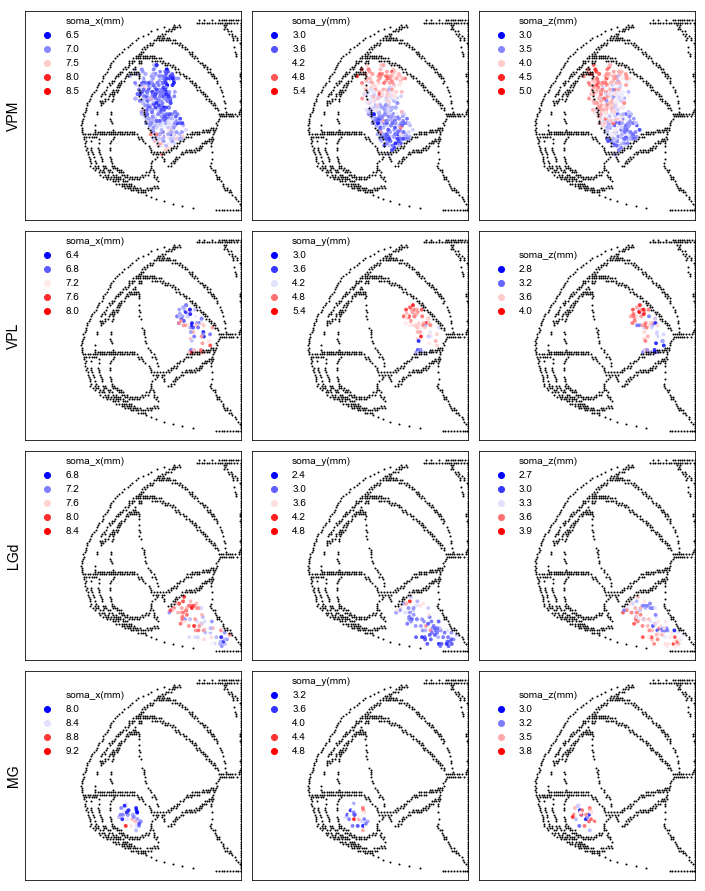

In [81]:
def topo_plot_2(cur_df, celltype=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,3, figsize=(12,4), gridspec_kw={'wspace':0.05, 'hspace':0.0})
#     grid = plt.GridSpec(1,3,wspace=0.0, hspace=0.0)
    
    cur_df.rename(columns={'soma_x':'soma_x(mm)',
                         'soma_y':'soma_y(mm)',
                         'soma_z':'soma_z(mm)'
                        }, inplace=True)
    plt_features = ['soma_x(mm)', 'soma_y(mm)', 'soma_z(mm)']
    cur_df[plt_features] = (cur_df[plt_features] / 1000).round(1)
    if celltype is None:
        celltype = '/'.join(cur_df.celltype.value_counts().index.tolist())
    for i, cur_feature in enumerate(plt_features):
        # Flat map
        cax = ax[i]
        # 2D map
        plot = sns.scatterplot(x='2d_x', y = '2d_y',
                        hue=cur_feature,
                        palette='bwr',
                        alpha=0.8,
                        data = cur_df,
                        ax=cax,
                               s=15,
                        linewidth=0
                       )
        # Sometimes too many decimals
        leg = plot.legend_
        for t in leg.texts[1:]:
            t.set_text(str(round(float(t.get_text()),1)))
        leg.set_bbox_to_anchor((0.35,0.55,0.15,0.25))
        leg.set_frame_on(False)
        cax.scatter(anchor_df[anchor_df.is_boundary].z_expand, 
                anchor_df[anchor_df.is_boundary].x,
                c='k',
                s=1,
                    edgecolors=None,
              )
        cax.invert_yaxis()
        cax.set_xticks([])
        cax.set_yticks([])
        cax.set_xlabel('')
        cax.set_xlim(-500,0)
        if i==0:
            cax.set_ylabel(celltype, fontdict={'fontsize':14})
        else:
            cax.set_ylabel('')
    if ax is None:
        fig.savefig('../Figure/2D_topography_'+celltype+'.pdf', bbox_inches='tight')
    return 

fig, ax = plt.subplots(4,3, figsize=(12,16), gridspec_kw={'wspace':0.05, 'hspace':0.05})

topo_plot_2(tp[((tp.celltype=='VPM') & (tp.region.isin(['SSp-bfd', 'SSp-m', 'SSp-n'])))].copy(),
            ax=ax[0]
           )
topo_plot_2(tp[((tp.celltype=='VPL') & (tp.region.isin(['SSp-ll', 'SSp-ul', 'SSp-tr'])))].copy(),
           ax=ax[1])
topo_plot_2(tp[((tp.celltype=='LGd') & (tp.region=='VISp'))].copy(),
           ax=ax[2])
topo_plot_2(tp[((tp.celltype=='MG') & (tp.region=='AUDp'))].copy(),
           ax=ax[3])
# topo_plot_2(tp[tp.celltype=='LP'].sort_values(['cluster']))
fig.savefig('../Figure/2D_topography.pdf', bbox_inches='tight')

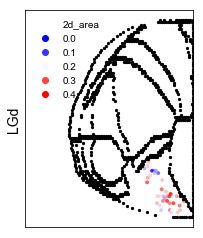

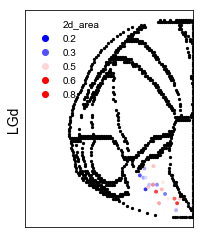

In [208]:
def topo_plot_3(cur_df, celltype=None, plt_features=['soma_x(mm)', 'soma_y(mm)', 'soma_z(mm)']):
    n = len(plt_features)
    fig, ax = plt.subplots(1,n, figsize=(3*n,4), gridspec_kw={'wspace':0.05, 'hspace':0.0})
#     grid = plt.GridSpec(1,3,wspace=0.0, hspace=0.0)
    
    cur_df.rename(columns={'soma_x':'soma_x(mm)',
                         'soma_y':'soma_y(mm)',
                         'soma_z':'soma_z(mm)'
                        }, inplace=True)
#     cur_df[plt_features] = (cur_df[plt_features] / 1000).round(1)
    if celltype is None:
        celltype = '/'.join(cur_df.celltype.value_counts().index.tolist())
    for i, cur_feature in enumerate(plt_features):
        # Flat map
        
        if n==1:
            cax = ax
        else:
            cax = ax[i]
        # 2D map
        plot = sns.scatterplot(x='2d_x', y = '2d_y',
                        hue=cur_feature,
                        palette='bwr',
                        alpha=0.8,
                        data = cur_df,
                        ax=cax,
                               s=15,
                        linewidth=0
                       )
        # Sometimes too many decimals
        leg = plot.legend_
        for t in leg.texts[1:]:
            t.set_text(str(round(float(t.get_text()),1)))
        leg.set_bbox_to_anchor((0.35,0.55,0.15,0.25))
        leg.set_frame_on(False)
        cax.scatter(anchor_df[anchor_df.is_boundary].z_expand, 
                anchor_df[anchor_df.is_boundary].x,
                c='k',
                s=5,
                    edgecolors=None,
              )
        cax.invert_yaxis()
        cax.set_xticks([])
        cax.set_yticks([])
        cax.set_xlabel('')
        cax.set_xlim(-500,0)
        if i==0:
            cax.set_ylabel(celltype, fontdict={'fontsize':14})
        else:
            cax.set_ylabel('')
    return 

topo_plot_3(tp[((tp.cluster=='LGd_0') & (tp.region=='VISp'))].sort_values(['cluster']), plt_features=['2d_area'])
topo_plot_3(tp[((tp.cluster=='LGd_1') & (tp.region=='VISp'))].sort_values(['cluster']), plt_features=['2d_area'])


In [162]:
# res = tp[((tp.celltype=='VPM') &(tp.region.isin(['SSp-bfd', 'SSp-m', 'SSp-n'])))].sort_values(['soma_y'])
# res = tp[((tp.celltype=='VPL') & (tp.region.isin(['SSp-ll', 'SSp-ul', 'SSp-tr'])))].sort_values(['soma_y'])
# res = tp[((tp.celltype=='LGd') & (tp.region.isin(['VISp'])))].sort_values(['soma_y'])
res = tp[((tp.celltype=='MG') & (tp.region.isin(['AUDp'])))].sort_values(['soma_x'])

res['rcelltype'] = [celltype.registration[i] for i in res.cell_id.tolist()]
res[res.rcelltype=='MG']

# '''
# VPL: 18465_00347; 18457_00197; 18454_01130
# LGd: 17302_00048; 18465_00119; 17545_00091
# MG: 
# '''

cluster      cell_id celltype        2d_x   2d_y   2d_area  \
18464_00080_1    MG_1  18464_00080       MG -269.831191  298.0  0.400297   
18464_00080_2    MG_2  18464_00080       MG -240.873774  310.0  0.267901   
18454_00149_2    MG_2  18454_00149       MG -264.601696  310.0  0.194675   
18454_00149_0    MG_0  18454_00149       MG -260.699479  306.0  0.143122   
18464_00079_0    MG_1  18464_00079       MG -236.340025  330.0  0.364647   
18464_00079_1    MG_2  18464_00079       MG -264.601696  310.0  0.322708   
17302_00036_0    MG_1  17302_00036       MG -232.439842  326.0  0.366201   
18454_00150_0    MG_1  18454_00150       MG -277.850910  302.0  0.352959   
18454_00063_3    MG_0  18454_00063       MG -279.258550  314.0  0.206140   
18458_00458_0    MG_1  18458_00458       MG -248.938269  318.0  0.420416   
18463_00032_0    MG_1  18463_00032       MG -240.281415  322.0  0.321008   
18463_00032_1    MG_2  18463_00032       MG -262.601696  314.0  0.260208   
17302_00079_2    MG_2  17302_00079       MG -262.601696  314.0  0.283655   
17302_00079_1    MG_1  17302_00079       MG -243.214197  342.0  0.307990   
17302_00035_1    MG_2  17302_00035       MG -282.666191  318.0  0.199409   
17302_00035_0    MG_0  17302_00035       MG -250.944842  314.0  0.192013   
18454_00069_0    MG_1  18454_00069       MG -250.944842  314.0  0.299706   
17545_00163_1    MG_1  17545_00163       MG -264.831191  294.0  0.240459   
17302_00038_3    MG_2  17302_00038       MG -243.122987  334.0  0.138388   
17302_00038_1    MG_0  17302_00038       MG -271.942119  306.0  0.166569   
18465_00312_3    MG_2  18465_00312       MG -267.265123  334.0  0.112944   

               total_length      radius  depth_mean   depth_std  \
18464_00080_1  33624.194602  304.374389  414.095823  170.183701   
18464_00080_2   7387.124117  307.684667  623.223619  192.866812   
18454_00149_2   4050.656996  384.935698  643.281553  136.047369   
18454_00149_0  11648.340558  171.805011  285.389345   67.298178   
18464_00079_0  19620.721785  247.255306  471.901726  149.378845   
18464_00079_1  14165.652983  303.546139  607.642058  188.164574   
17302_00036_0  27179.513303  256.031927  361.465178  164.710060   
18454_00150_0  24081.258546  230.901303  349.057642  104.562435   
18454_00063_3   9728.990653  231.614466  326.799596  107.058385   
18458_00458_0  27136.558226  222.405029  402.213599  150.668561   
18463_00032_0  21477.055665  201.114024  378.656801  123.665489   
18463_00032_1   6251.141507  419.615850  669.548218  200.956924   
17302_00079_2   8025.705998  367.023289  431.436814  164.471947   
17302_00079_1  22122.565968  216.657637  291.352374   85.103640   
17302_00035_1   7218.774018  410.907042  536.133267  232.559830   
17302_00035_0  17315.155671  158.040249  356.120227  130.317126   
18454_00069_0  21345.540968  189.801493  358.005713  169.999794   
17545_00163_1  25850.474678  228.838316  471.949004  217.738953   
17302_00038_3   3038.195763  307.702706  778.696091  157.067632   
17302_00038_1  19838.856586  193.805499  310.933988  154.125524   
18465_00312_3   1935.748821  455.264776  787.238395  181.029934   

               outlier_ratio region   soma_x   soma_y   soma_z rcelltype  
18464_00080_1       0.000000   AUDp  7982.92  3956.93  3442.80        MG  
18464_00080_2       0.000000   AUDp  7982.92  3956.93  3442.80        MG  
18454_00149_2       6.666667   AUDp  7992.75  4039.57  3609.35        MG  
18454_00149_0       0.000000   AUDp  7992.75  4039.57  3609.35        MG  
18464_00079_0       0.000000   AUDp  8094.50  3703.27  3447.50        MG  
18464_00079_1       0.000000   AUDp  8094.50  3703.27  3447.50        MG  
17302_00036_0       0.925926   AUDp  8154.42  3756.50  3597.48        MG  
18454_00150_0       0.000000   AUDp  8161.83  3970.45  3544.27        MG  
18454_00063_3       0.000000   AUDp  8206.65  3602.52  3629.55        MG  
18458_00458_0       3.691275   AUDp  8248.45  3997.25  3311.77        MG  
18463_00032_0       0.000000   AUDp  8272

In [ ]:
def order_regions(regions, by='x'):
    bydict = {'x':0, 'y':1, 'z':2}
    ax = bydict[by]
    array = nmt.annotation.array
    array = array[:,:,:int(array.shape[2]/2)]
    flist = []
    for cr in regions:
        ci = nmt.bs.get_all_child_id(nmt.bs.name_to_id(cr))
        flist.append(np.where(np.isin(array, ci))[ax].mean())
    df = pd.DataFrame({by:flist}, index=regions)
    return df.sort_values([by]).index.tolist()

ucelltypes = tp_all[~tp_all.celltype.isin(['VPM', 'VPL', 'LGd', 'MG'])].celltype.value_counts().index.tolist()
ucelltypes = order_regions(ucelltypes) 
ucelltypes

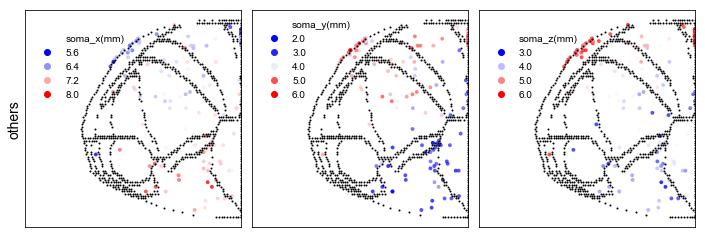

In [211]:
def topo_plot_2(cur_df, celltype=None, ax=None):
    if ax is None:
        save_plt = True
        fig, ax = plt.subplots(1,3, figsize=(12,4), gridspec_kw={'wspace':0.05, 'hspace':0.0})
    else:
        save_plt = False
#     grid = plt.GridSpec(1,3,wspace=0.0, hspace=0.0)
    
    cur_df.rename(columns={'soma_x':'soma_x(mm)',
                         'soma_y':'soma_y(mm)',
                         'soma_z':'soma_z(mm)'
                        }, inplace=True)
    plt_features = ['soma_x(mm)', 'soma_y(mm)', 'soma_z(mm)']
    cur_df[plt_features] = (cur_df[plt_features] / 1000).round(1)
    if celltype is None:
        celltype = '/'.join(cur_df.celltype.value_counts().index.tolist())
    for i, cur_feature in enumerate(plt_features):
        # Flat map
        cax = ax[i]
        # 2D map
        plot = sns.scatterplot(x='2d_x', y = '2d_y',
                        hue=cur_feature,
                        palette='bwr',
                        alpha=0.8,
                        data = cur_df,
                        ax=cax,
                               s=15,
                        linewidth=0
                       )
        # Sometimes too many decimals
        leg = plot.legend_
        for t in leg.texts[1:]:
            t.set_text(str(round(float(t.get_text()),1)))
        leg.set_bbox_to_anchor((0.35,0.55,0.15,0.25))
        leg.set_frame_on(False)
        cax.scatter(anchor_df[anchor_df.is_boundary].z_expand, 
                anchor_df[anchor_df.is_boundary].x,
                c='k',
                s=1,
                    edgecolors=None,
              )
        cax.invert_yaxis()
        cax.set_xticks([])
        cax.set_yticks([])
        cax.set_xlabel('')
        cax.set_xlim(-500,0)
        if i==0:
            cax.set_ylabel(celltype, fontdict={'fontsize':14})
        else:
            cax.set_ylabel('')
    if save_plt:
        fig.savefig('../Figure/2D_topography_'+celltype+'.pdf', bbox_inches='tight')
    return 

tp_all = df.copy()
tp_all['2d_x'] = (-1)*tp_all['2d_x']
tp_all = tp_all[tp_all.cell_id.isin(soma_df.index)]
sx = []
sy = []
sz = []
for i in tp_all.index.tolist():
    cname = tp_all.loc[i, 'cell_id']
    sx.append(soma_df.loc[cname, 'x'])
    sy.append(soma_df.loc[cname, 'y'])
    sz.append(soma_df.loc[cname, 'z'])
tp_all['soma_x'] = sx
tp_all['soma_y'] = sy
tp_all['soma_z'] = sz


topo_plot_2(tp_all[tp_all.celltype.isin(ucelltypes)].copy(), celltype='others')


In [183]:


def topo_plot_others(cur_df, ucelltypes=None):
    '''
    Data will be grouped by celltypes
    '''
    if ucelltypes is None:
        ucelltypes = sorted(list(set(cur_df.celltype.tolist())))
        ucelltypes = order_regions(ucelltypes)
    print('# celltypes:\t%d' % (len(ucelltypes)))
    
    ccode = 'tab20c'
    
    fig = plt.figure(figsize=(8,6))
    grid = plt.GridSpec(3,4,wspace=0.2, hspace=0.2)
    
    # 2. Feature violin plots and 2-way scatter
    plt_features = ['soma_x', 'soma_y', 'soma_z']
    text_dict = {'soma_x':['Posterior', 'Anterior'],
                 'soma_y':['Ventral', 'Dorsal'],
                 'soma_z':['Medial', 'Lateral']
                }

    cur_df[plt_features] = cur_df[plt_features] / 1000
    cur_df[['2d_x', '2d_y']] = cur_df[['2d_x', '2d_y']] * 25 / 1000

    for i, cur_feature in enumerate(plt_features):
        ax = fig.add_subplot(grid[i,2:4])
        
        # Violin plot        
        sns.violinplot(x='celltype', y=cur_feature, order=ucelltypes, data=cur_df, 
                       ax=ax, linewidth=0.15, palette=ccode)
        ax.invert_yaxis()
        # only xlabel the last subplot
        if i!=(len(plt_features)-1):
            ax.set_xticks([])
        else:
            ax.set_xticks(range(len(ucelltypes)))
            ax.set_xticklabels(ucelltypes, fontdict={'rotation':45})
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yticks([])
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.text(xlim[0]*(-0.05)+xlim[1]*(1.05),
                ylim[0]*0.5+ylim[1]*0.5,
                '%.2fmm' % (ylim[0]-ylim[1]),
                fontdict={'ha':'center', 'va':'center', 'fontsize':12, 'rotation':270}
               )
#         # Annotate differential types
#         for j,cc in enumerate(ucelltypes):
#             tp_res =  scipy.stats.ttest_ind(cur_df.loc[cur_df.celltype==cc, cur_feature],
#                                             cur_df.loc[cur_df.celltype!=cc, cur_feature])
#             sv = tp_res.statistic
#             pv = tp_res.pvalue * len(ucelltypes)
#             pv_log = -np.log10(pv)
#             lab = None
#             if pv_log>5:
#                 lab = '*'*3
#             elif pv_log>3:
#                 lab = '*'*2
#             elif pv<0.05:
#                 lab = '*'*1
#             if lab is not None:
#                 ax.text(j, ax.get_ylim()[0]*0.01+ax.get_ylim()[1]*0.99,
#                         lab, fontdict={'ha':'center', 'va':'top', 'fontsize':16})    

        # Scatter plots 1
        ax_scatter = fig.add_subplot(grid[i, 1])
        sns.scatterplot(x='2d_x',
                        y=cur_feature, 
                        hue='celltype', 
                        hue_order=ucelltypes,
                        data=cur_df, 
                        legend=False,
                        s=20, alpha=0.75,
                        linewidth=0.0,
                        ax=ax_scatter)
        ax_scatter.set_xlabel('')
        ax_scatter.set_xticks([])
        if i == 0:           
            ax_scatter.text(ax_scatter.get_xlim()[0]*0.5+ax_scatter.get_xlim()[1]*0.5,
                            ax_scatter.get_ylim()[0]*(1.02)+ax_scatter.get_ylim()[1]*(-0.02),
                            'Axon_z',
                            fontdict={'ha':'center', 'va':'bottom', 'fontsize':12}
                           )
        ax_scatter.set_ylabel(cur_feature, fontdict={'fontsize':12})
        r, pv = scipy.stats.pearsonr(cur_df['2d_x'], cur_df[cur_feature])
        xlim = ax_scatter.get_xlim()
        ylim = ax_scatter.get_ylim()
        if r>0:
            ax_scatter.text(xlim[0]*0.05+xlim[1]*0.95,
                            ylim[0]*0.95+ylim[1]*0.05,
                            'CC=%.2f\nPv=%.1e' % (r, pv),
                            fontdict={'ha':'left', 'va':'top'}
                           )
        else:
            ax_scatter.text(xlim[0]*0.05+xlim[1]*0.95,
                            ylim[0]*0.05+ylim[1]*0.95,
                            'CC=%.2f\nPv=%.1e' % (r, pv),
                            fontdict={'ha':'left', 'va':'bottom'}
                           )
            
#         ax_scatter.set_title('%.2f; %.e' % (r, pv))
        ax_scatter.invert_xaxis()
        ax_scatter.invert_yaxis()
        ax_scatter.set_ylabel('')
        ax_scatter.set_yticks([])      
        if i == (len(plt_features)-1):
            ax_scatter.set_xticks(np.linspace(ax_scatter.get_xlim()[0], ax_scatter.get_xlim()[1], 2)) 
            ax_scatter.set_xticklabels(['M', 'L'])
            ax_scatter.text(xlim[0]*0.5+xlim[1]*0.5,
                            ylim[1]*1.25+ylim[0]*(-0.25),
                            '%.2fmm' % (xlim[1]-xlim[0]),
                            fontdict={'ha':'center', 'fontsize':12}
                           )                    
        # Scatter plots 2
        ax_scatter = fig.add_subplot(grid[i, 0])
        sns.scatterplot(x='2d_y',
                        y=cur_feature, 
                        hue='celltype', 
                        hue_order=ucelltypes,
                        data=cur_df, 
                        legend=False,
                        s=20, alpha=0.75,
                        linewidth=0.0,
                        ax=ax_scatter)
        ax_scatter.set_xlabel('')
        ax_scatter.set_xticks([])
        if i == 0:            
            ax_scatter.text(ax_scatter.get_xlim()[0]*0.5+ax_scatter.get_xlim()[1]*0.5,
                            ax_scatter.get_ylim()[0]*(1.02)+ax_scatter.get_ylim()[1]*(-0.02),
                            'Axon_x',
                            fontdict={'ha':'center', 'va':'bottom', 'fontsize':12}
                           )
        ax_scatter.set_ylabel(cur_feature, fontdict={'fontsize':12})
        
        # Show p-value
        r, pv = scipy.stats.pearsonr(cur_df['2d_y'], cur_df[cur_feature])
        xlim = ax_scatter.get_xlim()
        ylim = ax_scatter.get_ylim()
        if r>0:
            ax_scatter.text(xlim[0]*0.05+xlim[1]*0.95,
                            ylim[0]*0.95+ylim[1]*0.05,
                            'CC=%.2f\nPv=%.1e' % (r, pv),
                            fontdict={'ha':'left', 'va':'top'}
                           )
        else:
            ax_scatter.text(xlim[0]*0.05+xlim[1]*0.95,
                            ylim[0]*0.05+ylim[1]*0.95,
                            'CC=%.2f\nPv=%.1e' % (r, pv),
                            fontdict={'ha':'left', 'va':'bottom'}
                           )
        
        # Set xy ticks
        ax_scatter.invert_xaxis()
        ax_scatter.invert_yaxis()
        if i == (len(plt_features)-1):
            ax_scatter.set_xticks(np.linspace(ax_scatter.get_xlim()[0], ax_scatter.get_xlim()[1], 2)) 
            ax_scatter.set_xticklabels(['P', 'A'])
            ax_scatter.text(xlim[0]*0.5+xlim[1]*0.5,
                            ylim[1]*1.25+ylim[0]*(-0.25),
                            '%.2fmm' % (xlim[1]-xlim[0]),
                            fontdict={'ha':'center', 'fontsize':12}
                           )
        ax_scatter.set_yticks(np.linspace(ax_scatter.get_ylim()[0], ax_scatter.get_ylim()[1], 2)) 
        ax_scatter.set_yticklabels([i[0] for i in text_dict[cur_feature]])
        if i < 2:
            ax_scatter.set_xlabel('')
#         if celltype is None:
#             celltype = '/'.join(cur_df.celltype.value_counts().index.tolist())        
    return fig


fig = topo_plot_others(tp_all[tp_all.celltype.isin(ucelltypes)].copy(), ucelltypes=ucelltypes)
fig.savefig('../Figure/2D_topography_stats_others.pdf', bbox_inches='tight')

['PT',
 'AM',
 'IAD',
 'IAM',
 'RE',
 'PVT',
 'RT',
 'VAL',
 'RH',
 'LD',
 'CM',
 'MD',
 'VM',
 'PO',
 'LP',
 'IGL']

In [478]:
tp_all

Empty DataFrame
Columns: [2d_x, 2d_y, 2d_area, total_length, radius, depth_mean, depth_std, outlier_ratio, celltype, cell_id, region, soma_x, soma_y, soma_z]
Index: []

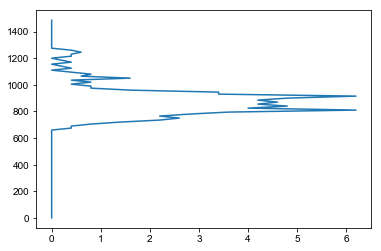

In [431]:
max_d = 1500
nbins = 100
bins = np.linspace(0, max_d, nbins+1, dtype=int)
cname_list = get_centers(cdf, zdf.cluster, 'c0', 5)
df_dp = pd.DataFrame(index=cname_list, columns=bins[:nbins])

for cname in cname_list:
    ct = pd.cut(arbor_dict[cname].depth.depth, bins, labels=bins[:nbins]).value_counts()
    df_dp.loc[cname] = ct.loc[df_dp.columns].tolist()

df_dp = df_dp.mean(axis=0)
plt.plot(df_dp, df_dp.index)

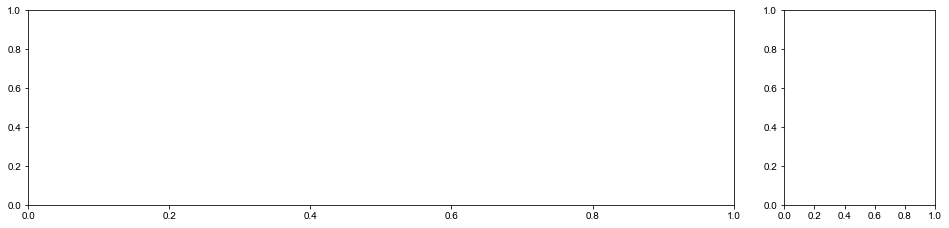

In [422]:
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_axes([0.1,0.1,0.7,0.9])
ax2 = fig.add_axes([0.85,0.1,0.15,0.9])

In [169]:
name_list = celltype[celltype.region=='LGd'].index.tolist()
# name_list = [i for i in name_list if i.startswith('18455')]
print(len(name_list))

ad = {}
df = None
for cname in name_list:
    ctype = celltype.region[cname]
    cn = nmt.neuron(swc_path + cname + '.swc', scale=25)
    tp = cn.get_segments()
    ca = cortical_arbor(tp, ss, name=cname, celltype=ctype)
    ad[cname] = ca
    
    tp = pd.DataFrame(ca.feature, columns=[cname]).transpose()
    if df is None:
        df = tp
    else:
        df = pd.concat([df, tp], axis=0)

df = df.sort_values(['radius'])

df

78


In [209]:
def get_celltype_arbor(type_list):
    name_list = celltype[celltype.region.isin(type_list)].index.tolist()
    print(len(name_list))

    ad = {}
    df = None
    for cname in name_list:
        ctype = celltype.region[cname]
        cn = nmt.neuron(swc_path + cname + '.swc', scale=25)
        tp = cn.get_segments()
        ca = cortical_arbor(tp, ss, name=cname, celltype=ctype)
        ad[cname] = ca

        tp = pd.DataFrame(ca.feature, columns=[cname]).transpose()
        if df is None:
            df = tp
        else:
            df = pd.concat([df, tp], axis=0)

    df = df.sort_values(['radius'])
    return ad, df

ad, df = get_celltype_arbor(['VPM'])

356
17302_00053: 14.00% arbor excluded.
17302_00054: 15.17% arbor excluded.
17545_00058: 10.03% arbor excluded.
17545_00075: 11.07% arbor excluded.
17545_00078: 10.51% arbor excluded.
17545_00169: 29.38% arbor excluded.
17545_00172: 11.30% arbor excluded.
18454_00052: 13.98% arbor excluded.
18454_00060: 12.75% arbor excluded.
18454_00067: 24.22% arbor excluded.
18454_00070: 13.99% arbor excluded.
18454_00071: 13.08% arbor excluded.
18454_00107: 14.20% arbor excluded.
18454_00128: 23.25% arbor excluded.
18454_00133: 11.67% arbor excluded.
18454_00135: 11.37% arbor excluded.
18454_00136: 32.39% arbor excluded.
18454_00137: 11.34% arbor excluded.
18454_00146: 44.72% arbor excluded.
18454_00152: 18.43% arbor excluded.
18454_00161: 24.48% arbor excluded.
18454_01009: 11.65% arbor excluded.
18454_01039: 11.61% arbor excluded.
18454_01041: 11.19% arbor excluded.
18454_01043: 10.93% arbor excluded.
18454_01047: 10.54% arbor excluded.
18454_01049: 10.20% arbor excluded.
18454_01055: 10.09% arbo

18454_00062
18455_00123
18454_01060
18454_01061
18455_00159
18465_00048
18465_00292
18465_00133
18458_00567
18465_00084


(-1000.0, 21000.0)

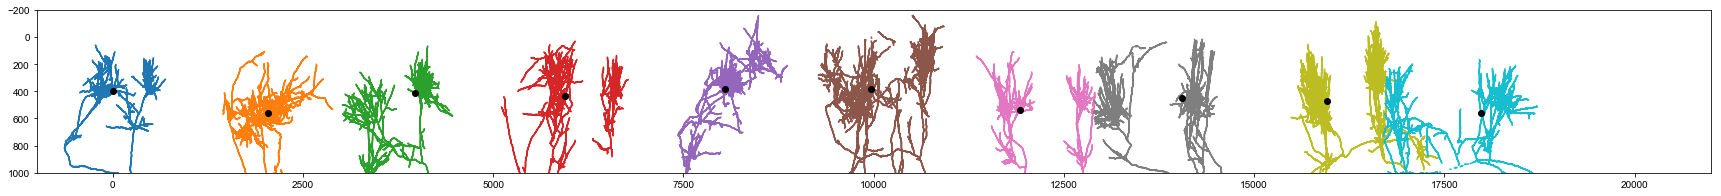

In [214]:
tp = df.copy()[df.radius>500]
x_shift = 2000
n = len(tp)
fig, ax = plt.subplots(1,1,figsize=(3*n, 3))

for i,cname in enumerate(tp.index.tolist()):
    ca = ad[cname]
    print(cname)
    ca.plot_arbor(ax=ax, x_shift=x_shift*i)

    
ax.set_ylim(1000, -200)
ax.set_xlim(-x_shift/2, x_shift*n--x_shift/2)